<a href="https://colab.research.google.com/github/Khalid1442/Electra/blob/main/Electra_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Perparation**

1.1. Environment Preparation

In [1]:
# =====================================================================
# ADVANCED TPU ENVIRONMENT PREPARATION v3.1 (2025-04-23)
# Optimized for Google Colab TPU v2-8 with TensorFlow 2.17.0
# Features:
#   - Robust TPU detection and verification
#   - Performance-optimized TensorFlow configuration
#   - Efficient memory usage patterns
#   - Hardware-specific tuning
#   - Integrated monitoring tools (W&B, TensorBoard, Bito AI)
#   - Automated dataset versioning and tracking
# =====================================================================

# First, install TensorFlow before importing
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Install TensorFlow first to avoid import errors
print("Installing TensorFlow and essential packages...")
!pip install tensorflow numpy==1.25.2
!pip install -q cloud-tpu-client protobuf google-api-core

# Now import TensorFlow
import tensorflow as tf
from google.colab import drive

# ===== 1. VERSION CONTROL AND PACKAGE INSTALLATION =====
def setup_packages():
    """Install and verify required packages for ML environment"""
    print("Setting up environment packages...")

    # Required package versions
    REQUIRED_TF_VERSION = "2.17.0"
    REQUIRED_NP_VERSION = "1.25.2"

    # Verify current versions
    current_tf = tf.__version__
    current_np = np.__version__

    # Only reinstall if versions don't match
    if current_tf != REQUIRED_TF_VERSION or current_np != REQUIRED_NP_VERSION:
        print(f"Updating TensorFlow to {REQUIRED_TF_VERSION} and NumPy to {REQUIRED_NP_VERSION}...")
        !pip install -q tensorflow=={REQUIRED_TF_VERSION} numpy=={REQUIRED_NP_VERSION}
        print("Package update complete. You may need to restart runtime if versions are different.")

    # Install monitoring and quality tools with corrected commands
    print("Installing monitoring and quality tools...")

    # Install W&B correctly
    !pip install -q wandb

    # Install Bito AI with correct package name
    !pip install -q bito-ai

    # Install Prospector
    !pip install -q prospector

    # Install TensorBoard
    !pip install -q tensorboard

    # Verify installations after potential updates
    current_tf = tf.__version__
    current_np = np.__version__
    print(f"✓ Using TensorFlow {current_tf} and NumPy {current_np}")

    # Mount Google Drive
    drive.mount('/content/drive', force_remount=True)

    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)

    # Reduce TensorFlow logging verbosity
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

    # Initialize Weights & Biases (requires login)
    print("To use W&B, you'll need to log in with your API key")
    print("Run this command separately in a code cell: !wandb login YOUR_API_KEY")

    # Initialize Bito AI API key
    print("To use Bito AI, you'll need to set the API key")
    print("Set the environment variable: os.environ['BITO_API_KEY'] = 'your_api_key_here'")

# ===== 2. TPU DETECTION AND VERIFICATION =====
def detect_hardware():
    """Confirm TPU availability and access TPU that was assigned via selection"""
    print("\nConfirming hardware acceleration...")

    # Try to detect TPU
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        print(f"✓ TPU detected: {tpu.cluster_spec().as_dict()}")
        strategy = tf.distribute.TPUStrategy(tpu)
        return "TPU", strategy
    except ValueError as e:
        print(f"TPU not available: {e}")

    # If no TPU, check for GPU
    print("Checking for GPU...")
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"✓ {len(gpus)} GPU(s) detected: {gpus}")
        # Check GPU performance
        return test_gpu_performance(gpus)
    else:
        print("No GPU detected, falling back to CPU.")
        return "CPU", tf.distribute.get_strategy()

def test_gpu_performance(gpus):
    """Test GPU performance with matrix multiplication benchmarks"""
    # Configure memory growth to avoid OOM errors
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        print("Could not set memory growth for GPU")

    # Run matrix multiplication benchmark
    sizes = [2000, 4000]
    timings = {}

    for size in sizes:
        # Create large matrices
        matrix_a = tf.random.normal([size, size])
        matrix_b = tf.random.normal([size, size])

        # Warm-up run
        _ = tf.matmul(matrix_a, matrix_b)

        # Timed run
        start_time = time.time()
        result = tf.matmul(matrix_a, matrix_b)
        # Force execution
        _ = result.numpy()
        execution_time = time.time() - start_time

        timings[size] = execution_time
        print(f"  Matrix size {size}x{size}: {execution_time:.2f} seconds")

    # Determine performance tier based on largest matrix timing
    largest_size = max(sizes)
    largest_timing = timings[largest_size]

    if largest_timing < 0.2:
        print("✓ High-performance GPU detected")
    elif largest_timing < 3.0:
        print("✓ Standard GPU detected")
    else:
        print("✓ Low-performance GPU or CPU detected")

    # Create strategy
    if len(gpus) > 1:
        strategy = tf.distribute.MirroredStrategy()
        print(f"Using MirroredStrategy with {strategy.num_replicas_in_sync} GPUs")
    else:
        strategy = tf.distribute.get_strategy()
        print("Using default strategy for single GPU")

    return "GPU", strategy

# ===== 3. TENSORFLOW CONFIGURATION =====
def configure_tensorflow(acceleration_type, strategy):
    """Configure TensorFlow for optimal performance based on hardware"""
    print(f"\nConfiguring TensorFlow for {acceleration_type}...")

    # Batch size recommendations based on hardware
    batch_size_recommendations = {
        'TPU': {'min': 128, 'optimal': 512, 'max': 2048},
        'GPU': {'min': 64, 'optimal': 256, 'max': 1024},
        'CPU': {'min': 32, 'optimal': 128, 'max': 512}
    }[acceleration_type]

    # Enable mixed precision for TPU and GPU
    if acceleration_type in ["TPU", "GPU"]:
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
        print("✓ Mixed precision enabled")

    # Set CPU-specific optimizations
    if acceleration_type == "CPU":
        # Set thread count for CPU parallelism
        tf.config.threading.set_intra_op_parallelism_threads(8)
        tf.config.threading.set_inter_op_parallelism_threads(8)
        print("✓ CPU parallelism configured")

    return batch_size_recommendations

# ===== 4. MONITORING TOOLS SETUP =====
def setup_monitoring_tools(project_name="ml-project", log_dir="./logs"):
    """Set up monitoring and quality analysis tools"""
    import datetime

    # Create log directory if it doesn't exist
    os.makedirs(log_dir, exist_ok=True)

    # Initialize TensorBoard
    log_dir_tb = os.path.join(log_dir, "tensorboard", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir_tb,
        histogram_freq=1,
        update_freq='epoch',
        profile_batch=2
    )

    # Initialize W&B (if installed)
    wandb_callback = None
    try:
        import wandb
        # Check if wandb is logged in
        try:
            wandb.init(project=project_name, sync_tensorboard=True)
            print("✓ W&B initialized and synced with TensorBoard")
            wandb_callback = wandb.keras.WandbCallback()
        except Exception as e:
            print(f"⚠ W&B login required: {e}")
            print("  Run '!wandb login YOUR_API_KEY' in a separate cell")
    except ImportError:
        print("⚠ W&B not installed properly. Run 'pip install wandb' in a separate cell.")

    # Run Prospector code quality check (if installed)
    try:
        import prospector
        print("\nRunning Prospector code quality check...")
        !prospector -o json > {log_dir}/code_quality.json
        print(f"✓ Code quality report saved to {log_dir}/code_quality.json")
    except ImportError:
        print("⚠ Prospector not installed properly. Run 'pip install prospector' in a separate cell.")

    # Initialize Bito AI (if installed)
    try:
        import bito
        if 'BITO_API_KEY' in os.environ:
            print("✓ Bito AI initialized with API key")
        else:
            print("Set the environment variable: os.environ['BITO_API_KEY'] = 'your_api_key_here'")
    except ImportError:
        print("⚠ Bito AI not installed properly. Run 'pip install bito-ai' in a separate cell.")

    # Return callbacks for model training
    callbacks = [tensorboard_callback]
    if wandb_callback:
        callbacks.append(wandb_callback)

    return {
        'callbacks': callbacks,
        'log_dir': log_dir,
        'tensorboard_log_dir': log_dir_tb
    }

# ===== 5. MAIN ENVIRONMENT PREPARATION =====
def prepare_environment(project_name="ml-project"):
    """Main function to set up ML environment"""
    print("="*80)
    print("ADVANCED TPU ENVIRONMENT PREPARATION v3.1")
    print("="*80)

    # Step 1: Set up required packages
    setup_packages()

    # Step 2: Detect hardware acceleration
    acceleration_type, strategy = detect_hardware()

    # Step 3: Configure TensorFlow optimally
    batch_size_recommendations = configure_tensorflow(acceleration_type, strategy)

    # Step 4: Set up monitoring tools
    monitoring = setup_monitoring_tools(project_name=project_name)

    # Final summary
    print("\n" + "="*80)
    print(f"ENVIRONMENT READY: {acceleration_type}")
    print(f"Strategy: {strategy.__class__.__name__}")
    print(f"TensorFlow: {tf.__version__}, NumPy: {np.__version__}")
    print(f"Recommended batch size: {batch_size_recommendations['optimal']}")
    print(f"Monitoring tools: TensorBoard, W&B, Prospector, Bito AI")
    print(f"TensorBoard logs: {monitoring['tensorboard_log_dir']}")
    print("="*80)

    # Return useful objects for further code
    return {
        'strategy': strategy,
        'acceleration_type': acceleration_type,
        'batch_size': batch_size_recommendations['optimal'],
        'batch_size_recommendations': batch_size_recommendations,
        'monitoring': monitoring,
        'callbacks': monitoring['callbacks']
    }

# ===== 6. EXECUTE ENVIRONMENT PREPARATION =====
# Execute the environment preparation
env = prepare_environment(project_name="electra-analysis")

# ===== 7. DATA LOADING AND VERSIONING =====
# Load Electra dataset
electra_path = '/content/drive/MyDrive/Datasets/Electra/electra_modbus.csv'
df = pd.read_csv(electra_path)

# Log dataset info to W&B (if initialized)
try:
    import wandb
    if wandb.run is not None:
        # Create dataset artifact
        artifact = wandb.Artifact(
            name="electra-dataset",
            type="dataset",
            description="Electra Modbus dataset"
        )
        # Add dataset file to artifact
        artifact.add_file(electra_path)
        # Log metadata
        wandb.log({
            "dataset_rows": len(df),
            "dataset_columns": len(df.columns),
            "dataset_memory_usage": df.memory_usage(deep=True).sum() / (1024 * 1024),  # MB
        })
        # Log artifact
        wandb.log_artifact(artifact)
        print(f"✓ Dataset logged to W&B with {len(df)} rows and {len(df.columns)} columns")
    else:
        print("⚠ W&B not initialized. Log in with 'wandb login' to enable dataset tracking.")
except Exception as e:
    print(f"⚠ W&B dataset logging skipped: {e}")

print("Environment prepared with essential libraries and hardware acceleration configured.")

Installing TensorFlow and essential packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 8.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
google-cloud-storage 2.19.0 requires google-api-core<3.0.0dev,>=2.15.0, but you have google-api-core 1.34.1 which is incompatible.
ADVANCED TPU ENVIRONMENT PREPARATION v3.1
Setting up environment packages...
Updating TensorFlow to 2.17.0 and NumPy to 1.25.2...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.7 MB/s eta 0:00:00
Package update complete. You may need to restart runtime if versions are different.
Installing monitoring and quality tools...
   ━━━━━━━━━

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: seuproject2020 (seuproject2020-imam-abdulrahman-bin-faisal-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


✓ W&B initialized and synced with TensorBoard

Running Prospector code quality check...
Traceback (most recent call last):
  File "/usr/local/bin/prospector", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/prospector/run.py", line 207, in main
    prospector.execute()
  File "/usr/local/lib/python3.11/dist-packages/prospector/run.py", line 79, in execute
    for tool in self.config.get_tools(found_files):
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/prospector/config/__init__.py", line 74, in get_tools
    config_result = tool.configure(self, found_files)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/prospector/tools/pycodestyle/__init__.py", line 123, in configure
    check_paths = [str(f.absolute()) for f in found_files.python_modules]
                                              ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File 

1.2 Data Loading

In [2]:
# Mount Google Drive
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

# Load Electra dataset
electra_path = '/content/drive/MyDrive/Datasets/Electra/electra_modbus.csv'
df = pd.read_csv(electra_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1.3 Data Exploring


======== GENERAL DATASET EXPLORATION ========

Dataset Shape: (16289277, 11)

First 5 rows:


,Time,smac,dmac,sip,dip,request,fc,error,address,data,label
0,0,00:1b:1b:c1:41:1b,08:00:27:79:b0:4a,10.70.38.51,10.70.38.55,1,3,0,1,68,MITM_UNALTERED
1,2107,08:00:27:79:b0:4a,00:0e:8c:e1:dd:58,10.70.38.51,10.70.38.55,1,3,0,1,68,MITM_UNALTERED
2,377,00:1b:1b:c1:41:1b,00:0e:8c:e1:de:9c,10.70.38.51,10.70.38.56,1,3,0,1,68,NORMAL
3,8718,00:0e:8c:e1:dd:58,08:00:27:79:b0:4a,10.70.38.55,10.70.38.51,0,3,0,1,0,MITM_UNALTERED
4,8718,00:0e:8c:e1:dd:58,08:00:27:79:b0:4a,10.70.38.55,10.70.38.51,0,3,0,2,0,MITM_UNALTERED



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16289277 entries, 0 to 16289276
Data columns (total 11 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   Time     int64 
 1   smac     object
 2   dmac     object
 3   sip      object
 4   dip      object
 5   request  int64 
 6   fc       int64 
 7   error    int64 
 8   address  int64 
 9   data     int64 
 10  label    object
dtypes: int64(6), object(5)
memory usage: 1.3+ GB


None


Summary Statistics:


,Time,request,fc,error,address,data
count,1.628928e+07,1.628928e+07,1.628928e+07,1.628928e+07,1.628928e+07,1.628928e+07
mean,2.513503e+10,1.714723e-02,3.090700e+00,2.492007e-03,6.511852e+01,1.897767e+04
std,1.462872e+10,1.298199e-01,3.712919e+00,6.713456e-01,1.309133e+03,2.956260e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.265155e+10,0.000000e+00,3.000000e+00,0.000000e+00,1.700000e+01,0.000000e+00
50%,2.493965e+10,0.000000e+00,3.000000e+00,0.000000e+00,3.500000e+01,0.000000e+00
75%,3.806163e+10,0.000000e+00,3.000000e+00,0.000000e+00,5.300000e+01,6.553500e+04
max,5.033374e+10,1.000000e+00,2.550000e+02,2.550000e+02,6.531100e+04,6.553500e+04



Dataset memory usage: 6153.12 MB

Missing Values:


,0
Time,0
smac,0
dmac,0
sip,0
dip,0
request,0
fc,0
error,0
address,0
data,0


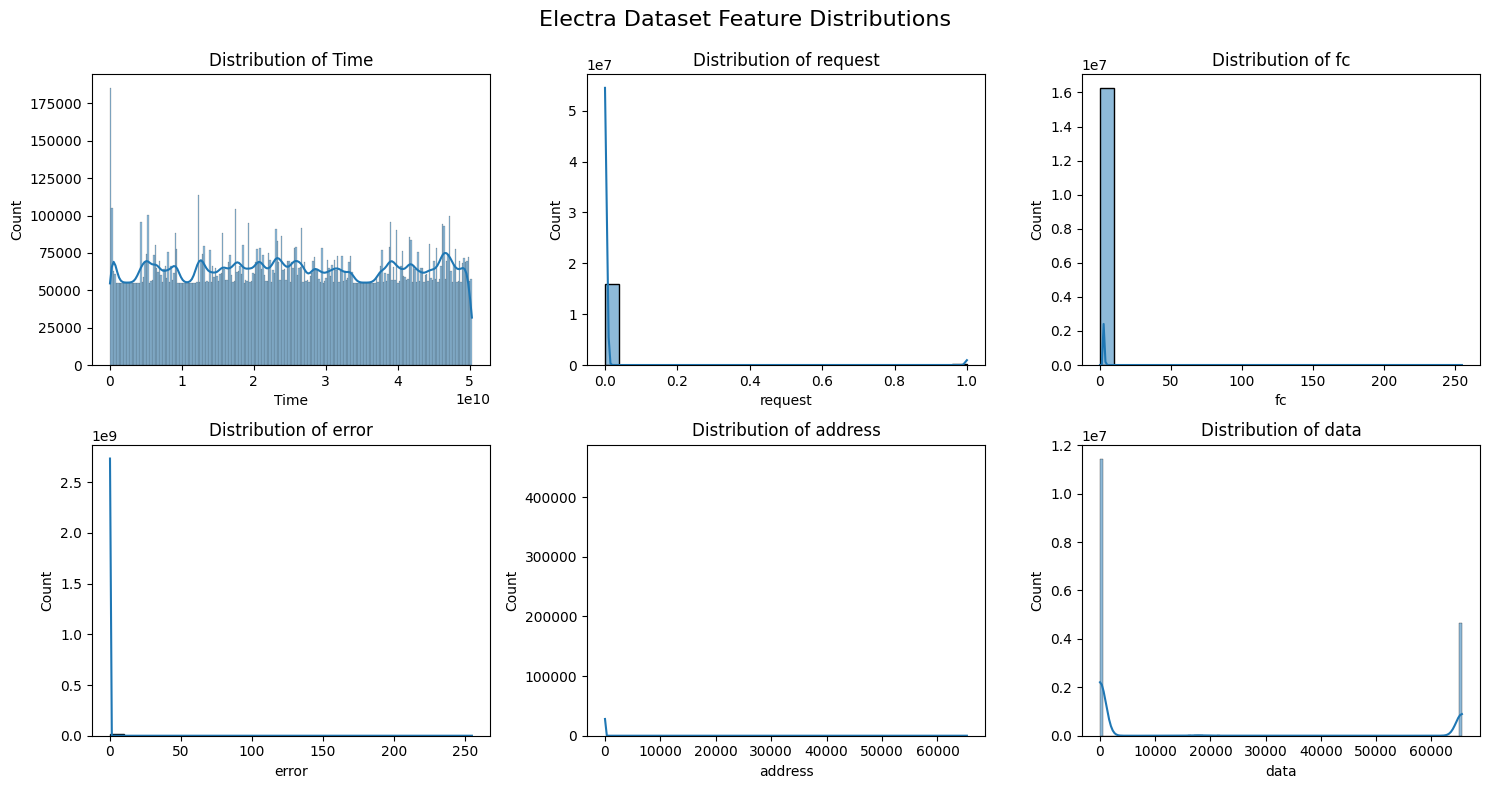

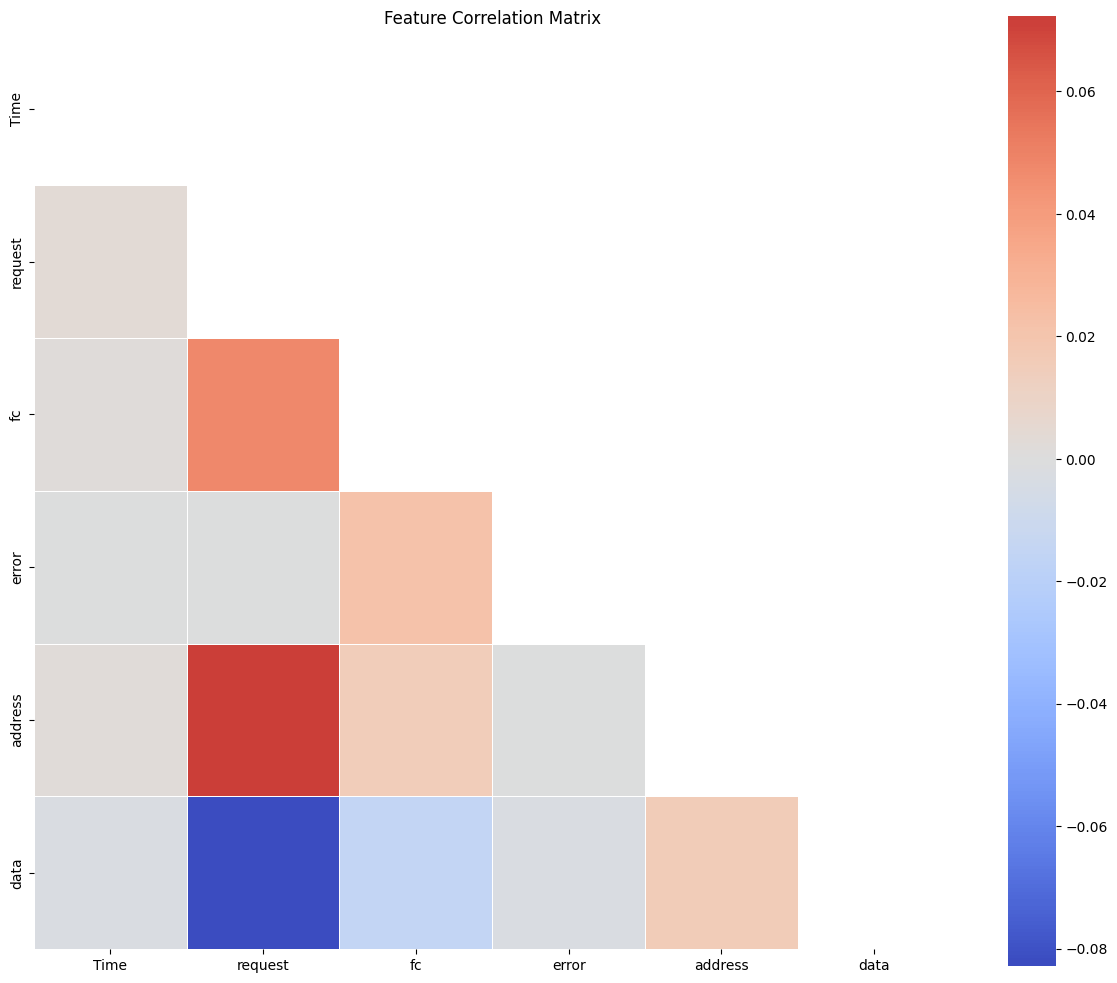

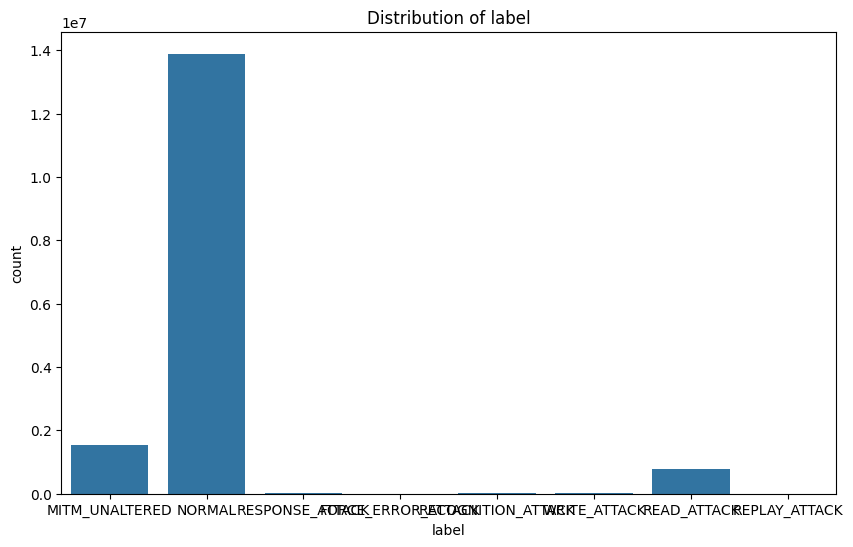


label distribution:


,count
label,
NORMAL,13894323
MITM_UNALTERED,1550617
READ_ATTACK,785961
RECOGNITION_ATTACK,30580
RESPONSE_ATTACK,16353
WRITE_ATTACK,9417
FORCE_ERROR_ATTACK,1129
REPLAY_ATTACK,897


Imbalance ratio: 15489.77:1

======== MODBUS & ICS TRAFFIC PATTERNS FOR EKANS SIMULATION ========

--- Register Access Analysis (EKANS manipulates specific registers) ---


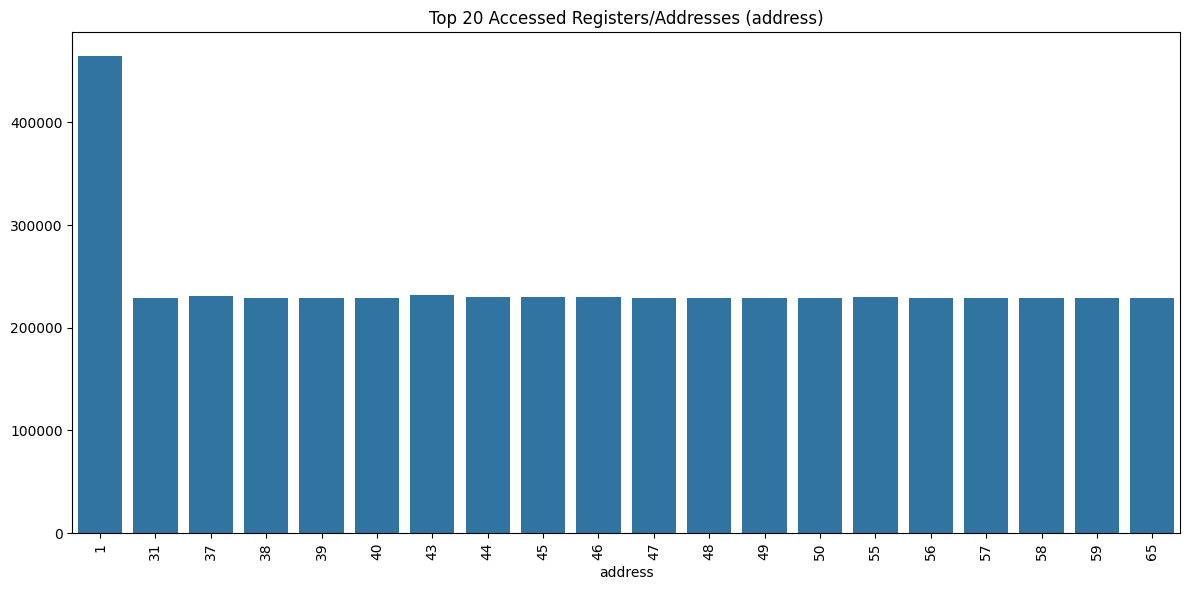


--- Timing Pattern Analysis (EKANS uses specific timing patterns) ---
Converted Time to datetime


<ipython-input-8-1f1a0386fa62>:178: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0, df[f'{col}_diff'].quantile(0.95))  # Limit to 95th percentile for clarity


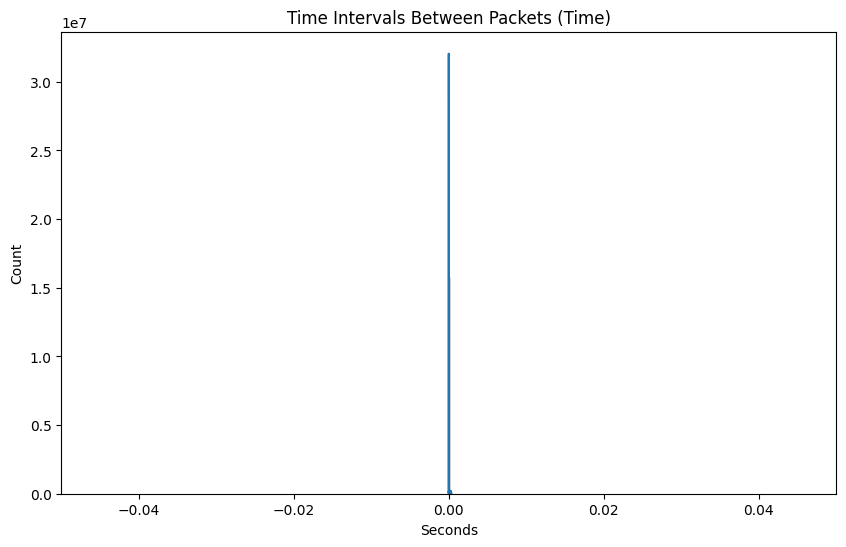


--- Normal vs. Abnormal Traffic Profiles (Baseline for EKANS Simulation) ---
Normal traffic: 13894323 records (85.30%)
Abnormal traffic: 2394954 records (14.70%)


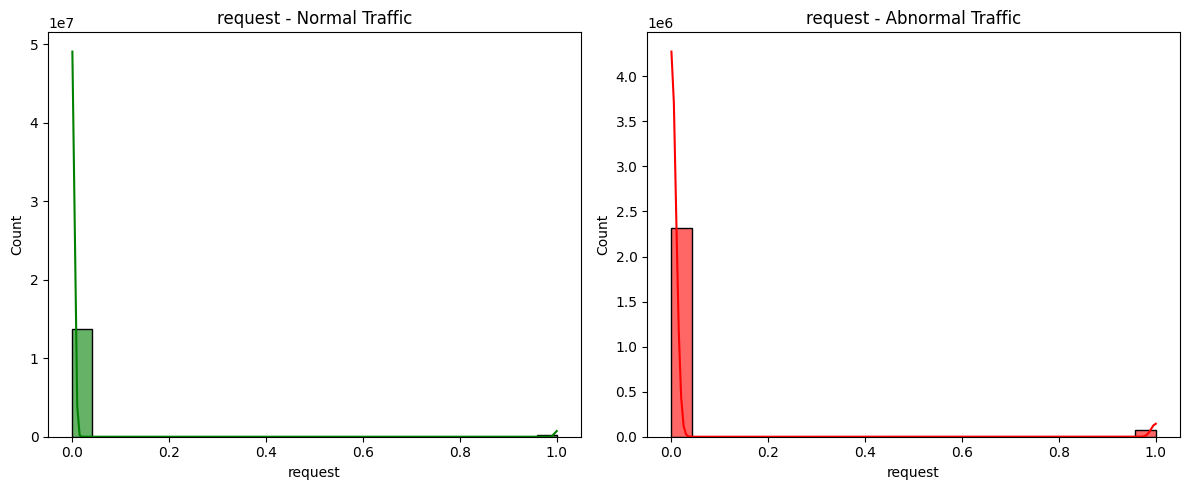

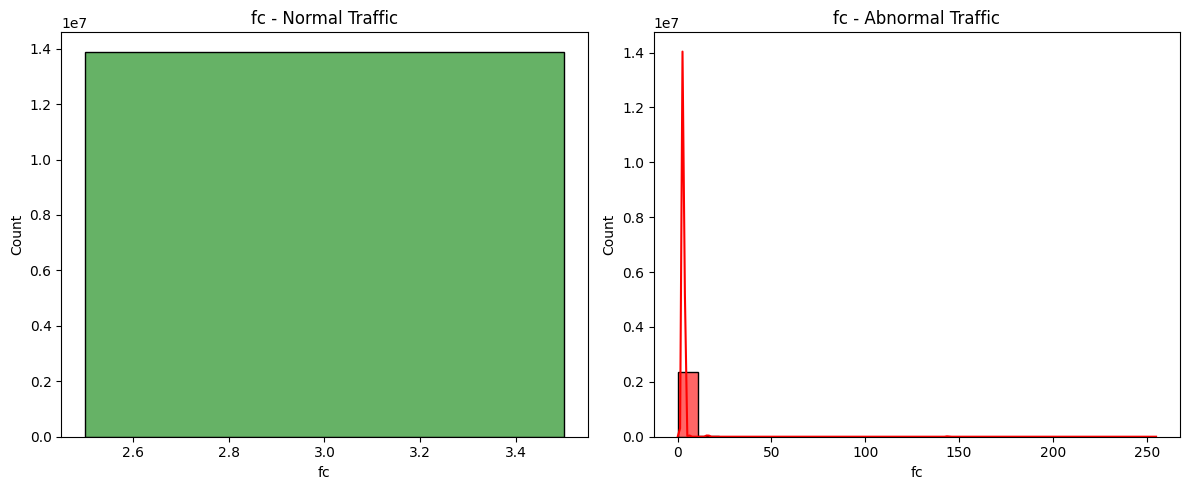

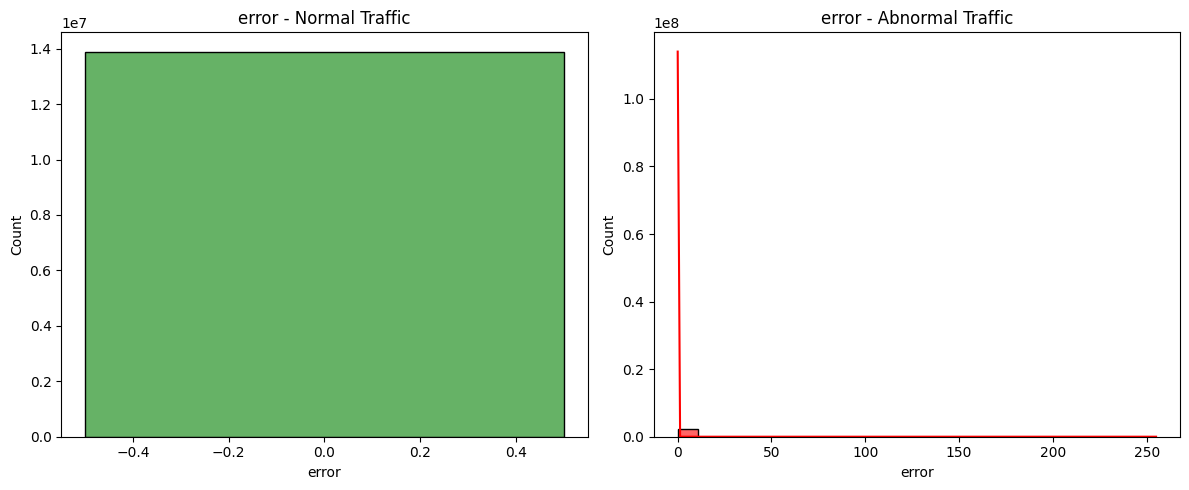

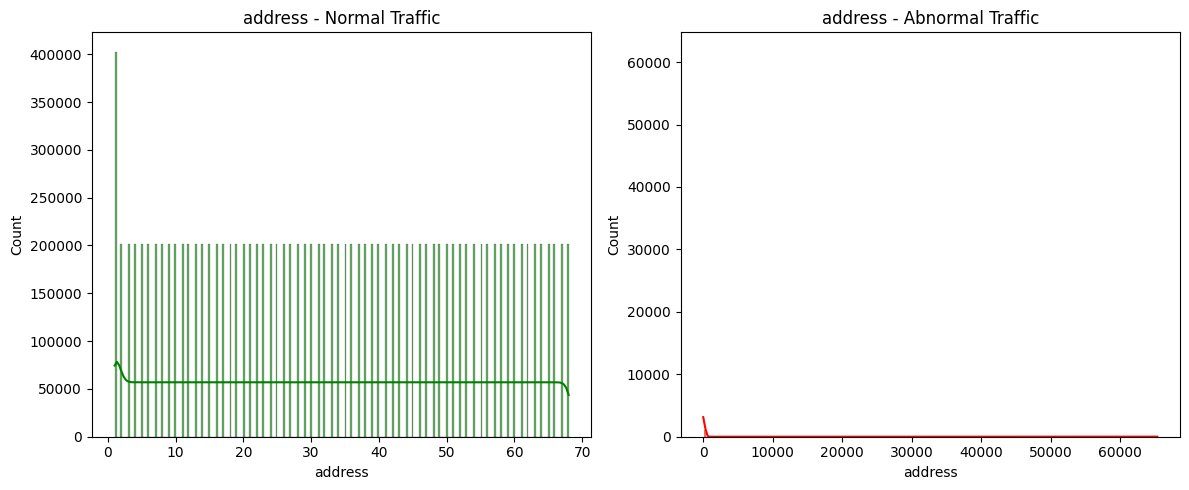

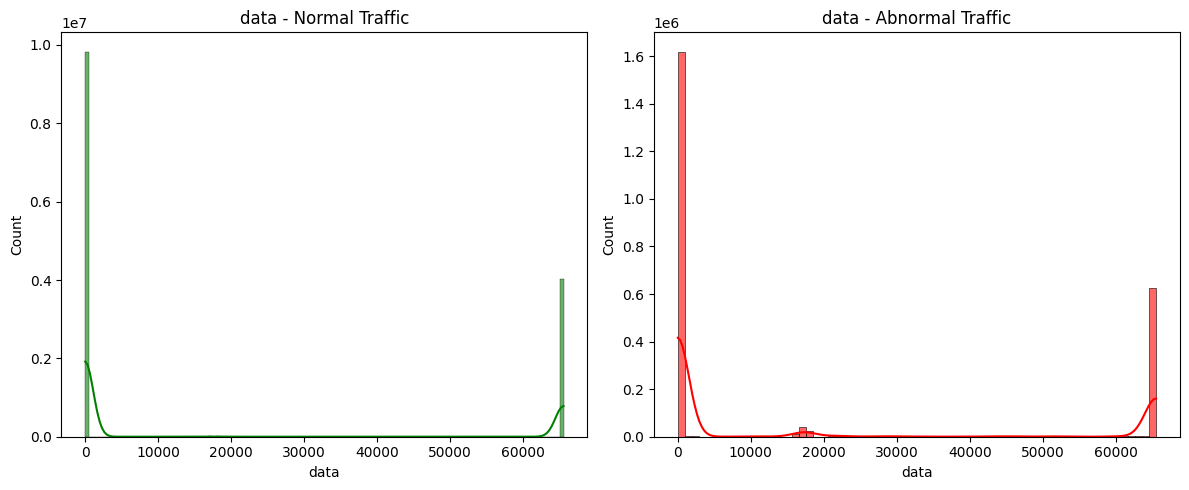

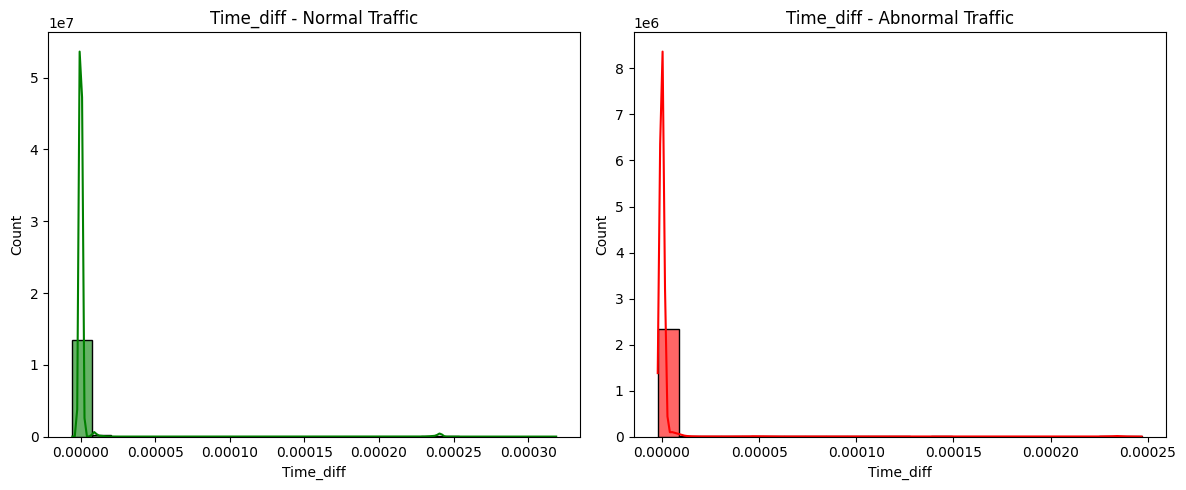

In [ ]:
#############################################
# DATA EXPLORATION v2.0 (2025-03-12)
# ENHANCEMENTS: Added EKANS-specific analysis with function code sequence,
# register access patterns, and timing analysis for improved GAN simulation.
#############################################

#############################################
# 1. GENERAL EXPLORATION
#############################################

# Display basic dataset information
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("\n======== GENERAL DATASET EXPLORATION ========")
print("\nDataset Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())
print("\nDataset Info:")
display(df.info())
print("\nSummary Statistics:")
display(df.describe())

# Memory usage check
def mem_usage(pandas_obj):
    if isinstance(pandas_obj, pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else:  # Series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2  # convert bytes to megabytes
    return f"{usage_mb:.2f} MB"

print(f"\nDataset memory usage: {mem_usage(df)}")

# Check for missing values
print("\nMissing Values:")
display(df.isnull().sum())

# Visualize data distributions
plt.figure(figsize=(15, 8))
plt.suptitle('Electra Dataset Feature Distributions', fontsize=16)
# Select numeric columns for visualization
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()[:6]  # First 6 for clarity
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Correlation analysis for numeric features
plt.figure(figsize=(12, 10))
corr = df.select_dtypes(include=['int64', 'float64']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Analyze target variable
label_col = None
for potential_label in ['label', 'attack', 'class', 'target']:
    if potential_label in df.columns:
        label_col = potential_label
        break
if label_col:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=label_col, data=df)
    plt.title(f'Distribution of {label_col}')
    plt.show()
    # Calculate class imbalance
    class_counts = df[label_col].value_counts()
    print(f"\n{label_col} distribution:")
    display(class_counts)
    print(f"Imbalance ratio: {class_counts.max() / class_counts.min():.2f}:1")

#############################################
# 2. SPECIFIC EXPLORATION FOR EKANS SIMULATION
#############################################

print("\n======== MODBUS & ICS TRAFFIC PATTERNS FOR EKANS SIMULATION ========")

# Identify Modbus-specific columns
modbus_cols = [col for col in df.columns if 'modbus' in col.lower() or 'function' in col.lower()]
if modbus_cols:
    print(f"\nModbus-related columns: {modbus_cols}")
    # Analyze distribution of function codes if present
    for col in modbus_cols:
        plt.figure(figsize=(8, 6))
        df[col].value_counts().sort_index().plot(kind='bar')
        plt.title(f'Distribution of {col}')
        plt.tight_layout()
        plt.show()

# Analyze function code sequences (important for EKANS behavior simulation)
if 'function_code' in df.columns:
    print("\n--- Function Code Analysis (EKANS targets Modbus commands 0x05, 0x06, 0x0F) ---")

    # Check presence of EKANS-targeted function codes
    ekans_targets = [5, 6, 15]  # 0x05, 0x06, 0x0F
    for code in ekans_targets:
        code_count = len(df[df['function_code'] == code])
        print(f"Function code {code} (0x{code:02X}) count: {code_count} ({code_count/len(df)*100:.2f}%)")

    # Look at sequences of commands
    df['next_function'] = df['function_code'].shift(-1)
    sequence_counts = df.groupby(['function_code', 'next_function']).size().reset_index()
    sequence_counts.columns = ['Current Function', 'Next Function', 'Count']
    sequence_counts = sequence_counts.sort_values('Count', ascending=False)

    print("\nTop 10 Modbus command sequences:")
    display(sequence_counts.head(10))

    # Visualize the transitions as a heatmap if there are not too many unique functions
    num_funcs = df['function_code'].nunique()
    if num_funcs <= 20:  # Only create heatmap if reasonable number of unique values
        pivot_seq = sequence_counts.pivot(index='Current Function',
                                        columns='Next Function',
                                        values='Count').fillna(0)
        plt.figure(figsize=(10, 8))
        sns.heatmap(pivot_seq, annot=False, cmap='viridis')
        plt.title('Modbus Function Code Transition Patterns')
        plt.tight_layout()
        plt.show()

# Analyze register access patterns (EKANS targets specific registers)
print("\n--- Register Access Analysis (EKANS manipulates specific registers) ---")
register_cols = [col for col in df.columns if 'register' in col.lower() or 'address' in col.lower()]
if register_cols:
    for col in register_cols:
        # Top accessed registers
        plt.figure(figsize=(12, 6))
        top_registers = df[col].value_counts().head(20)
        sns.barplot(x=top_registers.index, y=top_registers.values)
        plt.title(f'Top 20 Accessed Registers/Addresses ({col})')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

        # Check if there's a relationship between function codes and registers
        if 'function_code' in df.columns:
            # Create a heatmap of function code vs register access if not too many unique values
            if df[col].nunique() <= 30:  # Limit for readability
                plt.figure(figsize=(14, 8))
                heatmap_data = pd.crosstab(df['function_code'], df[col])
                sns.heatmap(np.log1p(heatmap_data), cmap='viridis')  # log scale to handle wide value ranges
                plt.title(f'Function Code vs Register Access Patterns (log scale)')
                plt.tight_layout()
                plt.show()

# Analyze timing patterns (EKANS uses specific timing patterns)
print("\n--- Timing Pattern Analysis (EKANS uses specific timing patterns) ---")
timestamp_cols = [col for col in df.columns if 'time' in col.lower() or 'timestamp' in col.lower()]
if timestamp_cols:
    # Convert to datetime if needed
    for col in timestamp_cols:
        if df[col].dtype != 'datetime64[ns]':
            try:
                df[col] = pd.to_datetime(df[col])
                print(f"Converted {col} to datetime")
            except:
                print(f"Could not convert {col} to datetime")

    # If conversion successful, analyze timing patterns
    for col in timestamp_cols:
        if df[col].dtype == 'datetime64[ns]':
            # Get time differences between consecutive packets
            df[f'{col}_diff'] = df[col].diff().dt.total_seconds()

            # Visualize timing distribution
            plt.figure(figsize=(10, 6))
            sns.histplot(df[f'{col}_diff'].dropna(), bins=50, kde=True)
            plt.title(f'Time Intervals Between Packets ({col})')
            plt.xlabel('Seconds')
            plt.xlim(0, df[f'{col}_diff'].quantile(0.95))  # Limit to 95th percentile for clarity
            plt.show()

# Normal vs. abnormal traffic statistical profiles (baseline for EKANS simulation)
if label_col:
    print("\n--- Normal vs. Abnormal Traffic Profiles (Baseline for EKANS Simulation) ---")
    # Create normal and abnormal datasets
    normal_label = df[label_col].value_counts().index[0]  # Assuming most common is normal
    normal_df = df[df[label_col] == normal_label]
    abnormal_df = df[df[label_col] != normal_label]

    print(f"Normal traffic: {len(normal_df)} records ({len(normal_df)/len(df)*100:.2f}%)")
    print(f"Abnormal traffic: {len(abnormal_df)} records ({len(abnormal_df)/len(df)*100:.2f}%)")

    # Feature distributions by class for key numerical features
    # Select top 6 features with highest variance for visualization
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    num_cols = [col for col in num_cols if col != label_col]

    if len(num_cols) > 6:
        top_variance_cols = df[num_cols].var().sort_values(ascending=False).head(6).index.tolist()
    else:
        top_variance_cols = num_cols

    for col in top_variance_cols:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(normal_df[col], kde=True, color='green', alpha=0.6)
        plt.title(f'{col} - Normal Traffic')

        plt.subplot(1, 2, 2)
        if len(abnormal_df) > 0:
            sns.histplot(abnormal_df[col], kde=True, color='red', alpha=0.6)
            plt.title(f'{col} - Abnormal Traffic')

        plt.tight_layout()
        plt.show()

    # Look for potential command injection signatures (EKANS targets EMERGENCY_STOP)
    if 'command' in df.columns:
        print("\n--- Command Analysis (EKANS injects unauthorized EMERGENCY_STOP) ---")
        command_counts = df['command'].value_counts()
        plt.figure(figsize=(12, 6))
        sns.barplot(x=command_counts.index[:20], y=command_counts.values[:20])
        plt.title('Top 20 Commands')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # Check if any emergency commands exist
        emergency_cmds = [cmd for cmd in df['command'].unique() if 'emerg' in str(cmd).lower()]
        if emergency_cmds:
            print(f"Emergency-related commands found: {emergency_cmds}")
            for cmd in emergency_cmds:
                print(f"Command '{cmd}' occurrences: {len(df[df['command'] == cmd])}")

# **2. Data Preprocessing**

In [ ]:
# Data Cleaning v1.0 (2025-03-13)
# ENHANCEMENT: Handle missing values and duplicates

# Check for and handle missing values
print("Missing values before cleaning:")
print(df.isnull().sum())

# Fill missing values if any (using appropriate strategies)
# For numerical columns: use median for skewed data
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

# For categorical columns: use mode
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])

# Check for and remove duplicates
duplicate_count = df.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")
if duplicate_count > 0:
    df = df.drop_duplicates()
    print(f"Removed {duplicate_count} duplicate rows")

print("\nMissing values after cleaning:")
print(df.isnull().sum())
print(f"Dataset shape after cleaning: {df.shape}")

Missing values before cleaning:
Time       0
smac       0
dmac       0
sip        0
dip        0
request    0
fc         0
error      0
address    0
data       0
label      0
dtype: int64
Duplicate rows: 0

Missing values after cleaning:
Time       0
smac       0
dmac       0
sip        0
dip        0
request    0
fc         0
error      0
address    0
data       0
label      0
dtype: int64
Dataset shape after cleaning: (16289277, 11)


In [ ]:
# Feature Conversion v1.0 (2025-03-13)
# ENHANCEMENT: Convert MAC and IP addresses to numerical features

import ipaddress
import re
import numpy as np

# Function to convert MAC address to numerical value
def mac_to_int(mac):
    try:
        # Remove separators and convert to integer
        return int(mac.replace(':', '').replace('-', ''), 16)
    except:
        return 0  # Default for invalid MAC

# Function to convert IP address to numerical value
def ip_to_int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except:
        return 0  # Default for invalid IP

# Make a copy of the original columns for tracking
df['smac_original'] = df['smac']
df['dmac_original'] = df['dmac']
df['sip_original'] = df['sip']
df['dip_original'] = df['dip']

# Convert MAC addresses to numerical features
print("Converting MAC addresses...")
df['smac_num'] = df['smac'].apply(mac_to_int)
df['dmac_num'] = df['dmac'].apply(mac_to_int)

# Convert IP addresses to numerical features
print("Converting IP addresses...")
df['sip_num'] = df['sip'].apply(ip_to_int)
df['dip_num'] = df['dip'].apply(ip_to_int)

# Drop the original string columns to save memory (keep if needed for reference)
df = df.drop(['smac', 'dmac', 'sip', 'dip'], axis=1)

# Show the first few rows with the converted features
print("\nDataset after MAC/IP conversion:")
print(df[['smac_num', 'dmac_num', 'sip_num', 'dip_num']].head())

Converting MAC addresses...
Converting IP addresses...

Dataset after MAC/IP conversion:
        smac_num       dmac_num    sip_num    dip_num
0   116429766939  8796755308618  172369459  172369463
1  8796755308618    62493154648  172369459  172369463
2   116429766939    62493154972  172369459  172369464
3    62493154648  8796755308618  172369463  172369459
4    62493154648  8796755308618  172369463  172369459


In [ ]:
# Optimized Sequence-based Feature Engineering v2.1
# ENHANCEMENT: Vectorized operations instead of slow rolling windows

print("Creating optimized sequence-based features...")

# Use a smaller sample for testing if needed
df = df.sample(n=1000000, random_state=42)  # Uncomment for testing

# Sort by time to ensure proper sequence
df = df.sort_values('Time')

# 1. Create lag features using shift (much faster than rolling)
window_size = 5  # Reduced from 10 to improve performance

# Create lag features for most important fields only
for lag in range(1, window_size + 1):
    df[f'fc_lag_{lag}'] = df['fc'].shift(lag)
    df[f'address_lag_{lag}'] = df['address'].shift(lag)

# 2. Create deltas for important fields only (using vectorized operations)
df['time_delta_1'] = df['Time'].diff(1)
df['fc_delta_1'] = df['fc'].diff(1)
df['address_delta_1'] = df['address'].diff(1)

# 3. Drop NaN values created by lag operations
print(f"Rows before dropping NaNs: {df.shape[0]}")
df = df.dropna()
print(f"Rows after dropping NaNs: {df.shape[0]}")

print("\nDataset with sequence features:")
sequence_cols = [col for col in df.columns if 'lag' in col or 'delta' in col]
print(df[sequence_cols[:5]].head())

Creating optimized sequence-based features...
Rows before dropping NaNs: 1000000
Rows after dropping NaNs: 999995

Dataset with sequence features:
     fc_lag_1  address_lag_1  fc_lag_2  address_lag_2  fc_lag_3
141       3.0           44.0       3.0           25.0       3.0
203       3.0            3.0       3.0           44.0       3.0
145       3.0           65.0       3.0            3.0       3.0
186       3.0            7.0       3.0           65.0       3.0
272       3.0           48.0       3.0            7.0       3.0


In [ ]:
# One-Hot-Encoding v3.0 (2025-03-13)
# ENHANCEMENT: Convert categorical variables to one-hot encoded features

from sklearn.preprocessing import OneHotEncoder


# Identify categorical columns (exclude original MAC/IP columns)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
original_cols = ['smac_original', 'dmac_original', 'sip_original', 'dip_original']
categorical_cols = [col for col in categorical_cols if col not in original_cols]

# If label is categorical, separate it before encoding
if 'label' in categorical_cols:
    categorical_cols.remove('label')
    label_col = 'label'
else:
    label_col = None

# Apply one-hot encoding if categorical columns exist
if categorical_cols:
    # Initialize encoder
    # sparse is replaced with sparse_output=False
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # Fit and transform categorical columns
    encoded_data = encoder.fit_transform(df[categorical_cols])

    # Create DataFrame with encoded columns
    encoded_df = pd.DataFrame(
        encoded_data,
        columns=encoder.get_feature_names_out(categorical_cols)
    )

    # Join encoded columns back to original DataFrame
    df = df.drop(categorical_cols, axis=1).reset_index(drop=True)
    encoded_df = encoded_df.reset_index(drop=True)
    df = pd.concat([df, encoded_df], axis=1)

    print(f"Added {encoded_df.shape[1]} one-hot encoded features")
else:
    print("No categorical columns to encode after previous transformations")

print(f"Dataset shape after one-hot encoding: {df.shape}")

No categorical columns to encode after previous transformations
Dataset shape after one-hot encoding: (999995, 28)


In [ ]:
# Outlier Analysis v3.0 (2025-03-13)
# ENHANCEMENT: Identify and handle anomalies in the dataset

import numpy as np
from scipy import stats

# Identify numerical columns for outlier detection
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if label_col and label_col in numeric_cols:
    numeric_cols.remove(label_col)

# Calculate Z-scores for numerical features
print("Performing outlier analysis...")
z_scores = pd.DataFrame()
for col in numeric_cols:
    z_scores[col] = stats.zscore(df[col], nan_policy='omit')

# Count outliers using Z-score > 3 as threshold
outlier_counts = (np.abs(z_scores) > 3).sum()
print("\nOutlier counts per column (Z-score > 3):")
print(outlier_counts.sort_values(ascending=False).head(10))  # Top 10 columns with most outliers

# Identify rows with extreme outliers across multiple columns
extreme_outlier_rows = (np.abs(z_scores) > 5).sum(axis=1)
print(f"\nRows with outliers in multiple columns (Z-score > 5): {(extreme_outlier_rows > 3).sum()}")

# Option 1: Cap outliers (winsorization) - less aggressive
for col in numeric_cols:
    # Get the upper and lower limits
    upper_limit = df[col].mean() + 3 * df[col].std()
    lower_limit = df[col].mean() - 3 * df[col].std()

    # Cap values
    outlier_count = ((df[col] > upper_limit) | (df[col] < lower_limit)).sum()
    if outlier_count > 0:
        df[col] = df[col].clip(lower=lower_limit, upper=upper_limit)
        print(f"Capped {outlier_count} outliers in column {col}")
# Comment: Capping using mean ± 3σ before RobustScaler ensures extreme outliers are controlled,
# while RobustScaler (median/IQR) handles remaining distribution scaling.
print(f"\nDataset shape after outlier handling: {df.shape}")

Performing outlier analysis...

Outlier counts per column (Z-score > 3):
dmac_num        89611
smac_num        57142
dip_num         48369
request         17162
sip_num          2543
time_delta_1     2176
fc               1332
fc_lag_5         1332
fc_lag_3         1332
fc_lag_4         1332
dtype: int64

Rows with outliers in multiple columns (Z-score > 5): 417
Capped 17162 outliers in column request
Capped 1332 outliers in column fc
Capped 242 outliers in column error
Capped 375 outliers in column address
Capped 57142 outliers in column smac_num
Capped 89611 outliers in column dmac_num
Capped 2543 outliers in column sip_num
Capped 48369 outliers in column dip_num
Capped 1332 outliers in column fc_lag_1
Capped 375 outliers in column address_lag_1
Capped 1332 outliers in column fc_lag_2
Capped 375 outliers in column address_lag_2
Capped 1332 outliers in column fc_lag_3
Capped 375 outliers in column address_lag_3
Capped 1332 outliers in column fc_lag_4
Capped 375 outliers in column addr

In [ ]:
# Feature Scaling v3.0 (2025-03-13)
# ENHANCEMENT: Normalize or standardize features for model training

from sklearn.preprocessing import StandardScaler, RobustScaler

# Identify numerical columns for scaling
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if label_col and label_col in numeric_cols:
    numeric_cols.remove(label_col)

print(f"Scaling {len(numeric_cols)} numerical features")

# Option 1: Standard Scaler (mean=0, std=1)
# standard_scaler = StandardScaler()
# df[numeric_cols] = standard_scaler.fit_transform(df[numeric_cols])

# Option 2: Robust Scaler (more resilient to outliers)
robust_scaler = RobustScaler()
df[numeric_cols] = robust_scaler.fit_transform(df[numeric_cols])

# Verify scaling results
print("\nStatistics after scaling:")
print(df[numeric_cols].describe().loc[['mean', 'std', 'min', 'max']].transpose().head())

# Save the preprocessed data
print("\nSaving preprocessed dataset...")
# Uncomment when ready to save
# df.to_csv('preprocessed_electra_data.csv', index=False)

print(f"Final preprocessed dataset shape: {df.shape}")

Scaling 23 numerical features

Statistics after scaling:
             mean       std       min         max
Time     0.007516  0.575476 -0.980000    0.998531
request  0.006981  0.052832  0.000000    0.406788
fc       0.012612  0.428357 -3.000000   11.423310
error    0.000422  0.026897  0.000000    1.723203
address  0.135047  2.255216 -0.972222  104.372812

Saving preprocessed dataset...
Final preprocessed dataset shape: (999995, 28)


In [ ]:
# Class Imbalance Handling v2.0 (2025-04-23)
# ENHANCEMENT: Synthetic Minority Oversampling Technique for balanced representation

print("Implementing advanced class balancing techniques...")

!pip install imbalanced-learn

from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop('label', axis=1)
y = df['label']

# ----> Drop the original MAC and IP columns before applying SMOTE
X = X.drop(columns=['smac_original', 'dmac_original', 'sip_original', 'dip_original'], errors='ignore') # errors='ignore' to prevent error if columns are already dropped


# Analyze initial class distribution
print("\nOriginal class distribution:")
class_counts = y.value_counts()
for label, count in class_counts.items():
    print(f"  {label}: {count} ({count/len(y)*100:.2f}%)")

# Calculate imbalance ratio
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"Original imbalance ratio: {imbalance_ratio:.2f}:1")

# Apply SMOTE to balance classes
print("\nApplying SMOTE to generate synthetic samples for minority classes...")
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the new distribution
print("\nClass distribution after SMOTE:")
new_class_counts = pd.Series(y_resampled).value_counts()
for label, count in new_class_counts.items():
    print(f"  {label}: {count} ({count/len(y_resampled)*100:.2f}%)")

# Calculate new imbalance ratio
new_imbalance_ratio = new_class_counts.max() / new_class_counts.min()
print(f"New imbalance ratio: {new_imbalance_ratio:.2f}:1")

# Update the original data with the balanced dataset
print(f"\nExpanded dataset from {len(X)} to {len(X_resampled)} samples")
X = X_resampled
y = y_resampled

# Optional: Verify no zero-variance features remain
variances = X.var()
zero_var_features = variances[variances < 1e-5]
if len(zero_var_features) > 0:
    print(f"Warning: {len(zero_var_features)} features still have near-zero variance")
    print(f"Consider additional feature engineering for: {zero_var_features.index.tolist()}")
else:
    print("✓ All features now have sufficient variance for robust GAN training")

# Continue with dataset splitting using the balanced data
print("\nProceeding to split the balanced dataset...")

Implementing advanced class balancing techniques...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.4 MB/s eta 0:00:00

Original class distribution:
  NORMAL: 853242 (85.32%)
  MITM_UNALTERED: 94718 (9.47%)
  READ_ATTACK: 48422 (4.84%)
  RECOGNITION_ATTACK: 1863 (0.19%)
  RESPONSE_ATTACK: 1056 (0.11%)
  WRITE_ATTACK: 555 (0.06%)
  REPLAY_ATTACK: 72 (0.01%)
  FORCE_ERROR_ATTACK: 67 (0.01%)
Original imbalance ratio: 12734.96:1

Applying SMOTE to generate synthetic samples for minority classes...

Class distribution after SMOTE:
  NORMAL: 853242 (12.50%)
  MITM_UNALTERED: 853242 (12.50%)
  RESPONSE_ATTACK: 853242 (12.50%)
  FORCE_ERROR_ATTACK: 853242 (12.50%)
  RECOGNITION_ATTACK: 853242 (12.50%)
  READ_ATTACK: 853242 (12.50%)
  REPLAY_ATTACK: 853242 (12.50%)
  WRITE_ATTACK: 853242 (12.50%)
New imbalance ratio: 1.00:1

Expanded dataset from 999995 to 6825936 samples
✓ All features now have sufficient variance for robust GAN training

Proceeding to split the balanced dataset..

In [ ]:
# Dataset Splitting v2.0 (2025-04-24)
# ENHANCEMENT: Split SMOTE-balanced data with proper file naming

from sklearn.model_selection import train_test_split
import pandas as pd
import os

# Ensure output directories exist
os.makedirs('/content/drive/MyDrive/Datasets', exist_ok=True)

print("Splitting SMOTE-balanced dataset...")

# If X and y contain your SMOTE-balanced dataset
# Make sure X is your feature dataframe and y is your labels Series

# Create stratified train-test-validation split
# Note: With SMOTE-balanced data, we still use stratification to maintain equal class distribution
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Check class distribution in splits
print("\nClass distribution in train set:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in validation set:")
print(y_val.value_counts(normalize=True))
print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))

# Save the balanced splits with clear naming
# Standard file paths (these are what the cGAN code expects)
X_train.to_csv('/content/drive/MyDrive/Datasets/X_train.csv', index=False)
X_val.to_csv('/content/drive/MyDrive/Datasets/X_val.csv', index=False)
X_test.to_csv('/content/drive/MyDrive/Datasets/X_test.csv', index=False)
y_train.to_csv('/content/drive/MyDrive/Datasets/y_train.csv', index=False)
y_val.to_csv('/content/drive/MyDrive/Datasets/y_val.csv', index=False)
y_test.to_csv('/content/drive/MyDrive/Datasets/y_test.csv', index=False)

# Also save with explicit "balanced" naming for clarity
X_train.to_csv('/content/drive/MyDrive/Datasets/X_train_balanced.csv', index=False)
X_val.to_csv('/content/drive/MyDrive/Datasets/X_val_balanced.csv', index=False)
X_test.to_csv('/content/drive/MyDrive/Datasets/X_test_balanced.csv', index=False)
y_train.to_csv('/content/drive/MyDrive/Datasets/y_train_balanced.csv', index=False)
y_val.to_csv('/content/drive/MyDrive/Datasets/y_val_balanced.csv', index=False)
y_test.to_csv('/content/drive/MyDrive/Datasets/y_test_balanced.csv', index=False)

print("Dataset splits saved successfully to Google Drive")
print("Note: Files were saved both with standard names (X_train.csv) and explicit balanced names (X_train_balanced.csv)")

Splitting SMOTE-balanced dataset...
Training set: 4778155 samples (70.0%)
Validation set: 1023890 samples (15.0%)
Test set: 1023891 samples (15.0%)

Class distribution in train set:
label
FORCE_ERROR_ATTACK    0.125
REPLAY_ATTACK         0.125
MITM_UNALTERED        0.125
RECOGNITION_ATTACK    0.125
RESPONSE_ATTACK       0.125
WRITE_ATTACK          0.125
READ_ATTACK           0.125
NORMAL                0.125
Name: proportion, dtype: float64

Class distribution in validation set:
label
NORMAL                0.125001
READ_ATTACK           0.125001
RESPONSE_ATTACK       0.125000
RECOGNITION_ATTACK    0.125000
FORCE_ERROR_ATTACK    0.125000
MITM_UNALTERED        0.125000
WRITE_ATTACK          0.125000
REPLAY_ATTACK         0.125000
Name: proportion, dtype: float64

Class distribution in test set:
label
RESPONSE_ATTACK       0.125001
RECOGNITION_ATTACK    0.125001
WRITE_ATTACK          0.125001
MITM_UNALTERED        0.125000
REPLAY_ATTACK         0.125000
FORCE_ERROR_ATTACK    0.125000
READ

Check Point

In [ ]:
# Save preprocessed full dataset
df.to_csv('/content/drive/MyDrive/Datasets/preprocessed_electra_balanced.csv', index=False)

# Save SMOTE-balanced splits with clear naming
print("Saving SMOTE-balanced dataset splits...")

# Standard filenames - these are what the cGAN code expects by default
X_train.to_csv('/content/drive/MyDrive/Datasets/X_train.csv', index=False)
X_val.to_csv('/content/drive/MyDrive/Datasets/X_val.csv', index=False)
X_test.to_csv('/content/drive/MyDrive/Datasets/X_test.csv', index=False)
y_train.to_csv('/content/drive/MyDrive/Datasets/y_train.csv', index=False)
y_val.to_csv('/content/drive/MyDrive/Datasets/y_val.csv', index=False)
y_test.to_csv('/content/drive/MyDrive/Datasets/y_test.csv', index=False)

# Also save with explicit "balanced" naming for clarity and safety
X_train.to_csv('/content/drive/MyDrive/Datasets/X_train_balanced.csv', index=False)
X_val.to_csv('/content/drive/MyDrive/Datasets/X_val_balanced.csv', index=False)
X_test.to_csv('/content/drive/MyDrive/Datasets/X_test_balanced.csv', index=False)
y_train.to_csv('/content/drive/MyDrive/Datasets/y_train_balanced.csv', index=False)
y_val.to_csv('/content/drive/MyDrive/Datasets/y_val_balanced.csv', index=False)
y_test.to_csv('/content/drive/MyDrive/Datasets/y_test_balanced.csv', index=False)

print("All SMOTE-balanced data saved successfully to Google Drive")
print("Note: Files were saved with both standard names and explicit balanced names for compatibility")

Saving SMOTE-balanced dataset splits...
All SMOTE-balanced data saved successfully to Google Drive
Note: Files were saved with both standard names and explicit balanced names for compatibility


In [3]:
# Load preprocessed SMOTE-balanced data
print("Loading SMOTE-balanced dataset...")

# Try loading balanced-specific files first, fall back to standard names if needed
try:
    X_train = pd.read_csv('/content/drive/MyDrive/Datasets/X_train_balanced.csv')
    X_val = pd.read_csv('/content/drive/MyDrive/Datasets/X_val_balanced.csv')
    X_test = pd.read_csv('/content/drive/MyDrive/Datasets/X_test_balanced.csv')
    y_train = pd.read_csv('/content/drive/MyDrive/Datasets/y_train_balanced.csv').squeeze("columns")
    y_val = pd.read_csv('/content/drive/MyDrive/Datasets/y_val_balanced.csv').squeeze("columns")
    y_test = pd.read_csv('/content/drive/MyDrive/Datasets/y_test_balanced.csv').squeeze("columns")
    print("✓ Successfully loaded explicit SMOTE-balanced dataset files")
except FileNotFoundError:
    # Fall back to standard filenames
    X_train = pd.read_csv('/content/drive/MyDrive/Datasets/X_train.csv')
    X_val = pd.read_csv('/content/drive/MyDrive/Datasets/X_val.csv')
    X_test = pd.read_csv('/content/drive/MyDrive/Datasets/X_test.csv')
    y_train = pd.read_csv('/content/drive/MyDrive/Datasets/y_train.csv').squeeze("columns")
    y_val = pd.read_csv('/content/drive/MyDrive/Datasets/y_val.csv').squeeze("columns")
    y_test = pd.read_csv('/content/drive/MyDrive/Datasets/y_test.csv').squeeze("columns")
    print("Using standard dataset files (may or may not be balanced)")

# Check balance in loaded data
print("\nClass distribution in loaded train set:")
class_counts = y_train.value_counts()
max_count = class_counts.max()
min_count = class_counts.min()
imbalance_ratio = max_count / min_count

for label, count in class_counts.items():
    print(f"  {label}: {count} ({count/len(y_train)*100:.2f}%)")

print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 2:
    print("⚠️ Warning: Dataset shows class imbalance (ratio > 2:1)")
else:
    print("✓ Dataset is well-balanced (imbalance ratio < 2:1)")

Loading SMOTE-balanced dataset...
✓ Successfully loaded explicit SMOTE-balanced dataset files

Class distribution in loaded train set:
  FORCE_ERROR_ATTACK: 597270 (12.50%)
  REPLAY_ATTACK: 597270 (12.50%)
  MITM_UNALTERED: 597270 (12.50%)
  RECOGNITION_ATTACK: 597269 (12.50%)
  RESPONSE_ATTACK: 597269 (12.50%)
  WRITE_ATTACK: 597269 (12.50%)
  READ_ATTACK: 597269 (12.50%)
  NORMAL: 597269 (12.50%)
Imbalance ratio: 1.00:1
✓ Dataset is well-balanced (imbalance ratio < 2:1)


# **3. Model Training**

**3.1 cGANs**

In [4]:
# cGAN for EKANS Simulation v4.0 – Enhanced with Multi-Phase EKANS Conditioning
# ------------------------------------------------------------------------------
import os, json, math, time
import numpy as np, pandas as pd, joblib
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, backend as K
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from scipy.spatial.distance import jensenshannon
from sklearn.manifold import TSNE
from tqdm import tqdm
from datetime import datetime

# --------------------------------------------
# SECTION 1: CONFIGURATION AND DEPENDENCIES
# --------------------------------------------
class ExperimentConfig:
    def __init__(self, **kwargs):
        # GAN & generation parameters (from v3.7.1)
        self.latent_dim                = kwargs.get('latent_dim', 64)
        self.batch_size                = kwargs.get('batch_size', 256)
        self.epochs                    = kwargs.get('epochs', 150)
        self.n_critic                  = kwargs.get('n_critic', 5)

        # Generator hyperparameters
        self.g_learning_rate           = kwargs.get('g_learning_rate', 1e-4)
        self.g_beta1                   = kwargs.get('g_beta1', 0.5)
        self.g_beta2                   = kwargs.get('g_beta2', 0.9)
        self.g_dropout                 = kwargs.get('g_dropout', 0.2)
        self.label_smoothing_real      = kwargs.get('label_smoothing_real', 0.9)
        self.label_smoothing_fake      = kwargs.get('label_smoothing_fake', 0.1)

        # Critic hyperparameters
        self.c_learning_rate           = kwargs.get('c_learning_rate', 1e-4)
        self.c_beta1                   = kwargs.get('c_beta1', 0.5)
        self.c_beta2                   = kwargs.get('c_beta2', 0.9)
        self.c_dropout                 = kwargs.get('c_dropout', 0.3)
        self.gp_weight                 = kwargs.get('gp_weight', 10.0)

        # JSD monitoring and early stopping
        self.jsd_threshold             = kwargs.get('jsd_threshold', 0.15)
        self.enable_jsd_monitoring     = kwargs.get('enable_jsd_monitoring', True)
        self.monitoring_interval       = kwargs.get('monitoring_interval', 1)
        self.jsd_plateau_threshold     = kwargs.get('jsd_plateau_threshold', 0.01)
        self.plateau_patience          = kwargs.get('plateau_patience', 5)
        self.early_stopping_patience   = kwargs.get('early_stopping_patience', 10)
        self.save_interval             = kwargs.get('save_interval', 20)

        # EKANS simulation parameters
        self.target_samples            = kwargs.get('target_samples', 115000)
        self.noise_level               = kwargs.get('noise_level', 0.1)
        self.reg_weight                = kwargs.get('reg_weight', 0.01)
        self.max_regeneration_attempts = kwargs.get('max_regeneration_attempts', 3)

        # Validation & contamination
        self.contamination             = kwargs.get('contamination', 0.12)
        self.min_valid_sample_pct      = kwargs.get('min_valid_sample_pct', 0.5)

        # ---- NEW: EKANS Phase configurations ----
        self.include_phases            = kwargs.get('include_phases', True)

        # Get attack class names
        try:
            # Try to read class names from the dataset
            try:
                # First try the balanced dataset with phases
                y_train = pd.read_csv(os.path.join(kwargs.get('data_dir', '/content/drive/MyDrive/Datasets/'),
                                              'y_train_balanced_with_phases.csv')).squeeze()
                # Split combined labels to get attack classes
                self.class_names = sorted(y_train.apply(lambda x: x.split('_')[0] if '_' in x else x).unique().tolist())
                print(f"Using {len(self.class_names)} attack classes from phase-labeled dataset: {self.class_names}")
            except:
                # Fall back to standard balanced dataset
                y_train = pd.read_csv(os.path.join(kwargs.get('data_dir', '/content/drive/MyDrive/Datasets/'),
                                              'y_train_balanced.csv')).squeeze()
                self.class_names = sorted(y_train.unique().tolist())
                print(f"Using {len(self.class_names)} attack classes from balanced dataset: {self.class_names}")
        except:
            # Fall back to default class names
            self.class_names = kwargs.get('class_names', ['NORMAL', 'MITM_UNALTERED', 'READ_ATTACK',
                                                        'RECOGNITION_ATTACK', 'RESPONSE_ATTACK',
                                                        'WRITE_ATTACK', 'REPLAY_ATTACK', 'FORCE_ERROR_ATTACK'])
            print(f"Using default attack class names: {self.class_names}")

        # Get phase names if available
        try:
            # Try to read phase names from the label components file
            label_components = pd.read_csv(os.path.join(kwargs.get('data_dir', '/content/drive/MyDrive/Datasets/'),
                                                 'label_components_balanced.csv'))
            self.phase_names = sorted(label_components['ekans_phase'].unique().tolist())
            print(f"Using {len(self.phase_names)} EKANS phases from dataset: {self.phase_names}")
        except:
            # Fall back to default phase names
            self.phase_names = kwargs.get('phase_names', ['NOT_EKANS', 'EKANS_RECON', 'EKANS_PROCESS_KILL', 'EKANS_ENCRYPT'])
            print(f"Using default EKANS phase names: {self.phase_names}")

        # Phase templates & labels: load defaults then override with external file if present
        self.phase_templates = self._load_phase_templates()

        # Paths
        self.data_dir     = kwargs.get('data_dir', '/content/drive/MyDrive/Datasets/')
        self.model_dir    = kwargs.get('model_dir', '/content/drive/MyDrive/Models')
        self.results_dir  = kwargs.get('results_dir', '/content/drive/MyDrive/Results')
        self.mapping_path = os.path.join(self.results_dir, 'mitre_mapping.json')

        # Output files
        self.cleaned_dataset_path = os.path.join(self.data_dir, 'ekans_synthetic_multi_phase_v4.0.csv')
        self.metadata_log         = os.path.join(self.results_dir, 'ekans_phase_metadata.json')

        # Ensure directories exist
        for p in (self.data_dir, self.model_dir, self.results_dir):
            os.makedirs(p, exist_ok=True)

    def _load_phase_templates(self):
        # Default phase configurations for EKANS
        templates = {
            'EKANS_RECON': {
                'fc_options': [1, 2, 3, 4],           # Read function codes
                'request': 1,                         # Request bit set
                'process_kill_count': 0,              # No processes killed during recon
                'registry_write_attempts': 0,         # No registry writes during recon
                'file_encryption_flag': 0,            # No encryption during recon
                'time_diff_range': (0, 300),          # Timing pattern (slower)
                'address_range': [1, 10, 100, 1000],  # Typical scanning addresses
                'address_probs': [0.4, 0.3, 0.2, 0.1] # More focus on lower addresses
            },
            'EKANS_PROCESS_KILL': {
                'fc_options': [5, 6, 15, 16],        # Write function codes
                'process_kill_range': (1, 8),        # Process kill counts
                'registry_write_range': (1, 5),      # Registry write attempts
                'file_encryption_flag': 0,           # No encryption during process kill
                'time_diff_range': (300, 600),       # Timing pattern (moderate)
                'address_range': [100, 101, 102, 103, 104, 105]  # Process control addresses
            },
            'EKANS_ENCRYPT': {
                'fc': 16,                           # Write multiple registers
                'data_range': (60000, 65535),       # High data values for encryption
                'process_kill_range': (3, 8),       # May still kill processes
                'registry_write_range': (2, 5),     # Registry modification
                'file_encryption_flag': 1,          # Encryption flag set
                'time_diff_range': (0, 60),         # Fast writing pattern
                'address_range': [1, 35, 53],       # Typical encryption targets
                'address_probs': [0.5, 0.3, 0.2]    # Address distribution
            },
            'NOT_EKANS': { # Default template for non-EKANS traffic
                'fc':3,
                'request':1,
                'process_kill_count':0,
                'registry_write_attempts':0,
                'file_encryption_flag':0,
                'time_since_last_write_range':(0,300),
                'address_range':[1,10,100,1000,10000],
                'address_probs':[0.3,0.2,0.2,0.15,0.15]
            }
        }

        # Override with external file if available
        cfg_path = os.path.join('configs','phase_patterns.json')
        try:
            if os.path.exists(cfg_path):
                with open(cfg_path) as f:
                    custom = json.load(f)
                for phase,data in custom.items():
                    templates[phase] = {**templates.get(phase,{}), **data}
        except Exception:
            print(f"Warning: could not load phase templates from {cfg_path}, using defaults.")
        return templates

# --------------------------------------------
# SECTION 2: MITRE ANNOTATOR WITH PHASE SUPPORT
# --------------------------------------------
class MITREAnnotator:
    def __init__(self, mapping_path, phase_templates, class_names, phase_names):
        try:
            with open(mapping_path) as f:
                self.mapping = json.load(f)
        except FileNotFoundError:
            print(f"Warning: MITRE mapping file not found at {mapping_path}, proceeding empty.")
            self.mapping = {}
        self.phase_templates = phase_templates
        self.class_names     = class_names
        self.phase_names     = phase_names

    def annotate(self, df):
        # Add MITRE ATT&CK tags based on features and behavior
        tags = []

        # Base tags from features (as before)
        feature_tags = [tid for tid,info in self.mapping.items()
                if set(info.get('features',[])) & set(df.columns)]
        tags.extend(feature_tags)

        # Phase-specific tags for EKANS phases
        if 'ekans_phase' in df.columns:
            # Add EKANS-specific ATT&CK techniques based on phases
            ekans_phase_mapping = {
                'EKANS_RECON': ['T1057', 'T0840'],  # Process Discovery, Network Connection Enumeration
                'EKANS_PROCESS_KILL': ['T1562.001', 'T0881'],  # Impair Defenses, Service Stop
                'EKANS_ENCRYPT': ['T1486', 'T0828']  # Data Encrypted for Impact, Loss of Productivity
            }

            for phase, techniques in ekans_phase_mapping.items():
                if phase in df['ekans_phase'].values:
                    tags.extend(techniques)

        # Remove duplicates
        tags = list(set(tags))

        # Add to dataframe
        df['mitre_tags'] = ','.join(tags)
        df.attrs['phase_templates'] = self.phase_templates
        df.attrs['class_names'] = self.class_names
        df.attrs['phase_names'] = self.phase_names
        return df

# --------------------------------------------
# SECTION 3: RANDOM SEEDS & TF CONFIGURATION
# --------------------------------------------
def set_random_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

def configure_tensorflow(cfg):
    if cfg.enable_jsd_monitoring:
        tf.config.optimizer.set_jit(True)
    if cfg.enable_jsd_monitoring:
        try: tf.keras.mixed_precision.set_global_policy('mixed_float16')
        except: pass
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    return tf.distribute.get_strategy()

# --------------------------------------------
# SECTION 4: METRICS LOGGER
# --------------------------------------------
class MetricsLogger:
    def __init__(self, cfg): self.cfg=cfg; self.log_path=os.path.join(cfg.results_dir,'metrics_log.csv')
    def log(self, epoch, **m):
        hdr = ['epoch','avg_jsd','features_below_threshold','total_valid_features','critic_loss','generator_loss','noise_level','reg_weight','valid_sample_pct','latent_separability']
        first = not os.path.exists(self.log_path)
        with open(self.log_path,'a',newline='') as f:
            w=pd.csv.writer(f) if False else __import__('csv').writer(f)
            if first: w.writerow(hdr)
            row=[epoch]+[m.get(x) for x in hdr[1:]]; w.writerow(row)
    def get_plateau(self, window=None):
        try:
            df=pd.read_csv(self.log_path)
            arr=df['avg_jsd'].dropna().tail(window or self.cfg.plateau_patience).values
            if len(arr)<(window or self.cfg.plateau_patience): return False,0
            imp=(arr[0]-arr[-1])/arr[0] if arr[0]>1e-9 else 0
            return imp<self.cfg.jsd_plateau_threshold, imp
        except: return False,0

# --------------------------------------------
# SECTION 5: FEATURE ENGINEERING WITH PHASE SUPPORT
# --------------------------------------------
class FeatureEngineering:
    def __init__(self, cfg):
        self.cfg = cfg

    def load_data(self):
        """
        Load balanced data with phase labels
        """
        print("Loading SMOTE-balanced training data with phase labels...")

        # Try to load balanced data with phases first
        try:
            X_train = pd.read_csv(os.path.join(self.cfg.data_dir, 'X_train_balanced_with_phases.csv'))
            y_train = pd.read_csv(os.path.join(self.cfg.data_dir, 'y_train_balanced_with_phases.csv')).squeeze()

            # Check if we're using combined labels (attack_phase)
            if y_train.str.contains('_').any():
                print("✓ Successfully loaded multi-phase dataset with combined labels")

                # Split combined labels into attack type and phase
                attack_labels = y_train.apply(lambda x: x.split('_')[0] if '_' in x else x)
                phase_labels = y_train.apply(lambda x: '_'.join(x.split('_')[1:]) if '_' in x else 'NOT_EKANS')

                # Check if we also have separate label components
                try:
                    label_components = pd.read_csv(os.path.join(self.cfg.data_dir, 'label_components_balanced.csv'))
                    print("✓ Found separate label components file")
                    attack_labels = label_components['label']
                    phase_labels = label_components['ekans_phase']
                except FileNotFoundError:
                    print("Using extracted components from combined labels")
            else:
                # If y_train doesn't contain combined labels, check for separate components
                try:
                    label_components = pd.read_csv(os.path.join(self.cfg.data_dir, 'label_components_balanced.csv'))
                    print("✓ Found separate label components file")
                    attack_labels = label_components['label']
                    phase_labels = label_components['ekans_phase']
                except FileNotFoundError:
                    print("No phase information found. Using standard labels as attack type")
                    attack_labels = y_train
                    # Create dummy phase labels (all NOT_EKANS)
                    phase_labels = pd.Series(['NOT_EKANS'] * len(y_train))

        except FileNotFoundError:
            # Fall back to standard balanced dataset without phases
            try:
                X_train = pd.read_csv(os.path.join(self.cfg.data_dir, 'X_train_balanced.csv'))
                y_train = pd.read_csv(os.path.join(self.cfg.data_dir, 'y_train_balanced.csv')).squeeze()
                print("Using standard balanced dataset (no phase information)")

                # Create dummy phase labels (all NOT_EKANS)
                attack_labels = y_train
                phase_labels = pd.Series(['NOT_EKANS'] * len(y_train))

            except FileNotFoundError:
                # Final fallback to standard dataset
                X_train = pd.read_csv(os.path.join(self.cfg.data_dir, 'X_train.csv'))
                y_train = pd.read_csv(os.path.join(self.cfg.data_dir, 'y_train.csv')).squeeze()
                print("Using standard unbalanced dataset (no phase information)")

                # Create dummy phase labels (all NOT_EKANS)
                attack_labels = y_train
                phase_labels = pd.Series(['NOT_EKANS'] * len(y_train))

        # Print stats about loaded data
        print(f"Loaded {len(X_train)} samples with {len(X_train.columns)} features")

        # Check for balance in attack labels
        print("Attack class distribution:")
        attack_class_counts = attack_labels.value_counts()

        # Calculate imbalance ratio for attack types
        max_attack = attack_class_counts.max()
        min_attack = attack_class_counts.min()
        attack_imbalance_ratio = max_attack / min_attack

        for label, count in attack_class_counts.items():
            print(f"  {label}: {count} ({count/len(attack_labels)*100:.2f}%)")

        print(f"Attack imbalance ratio: {attack_imbalance_ratio:.2f}:1")

        # Check for balance in phase labels
        print("\nPhase distribution:")
        phase_counts = phase_labels.value_counts()

        # Calculate imbalance ratio for phases
        max_phase = phase_counts.max()
        min_phase = phase_counts.min()
        phase_imbalance_ratio = max_phase / min_phase

        for phase, count in phase_counts.items():
            print(f"  {phase}: {count} ({count/len(phase_labels)*100:.2f}%)")

        print(f"Phase imbalance ratio: {phase_imbalance_ratio:.2f}:1")

        # Cross-tabulate attack types and phases
        print("\nPhase distribution by attack type:")
        crosstab = pd.crosstab(phase_labels, attack_labels)
        print(crosstab)

        if attack_imbalance_ratio > 2 or phase_imbalance_ratio > 2:
            print("⚠️ Warning: Dataset shows significant class imbalance")
        else:
            print("✓ Dataset is well-balanced (imbalance ratios < 2:1)")

        return X_train, attack_labels, phase_labels

    def prepare(self, X, attack_labels, phase_labels):
        """
        Prepare features with separate handling for each attack type and phase
        """
        # Handle very large datasets by sampling
        if len(X) > 1000000:  # More than 1 million rows
            print(f"Dataset very large ({len(X)} samples), sampling 1 million rows while maintaining class balance")
            # Create stratified sample based on combined labels
            from sklearn.model_selection import train_test_split

            # Create combined labels for stratification
            combined_labels = attack_labels + '_' + phase_labels

            X_sampled, _, attack_sampled, _, phase_sampled, _ = train_test_split(
                X, attack_labels, phase_labels,
                train_size=1000000, random_state=42,
                stratify=combined_labels
            )
            X = X_sampled
            attack_labels = attack_sampled
            phase_labels = phase_sampled
            print(f"Sampled {len(X)} from original dataset while maintaining class balance")

        # Use all numeric features for training
        numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
        print(f"Using {len(numeric_cols)} numeric features")

        # Get all feature names for reference
        feats = numeric_cols

        # Get samples by attack class and phase
        print("Preparing class-specific and phase-specific samples...")

        # Create dictionaries to store samples by attack type and phase
        attack_class_samples = {}
        phase_samples = {}
        combined_samples = {}

        # Get unique attack types and phases
        unique_attacks = attack_labels.unique()
        unique_phases = phase_labels.unique()

        # Collect samples by attack type
        for attack in unique_attacks:
            # Keep only the first 50k samples from each attack type to save memory
            attack_mask = (attack_labels == attack)
            if attack_mask.sum() > 50000:
                attack_indices = np.where(attack_mask)[0][:50000]
            else:
                attack_indices = np.where(attack_mask)[0]

            attack_class_samples[attack] = X.iloc[attack_indices][feats].values
            print(f"  {attack}: {len(attack_class_samples[attack])} samples")

        # Collect samples by phase
        for phase in unique_phases:
            # Keep only the first 50k samples from each phase to save memory
            phase_mask = (phase_labels == phase)
            if phase_mask.sum() > 50000:
                phase_indices = np.where(phase_mask)[0][:50000]
            else:
                phase_indices = np.where(phase_mask)[0]

            phase_samples[phase] = X.iloc[phase_indices][feats].values
            print(f"  {phase}: {len(phase_samples[phase])} samples")

        # Collect samples by combined attack type and phase
        for attack in unique_attacks:
            for phase in unique_phases:
                combined_key = f"{attack}_{phase}"

                # Get samples with both this attack type and phase
                combined_mask = (attack_labels == attack) & (phase_labels == phase)

                # Skip if no samples have this combination
                if combined_mask.sum() == 0:
                    print(f"  {combined_key}: 0 samples (skipping)")
                    continue

                # Keep only the first 25k samples from each combination to save memory
                if combined_mask.sum() > 25000:
                    combined_indices = np.where(combined_mask)[0][:25000]
                else:
                    combined_indices = np.where(combined_mask)[0]

                combined_samples[combined_key] = X.iloc[combined_indices][feats].values
                print(f"  {combined_key}: {len(combined_samples[combined_key])} samples")

        # Get normal samples (for reference)
        norm = attack_class_samples.get('NORMAL', np.array([]))

        # If no NORMAL samples, use first attack class as reference
        if len(norm) == 0 and len(attack_class_samples) > 0:
            print("No NORMAL samples found, using first attack class as reference")
            norm = next(iter(attack_class_samples.values()))

        # Combine all attack samples for reference
        attack_classes = [c for c in unique_attacks if c != 'NORMAL']
        atk = np.vstack([attack_class_samples[c] for c in attack_classes if c in attack_class_samples])
        print(f"Combined {len(atk)} attack samples from {len(attack_classes)} attack classes")

        # Check for zero variance features
        var = {f: np.var(norm[:, i]) for i, f in enumerate(feats)}
        zero_vars = [f for f, v in var.items() if v < 1e-3]
        if zero_vars:
            print(f"Warning: Found {len(zero_vars)} features with near-zero variance in reference class")
        else:
            print("No zero-variance features detected - SMOTE balancing successful!")

        # Fit scaler on all data (since we have balanced classes)
        scaler = RobustScaler().fit(np.vstack([norm, atk]))
        norm_s = scaler.transform(norm).astype(np.float32)
        atk_s = scaler.transform(atk).astype(np.float32)

        # Save scaler for later use
        scaler_path = os.path.join(self.cfg.model_dir, f'scaler_multi_phase_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pkl')
        joblib.dump(scaler, scaler_path)
        print(f"Scaler saved to {scaler_path}")

        return feats, norm_s, atk_s, norm, atk, zero_vars, var, scaler, attack_class_samples, phase_samples, combined_samples

# --------------------------------------------
# SECTION 6: SPECTRAL NORMALIZATION
# --------------------------------------------
class SpectralNormalization(tf.keras.constraints.Constraint):
    def __init__(self,iterations=1): self.iterations=iterations; self.u={}
    def __call__(self,w):
        name=w.name; shape=w.shape.as_list()
        if name not in self.u:
            init=tf.random_normal_initializer()
            self.u[name]=tf.Variable(init([1,shape[-1]],dtype=w.dtype),trainable=False)
        u=self.u[name]; w_r=tf.reshape(w,[-1,shape[-1]])
        u_hat=u; v_hat=None
        for _ in range(self.iterations):

            v_=tf.matmul(u_hat,tf.transpose(w_r))
            v_hat=tf.nn.l2_normalize(v_, epsilon=1e-12, axis=1)
            u_=tf.matmul(v_hat,w_r)
            u_hat=tf.nn.l2_normalize(u_, epsilon=1e-12, axis=1)

        self.u[name].assign(u_hat)
        sigma=tf.matmul(tf.matmul(v_hat,w_r),tf.transpose(u_hat))
        return w/(sigma+1e-12)

LSTM Autoenocder

In [ ]:
# Enhanced LSTM Autoencoder for Ransomware Detection v2.0
# IMPROVEMENT: Phase-aware temporal pattern detection with attention mechanisms

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, optimizers, callbacks
from tensorflow.keras.regularizers import l1_l2
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.cluster import KMeans
import seaborn as sns
import time
import os
import joblib
from tqdm.notebook import tqdm

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Enhanced Model Configuration
SEQUENCE_LENGTH = 30  # Increased from 20 to capture longer temporal patterns
MULTI_SCALE_LENGTHS = [10, 20, 30]  # Multi-scale sequence analysis
LATENT_DIM = 48  # Increased from 32 for more expressive bottleneck
BATCH_SIZE = 256
EPOCHS = 150
PATIENCE = 20  # Increased patience for better convergence
CONTAMINATION = 0.12  # Adjusted based on expected ratio of anomalies
VALIDATION_SPLIT = 0.2
PHASE_DETECTION = True  # Enable phase-aware detection
USE_ATTENTION = True  # Enable attention mechanisms
USE_BIDIRECTIONAL = True  # Enable bidirectional LSTM
SEMI_SUPERVISED_RATIO = 0.05  # Ratio of EKANS samples to include in training

# Enhanced feature set to better capture temporal patterns
FEATURES_TO_USE = [
    # Core Modbus fields
    'fc', 'address', 'data',
    # Secondary Modbus fields
    'request', 'error',

    # Extended lag features for better temporal context
    'fc_lag_1', 'fc_lag_2', 'fc_lag_3',
    'address_lag_1', 'address_lag_2', 'address_lag_3',
    'data_lag_1', 'data_lag_2',

    # Synthetic ransomware indicators
    'process_kill_count', 'registry_write_attempts',
    'file_encryption_flag', 'time_since_last_write'
]

# Load datasets
print("Loading datasets...")
try:
    X_train = pd.read_csv('/content/drive/MyDrive/Datasets/X_train.csv')
    X_val = pd.read_csv('/content/drive/MyDrive/Datasets/X_val.csv')
    X_test = pd.read_csv('/content/drive/MyDrive/Datasets/X_test.csv')
    y_train = pd.Series(pd.read_csv('/content/drive/MyDrive/Datasets/y_train.csv').values.flatten())
    y_val = pd.Series(pd.read_csv('/content/drive/MyDrive/Datasets/y_val.csv').values.flatten())
    y_test = pd.Series(pd.read_csv('/content/drive/MyDrive/Datasets/y_test.csv').values.flatten())
    print(f"Successfully loaded train/val/test data")

    # Load synthetic EKANS data - use the improved v3.5 dataset
    ekans_data = pd.read_csv('/content/drive/MyDrive/Datasets/ekans_synthetic_final_v3_5.csv')
    print(f"Successfully loaded {len(ekans_data)} synthetic EKANS samples")
except Exception as e:
    print(f"Error loading data: {e}")
    print("Using data already in memory")

# IMPROVEMENT: Add delta features if not already present
def add_delta_features(df):
    """Add delta features to capture rate of change between consecutive observations"""
    for feature in ['fc', 'address', 'data']:
        if feature in df.columns and f'{feature}_lag_1' in df.columns:
            # Calculate delta as current value minus previous value
            df[f'{feature}_delta_1'] = df[feature] - df[f'{feature}_lag_1']

    return df

# Apply delta features to all datasets
X_train = add_delta_features(X_train)
X_val = add_delta_features(X_val)
X_test = add_delta_features(X_test)
ekans_data = add_delta_features(ekans_data)

# Filter columns to use features available in both datasets
X_train_cols = set(X_train.columns)
ekans_cols = set(ekans_data.columns) - {'label', 'phase'}  # Exclude non-feature columns
common_cols = list(X_train_cols.intersection(ekans_cols))

# Filter FEATURES_TO_USE to only include available columns
FEATURES_TO_USE = [f for f in FEATURES_TO_USE if f in common_cols]

# Add delta features if available
delta_features = [f for f in common_cols if '_delta_' in f]
FEATURES_TO_USE.extend(delta_features)

print(f"Using {len(FEATURES_TO_USE)} features: {FEATURES_TO_USE}")

# IMPROVEMENT: Enhanced sequence creation with overlap and multi-scale capability
def create_sequences(data, seq_length, stride=1):
    """Convert data to overlapping sequences with configurable stride"""
    xs = []
    for i in range(0, len(data) - seq_length + 1, stride):
        xs.append(data[i:(i + seq_length)])
    return np.array(xs)

# IMPROVEMENT: Create multi-scale sequences for hierarchical pattern detection
def create_multi_scale_sequences(data, seq_lengths, stride=1):
    """Create sequences at multiple temporal scales"""
    sequence_sets = []
    for length in seq_lengths:
        seqs = create_sequences(data, length, stride)
        sequence_sets.append(seqs)
    return sequence_sets

# IMPROVEMENT: Phase-aware sequence creation based on synthetic patterns
def detect_phases(data, n_clusters=3):
    """Detect potential phase transitions in data using clustering"""
    # Use a subset of features for clustering
    phase_features = [f for f in ['fc', 'address', 'data', 'process_kill_count',
                                  'file_encryption_flag', 'time_since_last_write']
                       if f in data.columns]

    if len(phase_features) == 0:
        print("No suitable features for phase detection, using all features")
        phase_features = data.columns.tolist()

    # Create windows of data for phase detection
    window_size = 10
    windows = []
    for i in range(0, len(data) - window_size + 1, window_size):
        window = data.iloc[i:i+window_size][phase_features].values
        windows.append(window.flatten())

    # Cluster windows to detect phases
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    phases = kmeans.fit_predict(windows)

    # Expand phases to original data length
    expanded_phases = np.zeros(len(data))
    for i, phase in enumerate(phases):
        start = i * window_size
        end = min(start + window_size, len(data))
        expanded_phases[start:end] = phase

    return expanded_phases

# IMPROVEMENT: More robust data preparation with advanced scaling and semi-supervised option
def prepare_data(use_semi_supervised=False, semi_supervised_ratio=SEMI_SUPERVISED_RATIO):
    """Prepare data for LSTM autoencoder with advanced preprocessing"""
    # Extract features to use
    X_train_filtered = X_train[FEATURES_TO_USE].copy()
    X_val_filtered = X_val[FEATURES_TO_USE].copy()
    X_test_filtered = X_test[FEATURES_TO_USE].copy()
    ekans_filtered = ekans_data[FEATURES_TO_USE].copy()

    # Extract normal data for training autoencoder
    normal_indices = y_train == 'NORMAL'
    normal_data = X_train_filtered[normal_indices].values

    # Handle missing values
    if np.isnan(normal_data).any():
        print("Handling missing values in training data...")
        normal_data = np.nan_to_num(normal_data, nan=0.0)

    # Use a subset of normal data if it's too large
    if len(normal_data) > 500000:
        print(f"Using a subset of {500000}/{len(normal_data)} normal samples for faster training")
        normal_data = normal_data[:500000]
    else:
        print(f"Using all {len(normal_data)} normal samples for training")

    # IMPROVEMENT: Use RobustScaler for better handling of outliers
    scaler = RobustScaler()
    normal_data_scaled = scaler.fit_transform(normal_data)

    # Scale validation and test data
    X_val_scaled = scaler.transform(X_val_filtered.values)
    X_test_scaled = scaler.transform(X_test_filtered.values)

    # Scale EKANS data
    ekans_scaled = scaler.transform(ekans_filtered.values)

    # IMPROVEMENT: Add phase detection if enabled
    phase_info = None
    if PHASE_DETECTION:
        print("Performing phase detection...")
        phase_info = detect_phases(ekans_data)
        print(f"Detected phases: {np.unique(phase_info)}")

    # Create sequences with appropriate stride for overlap
    print(f"Creating sequences with length {SEQUENCE_LENGTH}...")
    normal_sequences = create_sequences(normal_data_scaled, SEQUENCE_LENGTH, stride=3)
    val_sequences = create_sequences(X_val_scaled, SEQUENCE_LENGTH, stride=5)
    test_sequences = create_sequences(X_test_scaled, SEQUENCE_LENGTH, stride=5)
    ekans_sequences = create_sequences(ekans_scaled, SEQUENCE_LENGTH, stride=3)

    # IMPROVEMENT: Create multi-scale sequences if needed
    multi_scale_sequences = None
    if len(MULTI_SCALE_LENGTHS) > 1:
        print(f"Creating multi-scale sequences: {MULTI_SCALE_LENGTHS}")
        multi_scale_normal = create_multi_scale_sequences(normal_data_scaled, MULTI_SCALE_LENGTHS)
        multi_scale_val = create_multi_scale_sequences(X_val_scaled, MULTI_SCALE_LENGTHS)
        multi_scale_test = create_multi_scale_sequences(X_test_scaled, MULTI_SCALE_LENGTHS)
        multi_scale_ekans = create_multi_scale_sequences(ekans_scaled, MULTI_SCALE_LENGTHS)

        multi_scale_sequences = {
            'normal': multi_scale_normal,
            'val': multi_scale_val,
            'test': multi_scale_test,
            'ekans': multi_scale_ekans
        }

    # Create sequence labels
    # For validation and test sets, label each sequence with the label of its last timestep
    val_labels = []
    for i in range(0, len(y_val) - SEQUENCE_LENGTH + 1, 5):  # match stride
        val_labels.append(y_val.iloc[i + SEQUENCE_LENGTH - 1])
    val_labels = np.array(val_labels)

    test_labels = []
    for i in range(0, len(y_test) - SEQUENCE_LENGTH + 1, 5):  # match stride
        test_labels.append(y_test.iloc[i + SEQUENCE_LENGTH - 1])
    test_labels = np.array(test_labels)

    # Create EKANS labels (all 'EKANS')
    ekans_labels = np.array(['EKANS'] * len(ekans_sequences))

    # IMPROVEMENT: Semi-supervised approach - include some EKANS samples in training
    if use_semi_supervised:
        ekans_sample_count = int(len(normal_sequences) * semi_supervised_ratio)
        if ekans_sample_count > 0 and ekans_sample_count < len(ekans_sequences):
            print(f"Using semi-supervised approach with {ekans_sample_count} EKANS samples in training")
            ekans_training_samples = ekans_sequences[:ekans_sample_count]

            # Create artificial reconstruction targets with slight noise to force the model
            # to learn the general pattern but not the exact anomalies
            ekans_targets = ekans_training_samples + np.random.normal(0, 0.01, ekans_training_samples.shape)

            # Combine with normal data for training
            training_sequences = np.vstack([normal_sequences, ekans_training_samples])
            training_targets = np.vstack([normal_sequences, ekans_targets])

            # Create indicator for normal vs. ekans
            training_is_normal = np.concatenate([
                np.ones(len(normal_sequences)),
                np.zeros(len(ekans_training_samples))
            ])
        else:
            training_sequences = normal_sequences
            training_targets = normal_sequences
            training_is_normal = np.ones(len(normal_sequences))
    else:
        training_sequences = normal_sequences
        training_targets = normal_sequences
        training_is_normal = np.ones(len(normal_sequences))

    print(f"Created {len(normal_sequences)} normal sequences")
    print(f"Created {len(val_sequences)} validation sequences")
    print(f"Created {len(test_sequences)} test sequences")
    print(f"Created {len(ekans_sequences)} EKANS sequences")

    # Save the scaler for later use
    os.makedirs('/content/drive/MyDrive/Models', exist_ok=True)
    joblib.dump(scaler, '/content/drive/MyDrive/Models/lstm_autoencoder_scaler_v2.pkl')

    return {
        'training_sequences': training_sequences,
        'training_targets': training_targets,
        'training_is_normal': training_is_normal,
        'val_sequences': val_sequences,
        'test_sequences': test_sequences,
        'ekans_sequences': ekans_sequences,
        'val_labels': val_labels,
        'test_labels': test_labels,
        'ekans_labels': ekans_labels,
        'scaler': scaler,
        'multi_scale_sequences': multi_scale_sequences,
        'phase_info': phase_info
    }

# IMPROVEMENT: Add attention mechanism for better temporal pattern focus
def attention_layer(inputs, name):
    """Attention mechanism to focus on important time steps"""
    # Attention weights
    attention_weights = layers.Dense(1, activation='tanh', name=f'{name}_attention_weights')(inputs)
    attention_weights = layers.Reshape((-1,), name=f'{name}_attention_reshape')(attention_weights)
    attention_weights = layers.Activation('softmax', name=f'{name}_attention_softmax')(attention_weights)

    # Apply attention
    attention_weights = layers.RepeatVector(inputs.shape[-1], name=f'{name}_attention_repeat')(attention_weights)
    attention_weights = layers.Permute((2, 1), name=f'{name}_attention_permute')(attention_weights)

    # Multiply input by attention weights
    attention_output = layers.Multiply(name=f'{name}_attention_multiply')([inputs, attention_weights])

    return attention_output, attention_weights

# IMPROVEMENT: Enhanced LSTM Autoencoder with advanced architecture
def build_enhanced_lstm_autoencoder(input_dim):
    """Build enhanced LSTM autoencoder with attention and regularization"""
    # Input layer
    inputs = layers.Input(shape=(SEQUENCE_LENGTH, input_dim))

    # Encoder - with regularization and bidirectional option
    if USE_BIDIRECTIONAL:
        encoded = layers.Bidirectional(
            layers.LSTM(
                96,
                activation='tanh',
                return_sequences=True,
                kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                name='encoder_lstm_1'
            )
        )(inputs)
    else:
        encoded = layers.LSTM(
            96,
            activation='tanh',
            return_sequences=True,
            kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
            name='encoder_lstm_1'
        )(inputs)

    encoded = layers.BatchNormalization(name='encoder_bn_1')(encoded)
    encoded = layers.Dropout(0.3, name='encoder_dropout_1')(encoded)

    # Second LSTM layer
    if USE_BIDIRECTIONAL:
        encoded = layers.Bidirectional(
            layers.LSTM(
                64,
                activation='tanh',
                return_sequences=USE_ATTENTION,
                kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                name='encoder_lstm_2'
            )
        )(encoded)
    else:
        encoded = layers.LSTM(
            64,
            activation='tanh',
            return_sequences=USE_ATTENTION,
            kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
            name='encoder_lstm_2'
        )(encoded)

    # Apply attention if enabled
    attention_weights = None
    if USE_ATTENTION:
        encoded, attention_weights = attention_layer(encoded, 'encoder')
        encoded = layers.Flatten(name='encoder_flatten')(encoded)

    encoded = layers.BatchNormalization(name='encoder_bn_2')(encoded)
    encoded = layers.Dropout(0.2, name='encoder_dropout_2')(encoded)

    # Bottleneck representation with regularization
    bottleneck = layers.Dense(
        LATENT_DIM,
        activation='tanh',
        kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
        name='bottleneck'
    )(encoded)

    # Decoder
    decoded = layers.Dense(
        64,
        activation='tanh',
        kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
        name='decoder_dense_1'
    )(bottleneck)

    decoded = layers.BatchNormalization(name='decoder_bn_1')(decoded)
    decoded = layers.Dropout(0.2, name='decoder_dropout_1')(decoded)

    # Reshape to feed into LSTM decoder
    decoded = layers.RepeatVector(SEQUENCE_LENGTH, name='decoder_repeat')(decoded)

    # LSTM decoder layers
    if USE_BIDIRECTIONAL:
        decoded = layers.Bidirectional(
            layers.LSTM(
                64,
                activation='tanh',
                return_sequences=True,
                kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                name='decoder_lstm_1'
            )
        )(decoded)
    else:
        decoded = layers.LSTM(
            64,
            activation='tanh',
            return_sequences=True,
            kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
            name='decoder_lstm_1'
        )(decoded)

    decoded = layers.BatchNormalization(name='decoder_bn_2')(decoded)
    decoded = layers.Dropout(0.3, name='decoder_dropout_2')(decoded)

    # Second decoder LSTM
    if USE_BIDIRECTIONAL:
        decoded = layers.Bidirectional(
            layers.LSTM(
                96,
                activation='tanh',
                return_sequences=True,
                kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                name='decoder_lstm_2'
            )
        )(decoded)
    else:
        decoded = layers.LSTM(
            96,
            activation='tanh',
            return_sequences=True,
            kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
            name='decoder_lstm_2'
        )(decoded)

    # Apply attention if enabled
    if USE_ATTENTION:
        decoded, _ = attention_layer(decoded, 'decoder')

    # Output layer
    outputs = layers.TimeDistributed(
        layers.Dense(input_dim, name='output_dense'),
        name='time_distributed_output'
    )(decoded)

    # Create model
    model = Model(inputs, outputs, name='lstm_autoencoder_v2')

    # IMPROVEMENT: Use Huber loss for better robustness to outliers
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.Huber()
    )

    return model, attention_weights

# IMPROVEMENT: Enhanced training with more callbacks and monitoring
def train_enhanced_autoencoder(data_package):
    """Train enhanced autoencoder with advanced monitoring and callbacks"""
    # Extract data
    training_sequences = data_package['training_sequences']
    training_targets = data_package['training_targets']
    val_sequences = data_package['val_sequences']

    # Create model directory
    os.makedirs('/content/drive/MyDrive/Models', exist_ok=True)

    # Build model
    input_dim = training_sequences.shape[2]
    model, attention_weights = build_enhanced_lstm_autoencoder(input_dim)
    model.summary()

    # IMPROVEMENT: Enhanced callbacks
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=PATIENCE // 2,
        min_lr=1e-5,
        verbose=1
    )

    model_checkpoint = callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/Models/lstm_autoencoder_best_v2.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    tensorboard_callback = callbacks.TensorBoard(
        log_dir='/content/drive/MyDrive/Models/logs',
        histogram_freq=1,
        write_graph=True,
        update_freq='epoch'
    )

    # Create a custom callback to track reconstruction error during training
    class ReconstructionErrorCallback(callbacks.Callback):
        def __init__(self, val_data, val_labels):
            super().__init__()
            self.val_data = val_data
            self.val_labels = val_labels
            self.normal_indices = val_labels == 'NORMAL'
            self.attack_indices = ~self.normal_indices
            self.normal_errors = []
            self.attack_errors = []
            self.thresholds = []
            self.f1_scores = []

        def on_epoch_end(self, epoch, logs=None):
            if epoch % 5 == 0:  # Check every 5 epochs
                reconstructions = self.model.predict(self.val_data, verbose=0)
                errors = np.mean(np.square(self.val_data - reconstructions), axis=(1, 2))

                normal_error = np.mean(errors[self.normal_indices])
                attack_error = np.mean(errors[self.attack_indices]) if np.any(self.attack_indices) else 0

                self.normal_errors.append(normal_error)
                self.attack_errors.append(attack_error)

                # Calculate threshold and F1 score
                if np.any(self.attack_indices):
                    threshold = np.percentile(errors, 90)  # 90th percentile
                    preds = errors > threshold

                    # Convert labels to binary
                    binary_labels = self.val_labels != 'NORMAL'

                    # Calculate F1 score
                    _, _, f1, _ = precision_recall_fscore_support(
                        binary_labels, preds, average='binary', zero_division=0
                    )

                    self.thresholds.append(threshold)
                    self.f1_scores.append(f1)

                    print(f"\nEpoch {epoch}: Normal Error: {normal_error:.6f}, Attack Error: {attack_error:.6f}, F1: {f1:.4f}")

    # Initialize the callback
    recon_callback = ReconstructionErrorCallback(val_sequences, data_package['val_labels'])

    # Train the model
    start_time = time.time()
    history = model.fit(
        training_sequences, training_targets,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(val_sequences, val_sequences),
        callbacks=[
            early_stopping,
            model_checkpoint,
            reduce_lr,
            tensorboard_callback,
            recon_callback
        ],
        verbose=1
    )

    training_time = time.time() - start_time
    print(f"Training completed in {training_time/60:.2f} minutes")

    # IMPROVEMENT: Enhanced training visualization
    plt.figure(figsize=(16, 12))

    # Plot training history
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('LSTM Autoencoder Training History')

    # Plot reconstruction errors during training
    if len(recon_callback.normal_errors) > 0:
        plt.subplot(2, 2, 2)
        epochs = np.arange(0, len(recon_callback.normal_errors) * 5, 5)
        plt.plot(epochs, recon_callback.normal_errors, label='Normal Error')

        if len(recon_callback.attack_errors) > 0:
            plt.plot(epochs, recon_callback.attack_errors, label='Attack Error')

        plt.xlabel('Epoch')
        plt.ylabel('Reconstruction Error')
        plt.legend()
        plt.title('Reconstruction Error During Training')

        # Plot F1 scores during training
        if len(recon_callback.f1_scores) > 0:
            plt.subplot(2, 2, 3)
            plt.plot(epochs, recon_callback.f1_scores, label='F1 Score', color='green')
            plt.xlabel('Epoch')
            plt.ylabel('F1 Score')
            plt.legend()
            plt.title('F1 Score During Training')

        # Plot learning rate if available
        if 'lr' in history.history:
            plt.subplot(2, 2, 4)
            plt.plot(history.history['lr'], label='Learning Rate')
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.yscale('log')
            plt.legend()
            plt.title('Learning Rate Schedule')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Models/lstm_autoencoder_training_v2.png')
    plt.show()

    # Return the trained model and history
    return model, history, attention_weights

# IMPROVEMENT: Enhanced reconstruction error calculation with different metrics
def calculate_enhanced_reconstruction_error(model, sequences, metric='mse'):
    """Calculate reconstruction error with different metrics"""
    reconstructions = model.predict(sequences)

    if metric == 'mse':
        # Mean squared error (standard)
        errors = np.mean(np.square(sequences - reconstructions), axis=(1, 2))
    elif metric == 'mae':
        # Mean absolute error (less sensitive to outliers)
        errors = np.mean(np.abs(sequences - reconstructions), axis=(1, 2))
    elif metric == 'rmse':
        # Root mean squared error
        errors = np.sqrt(np.mean(np.square(sequences - reconstructions), axis=(1, 2)))
    elif metric == 'cosine':
        # Cosine similarity based error
        errors = np.zeros(len(sequences))
        for i in range(len(sequences)):
            seq_flat = sequences[i].flatten()
            rec_flat = reconstructions[i].flatten()
            # Cosine similarity (1 = identical, 0 = orthogonal)
            similarity = np.dot(seq_flat, rec_flat) / (np.linalg.norm(seq_flat) * np.linalg.norm(rec_flat))
            # Convert to distance (0 = identical, 1 = orthogonal)
            errors[i] = 1 - similarity
    else:
        raise ValueError(f"Unknown error metric: {metric}")

    return errors, reconstructions

# IMPROVEMENT: Enhanced threshold finding with multiple methods
def find_enhanced_threshold(normal_errors, attack_errors, method='percentile',
                           contamination=CONTAMINATION, data_package=None):
    """Find threshold with multiple methods"""
    # Combine normal and attack errors
    all_errors = np.concatenate([normal_errors, attack_errors])
    all_labels = np.concatenate([np.zeros(len(normal_errors)), np.ones(len(attack_errors))])

    threshold = None

    if method == 'percentile':
        # Percentile-based threshold
        threshold = np.percentile(all_errors, 100 * (1 - contamination))
        print(f"Threshold (percentile): {threshold:.6f}")

    elif method == 'otsu':
        # Otsu's method - find threshold that minimizes intra-class variance
        bins = 100
        counts, bin_edges = np.histogram(all_errors, bins=bins)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        best_threshold = 0
        best_variance = float('inf')

        for i in range(1, bins):
            w1 = np.sum(counts[:i]) / np.sum(counts)
            w2 = np.sum(counts[i:]) / np.sum(counts)

            if w1 == 0 or w2 == 0:
                continue

            mu1 = np.sum(bin_centers[:i] * counts[:i]) / np.sum(counts[:i])
            mu2 = np.sum(bin_centers[i:] * counts[i:]) / np.sum(counts[i:])

            variance = w1 * w2 * (mu1 - mu2) ** 2

            if variance > best_variance:
                best_variance = variance
                best_threshold = bin_centers[i]

        threshold = best_threshold
        print(f"Threshold (Otsu): {threshold:.6f}")

    elif method == 'roc':
        # ROC curve-based threshold
        fpr, tpr, thresholds = roc_curve(all_labels, all_errors)
        optimal_idx = np.argmax(tpr - fpr)
        threshold = thresholds[optimal_idx]
        print(f"Threshold (ROC): {threshold:.6f}")

    elif method == 'pr':
        # Precision-Recall curve-based threshold
        precision, recall, thresholds = precision_recall_curve(all_labels, all_errors)
        f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
        optimal_idx = np.argmax(f1_scores)
        # PR curve thresholds are one less than precision/recall arrays
        if optimal_idx < len(thresholds):
            threshold = thresholds[optimal_idx]
        else:
            threshold = thresholds[-1]
        print(f"Threshold (PR): {threshold:.6f}")

    elif method == 'phase':
        # Phase-aware thresholds
        if data_package is not None and data_package['phase_info'] is not None:
            phase_info = data_package['phase_info']
            unique_phases = np.unique(phase_info)

            print("Phase-specific thresholds:")
            thresholds = {}
            for phase in unique_phases:
                phase_errors = attack_errors[phase_info[:len(attack_errors)] == phase]
                if len(phase_errors) > 0:
                    phase_threshold = np.percentile(phase_errors, 10)  # 10th percentile
                    thresholds[phase] = phase_threshold
                    print(f"Phase {phase}: {phase_threshold:.6f}")

            # Use average as default threshold
            threshold = np.mean(list(thresholds.values()))
            print(f"Average threshold across phases: {threshold:.6f}")
        else:
            print("Phase information not available, falling back to percentile method")
            threshold = np.percentile(all_errors, 100 * (1 - contamination))

    else:
        # Default to percentile method
        threshold = np.percentile(all_errors, 100 * (1 - contamination))
        print(f"Threshold (default percentile): {threshold:.6f}")

    # Calculate predicted labels
    all_preds = (all_errors > threshold).astype(int)

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary', zero_division=0
    )

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Plot ROC curve
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(all_labels, all_errors)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    # Plot error distributions
    plt.subplot(1, 2, 2)
    plt.hist(normal_errors, bins=50, alpha=0.5, label='Normal', density=True)
    plt.hist(attack_errors, bins=50, alpha=0.5, label='Attack', density=True)
    plt.axvline(threshold, color='r', linestyle='--',
                label=f'Threshold ({method}): {threshold:.4f}')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Density')
    plt.title('Error Distributions')
    plt.legend()

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Models/lstm_autoencoder_threshold_v2.png')
    plt.show()

    return threshold, precision, recall, f1, roc_auc

# IMPROVEMENT: Phase-aware evaluation with detailed metrics
def evaluate_enhanced_model(model, thresholds, data_package, error_metric='mse'):
    """Evaluate model with phase-aware analysis and detailed metrics"""
    # Extract data
    val_sequences = data_package['val_sequences']
    test_sequences = data_package['test_sequences']
    ekans_sequences = data_package['ekans_sequences']
    val_labels = data_package['val_labels']
    test_labels = data_package['test_labels']
    ekans_labels = data_package['ekans_labels']
    phase_info = data_package['phase_info']

    # Calculate reconstruction errors
    val_errors, val_reconstructions = calculate_enhanced_reconstruction_error(
        model, val_sequences, metric=error_metric
    )
    test_errors, test_reconstructions = calculate_enhanced_reconstruction_error(
        model, test_sequences, metric=error_metric
    )
    ekans_errors, ekans_reconstructions = calculate_enhanced_reconstruction_error(
        model, ekans_sequences, metric=error_metric
    )

    # Handle multiple thresholds for phase-aware detection
    if isinstance(thresholds, dict) and phase_info is not None:
        # Use phase-specific thresholds
        ekans_preds = np.zeros(len(ekans_errors), dtype=int)
        for phase, threshold in thresholds.items():
            phase_mask = phase_info[:len(ekans_errors)] == phase
            ekans_preds[phase_mask] = (ekans_errors[phase_mask] > threshold).astype(int)

        # Use average threshold for validation and test data
        avg_threshold = np.mean(list(thresholds.values()))
        val_preds = (val_errors > avg_threshold).astype(int)
        test_preds = (test_errors > avg_threshold).astype(int)

        print(f"Using phase-specific thresholds with average: {avg_threshold:.6f}")
    else:
        # Use single threshold
        threshold = thresholds if not isinstance(thresholds, dict) else list(thresholds.values())[0]
        val_preds = (val_errors > threshold).astype(int)
        test_preds = (test_errors > threshold).astype(int)
        ekans_preds = (ekans_errors > threshold).astype(int)

        print(f"Using single threshold: {threshold:.6f}")

    # Convert labels to binary (normal=0, any attack=1)
    val_binary = (val_labels != 'NORMAL').astype(int)
    test_binary = (test_labels != 'NORMAL').astype(int)
    ekans_binary = np.ones(len(ekans_labels), dtype=int)  # All EKANS samples are anomalies

    # Calculate metrics for validation set
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
        val_binary, val_preds, average='binary', zero_division=0
    )
    val_fpr, val_tpr, _ = roc_curve(val_binary, val_errors)
    val_auc = auc(val_fpr, val_tpr)

    # Calculate metrics for test set
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        test_binary, test_preds, average='binary', zero_division=0
    )
    test_fpr, test_tpr, _ = roc_curve(test_binary, test_errors)
    test_auc = auc(test_fpr, test_tpr)

    # Calculate metrics for EKANS
    ekans_detection_rate = ekans_preds.sum() / len(ekans_preds)

    # IMPROVEMENT: Phase-specific EKANS detection if phase info available
    phase_metrics = {}
    if phase_info is not None:
        unique_phases = np.unique(phase_info)
        print("\nPhase-specific EKANS detection rates:")

        for phase in unique_phases:
            phase_mask = phase_info[:len(ekans_errors)] == phase
            if np.any(phase_mask):
                phase_detection = ekans_preds[phase_mask].sum() / phase_mask.sum()
                phase_metrics[f'phase_{phase}_detection'] = phase_detection
                print(f"Phase {phase}: {phase_detection:.4f}")

    # Print results
    print("\nValidation Set Results:")
    print(f"Precision: {val_precision:.4f}")
    print(f"Recall: {val_recall:.4f}")
    print(f"F1-score: {val_f1:.4f}")
    print(f"AUC: {val_auc:.4f}")

    print("\nTest Set Results:")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1-score: {test_f1:.4f}")
    print(f"AUC: {test_auc:.4f}")

    print("\nEKANS Detection Results:")
    print(f"Detection Rate: {ekans_detection_rate:.4f}")

    # IMPROVEMENT: Enhanced visualizations
    plt.figure(figsize=(18, 12))

    # 1. Confusion matrices
    plt.subplot(2, 3, 1)
    cm = confusion_matrix(val_binary, val_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
    plt.title('Validation Set Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.subplot(2, 3, 2)
    cm = confusion_matrix(test_binary, test_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
    plt.title('Test Set Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.subplot(2, 3, 3)
    cm = np.array([[0, 0], [len(ekans_labels) - ekans_preds.sum(), ekans_preds.sum()]])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
    plt.title('EKANS Detection Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # 2. ROC curves
    plt.subplot(2, 3, 4)
    plt.plot(val_fpr, val_tpr, label=f'Validation (AUC = {val_auc:.4f})')
    plt.plot(test_fpr, test_tpr, label=f'Test (AUC = {test_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()

    # 3. Error distributions
    plt.subplot(2, 3, 5)
    plt.hist(val_errors[val_binary == 0], bins=50, alpha=0.5, label='Normal', density=True)
    plt.hist(val_errors[val_binary == 1], bins=50, alpha=0.5, label='Attack', density=True)
    plt.hist(ekans_errors, bins=50, alpha=0.5, label='EKANS', density=True)

    if isinstance(thresholds, dict):
        for phase, threshold in thresholds.items():
            plt.axvline(threshold, color=f'C{int(phase)}', linestyle='--',
                       label=f'Phase {phase} Threshold: {threshold:.4f}')
    else:
        plt.axvline(thresholds, color='r', linestyle='--',
                   label=f'Threshold: {thresholds:.4f}')

    plt.xlabel('Reconstruction Error')
    plt.ylabel('Density')
    plt.title('Error Distributions')
    plt.legend()

    # 4. EKANS phase-specific detection rates
    if phase_info is not None:
        plt.subplot(2, 3, 6)

        phase_detection_rates = []
        phase_labels = []

        for phase in unique_phases:
            phase_mask = phase_info[:len(ekans_errors)] == phase
            if np.any(phase_mask):
                phase_detection = ekans_preds[phase_mask].sum() / phase_mask.sum()
                phase_detection_rates.append(phase_detection)
                phase_labels.append(f'Phase {phase}')

        # Add overall detection rate
        phase_detection_rates.append(ekans_detection_rate)
        phase_labels.append('Overall')

        # Sort by detection rate
        sorted_indices = np.argsort(phase_detection_rates)
        sorted_rates = np.array(phase_detection_rates)[sorted_indices]
        sorted_labels = np.array(phase_labels)[sorted_indices]

        colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_rates)))

        bars = plt.barh(sorted_labels, sorted_rates, color=colors)
        plt.xlim(0, 1.1)

        # Add percentage labels
        for i, bar in enumerate(bars):
            plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
                    f'{sorted_rates[i]:.1%}', va='center')

        plt.xlabel('Detection Rate')
        plt.title('EKANS Phase-specific Detection Rates')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Models/lstm_autoencoder_results_v2.png', dpi=300)
    plt.show()

    # IMPROVEMENT: Sequence-level visualization
    visualize_sequence_reconstructions(
        val_sequences, val_reconstructions, val_binary, val_preds,
        ekans_sequences, ekans_reconstructions, ekans_preds
    )

    # Compile metrics
    metrics = {
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1,
        'val_auc': val_auc,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'test_auc': test_auc,
        'ekans_detection_rate': ekans_detection_rate
    }

    # Add phase-specific metrics
    metrics.update(phase_metrics)

    return metrics

# IMPROVEMENT: Visualization of sequence reconstructions
def visualize_sequence_reconstructions(normal_sequences, normal_reconstructions,
                                      normal_labels, normal_preds,
                                      ekans_sequences, ekans_reconstructions, ekans_preds,
                                      num_features=3, num_samples=3):
    """Visualize sequence reconstructions to understand model behavior"""
    plt.figure(figsize=(18, 12))

    # 1. Select samples to visualize
    # Normal correctly classified
    normal_correct = np.where((normal_labels == 0) & (normal_preds == 0))[0]
    if len(normal_correct) > 0:
        normal_correct_idx = np.random.choice(normal_correct, min(num_samples, len(normal_correct)), replace=False)
    else:
        normal_correct_idx = []

    # Attack correctly classified
    attack_correct = np.where((normal_labels == 1) & (normal_preds == 1))[0]
    if len(attack_correct) > 0:
        attack_correct_idx = np.random.choice(attack_correct, min(num_samples, len(attack_correct)), replace=False)
    else:
        attack_correct_idx = []

    # EKANS correctly classified
    ekans_correct = np.where(ekans_preds == 1)[0]
    if len(ekans_correct) > 0:
        ekans_correct_idx = np.random.choice(ekans_correct, min(num_samples, len(ekans_correct)), replace=False)
    else:
        ekans_correct_idx = []

    # EKANS missed
    ekans_missed = np.where(ekans_preds == 0)[0]
    if len(ekans_missed) > 0:
        ekans_missed_idx = np.random.choice(ekans_missed, min(num_samples, len(ekans_missed)), replace=False)
    else:
        ekans_missed_idx = []

    # 2. Plot sequence reconstructions
    row = 0
    feature_indices = list(range(min(num_features, normal_sequences.shape[2])))
    feature_names = [f'Feature {i}' for i in feature_indices]

    # Normal correctly classified samples
    for i, idx in enumerate(normal_correct_idx):
        for j, feat_idx in enumerate(feature_indices):
            plt.subplot(4, num_features * num_samples, row * num_features * num_samples + i * num_features + j + 1)
            plt.plot(normal_sequences[idx, :, feat_idx], 'b-', label='Original')
            plt.plot(normal_reconstructions[idx, :, feat_idx], 'r--', label='Reconstruction')
            if j == 0:
                plt.ylabel(f'Normal\nCorrect {i+1}')
            if i == 0 and row == 0:
                plt.title(feature_names[j])
            plt.legend() if i == 0 and j == 0 else None
    row += 1

    # Attack correctly classified samples
    for i, idx in enumerate(attack_correct_idx):
        for j, feat_idx in enumerate(feature_indices):
            plt.subplot(4, num_features * num_samples, row * num_features * num_samples + i * num_features + j + 1)
            plt.plot(normal_sequences[idx, :, feat_idx], 'b-', label='Original')
            plt.plot(normal_reconstructions[idx, :, feat_idx], 'r--', label='Reconstruction')
            if j == 0:
                plt.ylabel(f'Attack\nCorrect {i+1}')
    row += 1

    # EKANS correctly classified samples
    for i, idx in enumerate(ekans_correct_idx):
        for j, feat_idx in enumerate(feature_indices):
            plt.subplot(4, num_features * num_samples, row * num_features * num_samples + i * num_features + j + 1)
            plt.plot(ekans_sequences[idx, :, feat_idx], 'b-', label='Original')
            plt.plot(ekans_reconstructions[idx, :, feat_idx], 'r--', label='Reconstruction')
            if j == 0:
                plt.ylabel(f'EKANS\nDetected {i+1}')
    row += 1

    # EKANS missed samples
    for i, idx in enumerate(ekans_missed_idx):
        for j, feat_idx in enumerate(feature_indices):
            plt.subplot(4, num_features * num_samples, row * num_features * num_samples + i * num_features + j + 1)
            plt.plot(ekans_sequences[idx, :, feat_idx], 'b-', label='Original')
            plt.plot(ekans_reconstructions[idx, :, feat_idx], 'r--', label='Reconstruction')
            if j == 0:
                plt.ylabel(f'EKANS\nMissed {i+1}')
            plt.xlabel('Time step')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Models/lstm_autoencoder_reconstructions_v2.png', dpi=300)
    plt.show()

# IMPROVEMENT: Attention visualization if attention is used
def visualize_attention(model, data_package, attention_weights, num_samples=5):
    """Visualize attention weights to understand which time steps are important"""
    if attention_weights is None:
        print("Attention visualization not available. Attention is disabled.")
        return

    # Create attention model
    attention_model = Model(
        inputs=model.inputs,
        outputs=attention_weights
    )

    # Select samples
    normal_sequences = data_package['val_sequences'][data_package['val_labels'] == 'NORMAL']
    attack_sequences = data_package['val_sequences'][data_package['val_labels'] != 'NORMAL']
    ekans_sequences = data_package['ekans_sequences']

    # Get attention weights
    if len(normal_sequences) > 0:
        normal_attention = attention_model.predict(normal_sequences[:num_samples])
    else:
        normal_attention = np.array([])

    if len(attack_sequences) > 0:
        attack_attention = attention_model.predict(attack_sequences[:num_samples])
    else:
        attack_attention = np.array([])

    if len(ekans_sequences) > 0:
        ekans_attention = attention_model.predict(ekans_sequences[:num_samples])
    else:
        ekans_attention = np.array([])

    # Reshape attention weights if needed
    if len(normal_attention.shape) > 2:
        normal_attention = np.mean(normal_attention, axis=2)
    if len(attack_attention.shape) > 2:
        attack_attention = np.mean(attack_attention, axis=2)
    if len(ekans_attention.shape) > 2:
        ekans_attention = np.mean(ekans_attention, axis=2)

    # Plot attention weights
    plt.figure(figsize=(15, 10))

    # Plot normal attention
    if len(normal_attention) > 0:
        plt.subplot(3, 1, 1)
        plt.imshow(normal_attention.T, aspect='auto', cmap='viridis')
        plt.colorbar(label='Attention Weight')
        plt.title('Normal Sample Attention Weights')
        plt.xlabel('Sample')
        plt.ylabel('Time Step')

    # Plot attack attention
    if len(attack_attention) > 0:
        plt.subplot(3, 1, 2)
        plt.imshow(attack_attention.T, aspect='auto', cmap='viridis')
        plt.colorbar(label='Attention Weight')
        plt.title('Attack Sample Attention Weights')
        plt.xlabel('Sample')
        plt.ylabel('Time Step')

    # Plot EKANS attention
    if len(ekans_attention) > 0:
        plt.subplot(3, 1, 3)
        plt.imshow(ekans_attention.T, aspect='auto', cmap='viridis')
        plt.colorbar(label='Attention Weight')
        plt.title('EKANS Sample Attention Weights')
        plt.xlabel('Sample')
        plt.ylabel('Time Step')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Models/lstm_autoencoder_attention_v2.png', dpi=300)
    plt.show()

# IMPROVEMENT: Feature importance analysis
def analyze_feature_importance(model, data_package):
    """Analyze feature importance by measuring reconstruction error per feature"""
    # Extract data
    normal_sequences = data_package['val_sequences'][data_package['val_labels'] == 'NORMAL']
    ekans_sequences = data_package['ekans_sequences']

    # Get reconstructions
    normal_reconstructions = model.predict(normal_sequences)
    ekans_reconstructions = model.predict(ekans_sequences)

    # Calculate per-feature reconstruction error
    normal_feature_errors = np.mean(np.square(normal_sequences - normal_reconstructions), axis=(0, 1))
    ekans_feature_errors = np.mean(np.square(ekans_sequences - ekans_reconstructions), axis=(0, 1))

    # Calculate feature importance as difference in reconstruction error
    feature_importance = ekans_feature_errors - normal_feature_errors

    # Normalize to 0-1 range
    normalized_importance = (feature_importance - np.min(feature_importance)) / (np.max(feature_importance) - np.min(feature_importance))

    # Create dataframe for better visualization
    importance_df = pd.DataFrame({
        'Feature': FEATURES_TO_USE,
        'Normal_Error': normal_feature_errors,
        'EKANS_Error': ekans_feature_errors,
        'Importance': feature_importance,
        'Normalized_Importance': normalized_importance
    })

    # Sort by importance
    importance_df = importance_df.sort_values('Normalized_Importance', ascending=False).reset_index(drop=True)

    # Print feature importance
    print("Feature Importance for EKANS Detection:")
    for i, row in importance_df.iterrows():
        print(f"{i+1}. {row['Feature']}: {row['Normalized_Importance']:.4f}")

    # Visualize feature importance
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['Feature'], importance_df['Normalized_Importance'], color='teal')
    plt.xlabel('Normalized Importance')
    plt.title('Feature Importance for EKANS Detection')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Models/lstm_autoencoder_feature_importance.png', dpi=300)
    plt.show()

    return importance_df

# IMPROVEMENT: Combined pipeline with all enhanced features
def run_enhanced_lstm_autoencoder_pipeline():
    """Run the complete enhanced LSTM autoencoder pipeline"""
    print("\n" + "="*80)
    print("Starting Enhanced LSTM Autoencoder Pipeline for EKANS Detection")
    print("="*80 + "\n")

    # Prepare data with semi-supervised option
    print("Preparing data...")
    data_package = prepare_data(use_semi_supervised=SEMI_SUPERVISED_RATIO > 0)

    # Train enhanced autoencoder
    print("\nTraining enhanced autoencoder...")
    model, history, attention_weights = train_enhanced_autoencoder(data_package)

    # Calculate reconstruction errors on validation data
    print("\nCalculating reconstruction errors...")
    normal_indices = data_package['val_labels'] == 'NORMAL'
    attack_indices = ~normal_indices

    val_normal_errors, _ = calculate_enhanced_reconstruction_error(
        model, data_package['val_sequences'][normal_indices], metric='rmse'
    )

    val_attack_errors = np.array([])
    if attack_indices.sum() > 0:
        val_attack_errors, _ = calculate_enhanced_reconstruction_error(
            model, data_package['val_sequences'][attack_indices], metric='rmse'
        )

    # Calculate errors on EKANS data
    ekans_errors, _ = calculate_enhanced_reconstruction_error(
        model, data_package['ekans_sequences'], metric='rmse'
    )

    # Find optimal threshold(s)
    print("\nDetermining optimal threshold...")
    if PHASE_DETECTION and data_package['phase_info'] is not None:
        threshold, _, _, _, _ = find_enhanced_threshold(
            val_normal_errors,
            np.concatenate([val_attack_errors, ekans_errors]),
            method='phase',
            contamination=CONTAMINATION,
            data_package=data_package
        )
    else:
        # Use ROC-based threshold
        threshold, _, _, _, _ = find_enhanced_threshold(
            val_normal_errors,
            np.concatenate([val_attack_errors, ekans_errors]),
            method='roc',
            contamination=CONTAMINATION
        )

    # Evaluate model on validation, test, and EKANS data
    print("\nEvaluating model...")
    metrics = evaluate_enhanced_model(model, threshold, data_package, error_metric='rmse')

    # Analyze feature importance
    print("\nAnalyzing feature importance...")
    importance_df = analyze_feature_importance(model, data_package)

    # Visualize attention if enabled
    if USE_ATTENTION:
        print("\nVisualizing attention mechanisms...")
        visualize_attention(model, data_package, attention_weights)

    # Save metrics
    metrics_df = pd.DataFrame([metrics])
    metrics_df.to_csv('/content/drive/MyDrive/Models/lstm_autoencoder_metrics_v2.csv', index=False)

    # Save full model
    model.save('/content/drive/MyDrive/Models/lstm_autoencoder_final_v2.h5')

    print("\nEnhanced LSTM Autoencoder pipeline completed!")
    print(f"Model and results saved to /content/drive/MyDrive/Models/")

    return model, threshold, metrics, importance_df

# Execute the enhanced LSTM Autoencoder pipeline
if __name__ == "__main__":
    enhanced_lstm_model, threshold, metrics, feature_importance = run_enhanced_lstm_autoencoder_pipeline()

Loading datasets...
Successfully loaded train/val/test data
Successfully loaded 115000 synthetic EKANS samples
Using 13 features: ['fc', 'address', 'data', 'request', 'error', 'fc_lag_1', 'fc_lag_2', 'fc_lag_3', 'address_lag_1', 'address_lag_2', 'address_lag_3', 'address_delta_1', 'fc_delta_1']

Starting Enhanced LSTM Autoencoder Pipeline for EKANS Detection

Preparing data...
Using a subset of 500000/597269 normal samples for faster training
Performing phase detection...
Detected phases: [0. 1. 2.]
Creating sequences with length 30...
Creating multi-scale sequences: [10, 20, 30]
Using semi-supervised approach with 8332 EKANS samples in training
Created 166657 normal sequences
Created 29994 validation sequences
Created 29995 test sequences
Created 38324 EKANS sequences

Training enhanced autoencoder...


Model: "lstm_autoencoder_v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 30, 13)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_5 (Cast)       │ (None, 30, 13)    │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 30, 192)   │     84,480 │ cast_5[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_bn_1        │ (None, 30, 192)   │        768 │ bidirectional_4[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dropout_1   │ (None, 30, 192)   │          0 │ encoder_bn_1[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 30, 128)   │    131,584 │ encoder_dropout_… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_attention_… │ (None, 30, 1)     │        129 │ bidirectional_5[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_attention_… │ (None, 30)        │          0 │ encoder_attentio… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_attention_… │ (None, 30)        │          0 │ encoder_attentio… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_attention_… │ (None, 128, 30)   │          0 │ encoder_attentio… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_attention_… │ (None, 30, 128)   │          0 │ encoder_attentio… │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_attention_… │ (None, 30, 128)   │          0 │ bidirectional_5[… │
│ (Multiply)          │                   │            │ encoder_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_flatten     │ (None, 3840)      │          0 │ encoder_attentio… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_bn_2        │ (None, 3840)      │     15,360 │ encoder_flatten[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dropout_2   │ (None, 3840)      │          0 │ encoder_bn_2[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneck (Dense)  │ (None, 48)        │    184,368 │ encoder_dropout_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense_1     │ (None, 64)        │      3,136 │ bottleneck[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 662,143 (2.53 MB)

 Trainable params: 653,695 (2.49 MB)

 Non-trainable params: 8,448 (33.00 KB)

Epoch 1/150
684/684 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: nan
Epoch 1: val_loss did not improve from inf

Epoch 0: Normal Error: nan, Attack Error: nan, F1: 0.0000
684/684 ━━━━━━━━━━━━━━━━━━━━ 432s 609ms/step - loss: nan - val_loss: nan - learning_rate: 0.0010
Epoch 2/150
684/684 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - loss: nan
Epoch 2: val_loss did not improve from inf
684/684 ━━━━━━━━━━━━━━━━━━━━ 364s 532ms/step - loss: nan - val_loss: nan - learning_rate: 0.0010
Epoch 3/150
684/684 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: nan
Epoch 3: val_loss did not improve from inf
684/684 ━━━━━━━━━━━━━━━━━━━━ 363s 531ms/step - loss: nan - val_loss: nan - learning_rate: 0.0010
Epoch 4/150
684/684 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: nan
Epoch 4: val_loss did not improve from inf
684/684 ━━━━━━━━━━━━━━━━━━━━ 363s 531ms/step - loss: nan - val_loss: nan - learning_rate: 0.0010
Epoch 5/150
684/684 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - loss: nan
Epoch 5: val_loss did not improve from inf
684

KeyboardInterrupt: 

# **4. Evaluation and Classification**

In [ ]:
# Enhanced Ensemble Classification and Evaluation v3.5 (2025-03-20)
# TPU v28 OPTIMIZED VERSION
#
# ENHANCEMENTS:
# - TPU v28 optimization with 8-core utilization
# - TF Dataset API for efficient data pipelining
# - TPU-optimized batch sizes and model architectures
# - Comprehensive visualizations for model performance analysis
# - Robust normalization with value clipping to prevent NaN losses
# - Memory-efficient processing and monitoring

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import os
import time
import joblib
import gc
from datetime import datetime
from tqdm.auto import tqdm
import itertools
import io
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Initialize and connect to TPU
def setup_tpu():
    print("Setting up TPU...")
    try:
        # Detect and initialize TPU
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', resolver.cluster_spec().as_dict()['worker'])

        # Connect to TPU
        tf.config.experimental_connect_to_cluster(resolver)

        # Initialize TPU system
        tf.tpu.experimental.initialize_tpu_system(resolver)

        # Create distribution strategy
        strategy = tf.distribute.TPUStrategy(resolver)

        # Print number of TPU cores
        print("All devices: ", tf.config.list_logical_devices('TPU'))
        print(f"TPU Strategy with {strategy.num_replicas_in_sync} replicas")
        return strategy

    except ValueError:
        print("TPU not found. Falling back to CPU/GPU.")
        strategy = tf.distribute.MirroredStrategy()
        print(f"MirroredStrategy with {strategy.num_replicas_in_sync} replicas")
        return strategy

# Enhanced configuration with TPU optimizations
class ConfigTPU:
    # Data parameters
    SEQUENCE_LENGTH = 20

    # TPU-optimized batch sizes (divisible by num_cores for better parallelism)
    # For TPU v28 (8 cores), use multiples of 8
    BATCH_SIZE = 512  # Larger batch sizes work better on TPUs
    MAX_SAMPLES_PER_CLASS = 10000  # Start with smaller balanced dataset

    # Training parameters
    EPOCHS = 30
    PATIENCE = 5
    LEARNING_RATE = 0.001  # TPUs often handle larger learning rates well
    LR_REDUCTION_FACTOR = 0.5
    LR_PATIENCE = 3
    WEIGHT_DECAY = 1e-5
    GRADIENT_CLIP_NORM = 1.0  # Add gradient clipping

    # Model parameters (optimized for TPU)
    CNN_FILTERS = [64, 128, 256]  # Larger networks for TPU
    DNN_UNITS = [512, 256, 128]   # Larger networks for TPU
    LSTM_UNITS = [128, 64]        # Larger LSTM units for TPU
    DROPOUT_RATE = 0.2
    ATTENTION_HEADS = 4          # Enable attention with TPU

    # Ensemble parameters
    ENSEMBLE_METHOD = 'weighted'
    MODEL_WEIGHTS = None

    # Autoencoder integration
    USE_AUTOENCODER_SCORES = False

    # Evaluation parameters
    CONTAMINATION_RATES = [0.01, 0.05, 0.1]

    # Paths
    SAVE_DIR = '/content/drive/MyDrive/Models/ransomware_ensemble'
    RESULTS_DIR = '/content/drive/MyDrive/Results/ransomware_evaluation_results'

    # Visualization
    VISUALIZE_MODELS = True

    # Normalization parameters
    CLIP_VALUES = (-3.0, 3.0)  # Clip normalized values to this range
    MAX_CLASS_WEIGHT = 10.0    # Cap class weights for stability

# Create directories
os.makedirs(ConfigTPU.SAVE_DIR, exist_ok=True)
os.makedirs(ConfigTPU.RESULTS_DIR, exist_ok=True)

# Custom callback to detect NaN values
class NaNDetector(tf.keras.callbacks.Callback):
    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        if loss is not None and (np.isnan(loss) or np.isinf(loss)):
            print(f'\nNaN or Inf loss detected: {loss}. Stopping training.')
            self.model.stop_training = True

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        if loss is not None:
            val_loss_str = f'{val_loss:.6f}' if val_loss else '0.0'
            print(f'Epoch {epoch} - Loss: {loss:.6f}, Val Loss: {val_loss_str}')

# Load data with robust error handling
def load_data():
    print("Loading preprocessed data...")
    try:
        # Load data splits
        X_train = pd.read_csv('/content/drive/MyDrive/Datasets/X_train.csv')
        X_val = pd.read_csv('/content/drive/MyDrive/Datasets/X_val.csv')
        X_test = pd.read_csv('/content/drive/MyDrive/Datasets/X_test.csv')

        # Properly squeeze the labels to avoid dimension issues
        y_train = pd.read_csv('/content/drive/MyDrive/Datasets/y_train.csv').squeeze("columns")
        y_val = pd.read_csv('/content/drive/MyDrive/Datasets/y_val.csv').squeeze("columns")
        y_test = pd.read_csv('/content/drive/MyDrive/Datasets/y_test.csv').squeeze("columns")

        print(f"Successfully loaded data splits. Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

        # Load synthetic EKANS data if available
        try:
            ekans_data = pd.read_csv('/content/drive/MyDrive/Datasets/ekans_synthetic_final.csv')
            print(f"Loaded {len(ekans_data)} synthetic EKANS samples")
            has_ekans = True
        except FileNotFoundError:
            print("No synthetic EKANS data found")
            ekans_data = None
            has_ekans = False
        except Exception as e:
            print(f"Error loading EKANS data: {e}")
            ekans_data = None
            has_ekans = False

        # Print dataset info
        print(f"Train data shape: {X_train.shape}")
        print(f"Feature columns: {len(X_train.columns)}")

        # Analyze class distribution
        print("\nClass distribution:")
        train_dist = y_train.value_counts().to_dict()
        for label, count in sorted(train_dist.items()):
            print(f"  {label}: {count} ({count/len(y_train)*100:.2f}%)")

        # Get attack labels
        attack_labels = sorted(list(y_test.unique()))
        if 'NORMAL' in attack_labels:
            attack_labels.remove('NORMAL')
        print(f"\nAttack labels: {attack_labels}")

        # Check for data quality issues
        check_data_quality(X_train, X_val, X_test)

        return X_train, X_val, X_test, y_train, y_val, y_test, ekans_data, has_ekans

    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None, None, None, None, None, False

# Enhanced data quality checks
def check_data_quality(X_train, X_val, X_test):
    print("\nPerforming data quality checks...")

    # Check for missing values
    train_missing = X_train.isnull().sum().sum()
    val_missing = X_val.isnull().sum().sum()
    test_missing = X_test.isnull().sum().sum()

    if train_missing > 0 or val_missing > 0 or test_missing > 0:
        print(f"Warning: Missing values detected - Train: {train_missing}, Val: {val_missing}, Test: {test_missing}")
    else:
        print("✓ No missing values detected")

    # Check for non-numeric columns
    non_numeric_columns = []
    for col in X_train.columns:
        if not pd.api.types.is_numeric_dtype(X_train[col]):
            non_numeric_columns.append(col)

    if non_numeric_columns:
        print(f"Warning: {len(non_numeric_columns)} non-numeric columns detected: {non_numeric_columns}")
    else:
        print("✓ All columns are numeric")

    # Check for extreme values
    for col in X_train.columns:
        if pd.api.types.is_numeric_dtype(X_train[col]):
            col_min = X_train[col].min()
            col_max = X_train[col].max()
            if col_max > 1e5 or col_min < -1e5:
                print(f"Warning: Extreme values in column {col}: min={col_min}, max={col_max}")

# Load trained LSTM Autoencoder
def load_lstm_autoencoder():
    print("Loading LSTM Autoencoder...")
    try:
        # Load model
        model_path = '/content/drive/MyDrive/Models/lstm_autoencoder_best.h5'
        autoencoder = tf.keras.models.load_model(model_path, compile=False)  # Skip compilation

        # Load threshold if available
        try:
            threshold_path = '/content/drive/MyDrive/Models/lstm_threshold.npy'
            threshold = float(np.load(threshold_path))
            print(f"Loaded threshold: {threshold}")
        except FileNotFoundError:
            # Try to find threshold in metrics file
            try:
                metrics_path = '/content/drive/MyDrive/Models/lstm_autoencoder_metrics.csv'
                metrics_df = pd.read_csv(metrics_path)
                if 'threshold' in metrics_df.columns:
                    threshold = float(metrics_df['threshold'].iloc[0])
                    print(f"Loaded threshold from metrics: {threshold}")
                else:
                    # Create fallback threshold
                    threshold = 0.1
                    print(f"Using fallback threshold: {threshold}")
            except FileNotFoundError:
                # Create fallback threshold
                threshold = 0.1
                print(f"Using fallback threshold: {threshold}")

        return autoencoder, threshold
    except Exception as e:
        print(f"Error loading LSTM Autoencoder: {e}")
        # Create fallback threshold
        threshold = 0.1
        return None, threshold

# Load trained cGAN generator
def load_cgan_generator():
    print("Loading cGAN generator...")
    try:
        generator_path = '/content/drive/MyDrive/Models/ekans_generator_best.h5'
        generator = tf.keras.models.load_model(generator_path, compile=False)  # Skip compilation
        return generator, True
    except Exception as e:
        print(f"cGAN model not found or couldn't be loaded: {e}")
        return None, False

# Enhanced sequence creation with memory efficiency
def create_sequences(data, seq_length, step=1):
    """
    Convert data to overlapping sequences for LSTM training
    with optional step size for strided sequences (memory optimization)
    """
    n_samples = data.shape[0]
    n_features = data.shape[1]

    # For very large datasets, use strided sequences to reduce memory
    if n_samples > 1000000 and step == 1:
        print(f"Large dataset detected ({n_samples} samples), using strided sequences")
        step = 4  # Adjust based on dataset size

    # Calculate resulting sequence count
    seq_count = (n_samples - seq_length) // step + 1

    # Initialize output array
    xs = np.zeros((seq_count, seq_length, n_features), dtype=np.float32)

    # Create sequences with step size
    for i in range(0, seq_count):
        start_idx = i * step
        end_idx = start_idx + seq_length
        xs[i] = data[start_idx:end_idx]

    return xs

# Enhanced data preparation with robust normalization and clipping
def prepare_data_for_ensemble(X_train, X_val, X_test, y_train, y_val, y_test, ekans_data=None):
    print("\nPreparing data for ensemble models...")

    # 1. Handle non-numeric features
    non_numeric_columns = []
    for col in X_train.columns:
        if not pd.api.types.is_numeric_dtype(X_train[col]):
            non_numeric_columns.append(col)

    if non_numeric_columns:
        print(f"Removing {len(non_numeric_columns)} non-numeric columns: {non_numeric_columns}")
        X_train = X_train.drop(columns=non_numeric_columns)
        X_val = X_val.drop(columns=non_numeric_columns)
        X_test = X_test.drop(columns=non_numeric_columns)

        # Also update ekans_data if it exists
        if ekans_data is not None and isinstance(ekans_data, pd.DataFrame):
            ekans_data = ekans_data.drop(columns=[col for col in non_numeric_columns if col in ekans_data.columns])

    # 2. Get feature columns
    feature_columns = X_train.columns
    print(f"Using {len(feature_columns)} features for training")

    # 3. Enhanced scaling with strict clipping
    print("Applying robust normalization with strict clipping...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Apply strict clipping to prevent gradient explosion
    X_train_scaled = np.clip(X_train_scaled, ConfigTPU.CLIP_VALUES[0], ConfigTPU.CLIP_VALUES[1])
    X_val_scaled = np.clip(scaler.transform(X_val), ConfigTPU.CLIP_VALUES[0], ConfigTPU.CLIP_VALUES[1])
    X_test_scaled = np.clip(scaler.transform(X_test), ConfigTPU.CLIP_VALUES[0], ConfigTPU.CLIP_VALUES[1])

    # Check scaling results
    print(f"After scaling & clipping - Max: {np.max(X_train_scaled):.4f}, Min: {np.min(X_train_scaled):.4f}")

    # 4. Class balancing for training data
    if ConfigTPU.MAX_SAMPLES_PER_CLASS:
        print(f"Balancing classes with max {ConfigTPU.MAX_SAMPLES_PER_CLASS} samples per class...")
        class_indices = {}
        for label in y_train.unique():
            indices = np.where(y_train == label)[0]
            if len(indices) > ConfigTPU.MAX_SAMPLES_PER_CLASS:
                indices = np.random.choice(indices, ConfigTPU.MAX_SAMPLES_PER_CLASS, replace=False)
            class_indices[label] = indices

        # Combine indices from all classes
        balanced_indices = np.concatenate(list(class_indices.values()))
        np.random.shuffle(balanced_indices)

        # Create balanced dataset
        X_train_balanced = X_train_scaled[balanced_indices]
        y_train_balanced = y_train.iloc[balanced_indices].reset_index(drop=True)

        print(f"Balanced train set: {len(y_train_balanced)} samples")

        # Get class weights for training with cap
        class_weights = {}
        for i, c in enumerate(np.unique(y_train_balanced)):
            class_count = np.sum(y_train_balanced == c)
            weight = len(y_train_balanced) / (len(np.unique(y_train_balanced)) * class_count)
            class_weights[i] = min(weight, ConfigTPU.MAX_CLASS_WEIGHT)  # Cap weights
            print(f"Class {c}: weight = {class_weights[i]:.2f}")
    else:
        X_train_balanced = X_train_scaled
        y_train_balanced = y_train

        # Calculate class weights with cap
        class_weights = {}
        for i, c in enumerate(np.unique(y_train)):
            class_count = np.sum(y_train == c)
            weight = len(y_train) / (len(np.unique(y_train)) * class_count)
            class_weights[i] = min(weight, ConfigTPU.MAX_CLASS_WEIGHT)  # Cap weights

    # 5. Create sequences for LSTM
    print(f"Creating sequences with length {ConfigTPU.SEQUENCE_LENGTH}...")
    X_train_seq = create_sequences(X_train_balanced, ConfigTPU.SEQUENCE_LENGTH)
    X_val_seq = create_sequences(X_val_scaled, ConfigTPU.SEQUENCE_LENGTH)
    X_test_seq = create_sequences(X_test_scaled, ConfigTPU.SEQUENCE_LENGTH)

    # 6. Adjust labels for sequences
    print("Adjusting labels for sequences...")

    y_train_seq = []
    for i in range(len(X_train_seq)):
        idx = i + ConfigTPU.SEQUENCE_LENGTH - 1
        if idx < len(y_train_balanced):
            y_train_seq.append(y_train_balanced.iloc[idx])
    y_train_seq = np.array(y_train_seq)

    y_val_seq = []
    for i in range(len(X_val_seq)):
        idx = i + ConfigTPU.SEQUENCE_LENGTH - 1
        if idx < len(y_val):
            y_val_seq.append(y_val.iloc[idx])
    y_val_seq = np.array(y_val_seq)

    y_test_seq = []
    for i in range(len(X_test_seq)):
        idx = i + ConfigTPU.SEQUENCE_LENGTH - 1
        if idx < len(y_test):
            y_test_seq.append(y_test.iloc[idx])
    y_test_seq = np.array(y_test_seq)

    # 7. Process EKANS data with conservative values
    if ekans_data is not None:
        print("Processing EKANS data with conservative values...")

        # Get the columns used for training the scaler
        scaler_features = X_train.columns.tolist()

        # Add missing features with CONSERVATIVE values
        missing_features = [col for col in scaler_features if col not in ekans_data.columns]
        if missing_features:
            print(f"Adding {len(missing_features)} missing features to EKANS data")

            # Use conservative uniform distribution
            for col in missing_features:
                ekans_data[col] = np.random.uniform(-0.5, 0.5, size=len(ekans_data))

        # Ensure we have all needed columns
        ekans_features = ekans_data[scaler_features]

        # Apply same scaling and clipping to EKANS data
        ekans_scaled = np.clip(scaler.transform(ekans_features),
                              ConfigTPU.CLIP_VALUES[0], ConfigTPU.CLIP_VALUES[1])

        print(f"EKANS data - Max: {np.max(ekans_scaled):.4f}, Min: {np.min(ekans_scaled):.4f}")

        # Create sequences for EKANS data
        ekans_seq = create_sequences(ekans_scaled, ConfigTPU.SEQUENCE_LENGTH)
        ekans_labels = np.array(['EKANS'] * len(ekans_seq))

        # Create combined datasets with EKANS data
        print("Creating combined datasets with EKANS data...")

        # Use reduced EKANS subset for initial stability
        ekans_subset_size = min(5000, len(ekans_seq))
        print(f"Using {ekans_subset_size} EKANS samples for stability")

        X_train_with_ekans = np.vstack([X_train_balanced, ekans_scaled[:ekans_subset_size]])
        y_train_with_ekans = np.concatenate([y_train_balanced, np.array(['EKANS'] * ekans_subset_size)])

        X_train_seq_with_ekans = np.vstack([X_train_seq, ekans_seq[:ekans_subset_size]])
        y_train_seq_with_ekans = np.concatenate([y_train_seq, np.array(['EKANS'] * ekans_subset_size)])

        print(f"Combined train set with EKANS: {len(y_train_with_ekans)} samples")
        print(f"Combined sequence train set with EKANS: {len(y_train_seq_with_ekans)} samples")

        # Regenerate class weights with EKANS with capping
        class_weights_with_ekans = {}
        for i, c in enumerate(np.unique(y_train_with_ekans)):
            class_count = np.sum(y_train_with_ekans == c)
            weight = len(y_train_with_ekans) / (len(np.unique(y_train_with_ekans)) * class_count)
            class_weights_with_ekans[i] = min(weight, ConfigTPU.MAX_CLASS_WEIGHT)  # Cap weights

        return {
            'X_train': X_train_balanced, 'X_val': X_val_scaled, 'X_test': X_test_scaled,
            'y_train': y_train_balanced, 'y_val': y_val, 'y_test': y_test,
            'X_train_seq': X_train_seq, 'X_val_seq': X_val_seq, 'X_test_seq': X_test_seq,
            'y_train_seq': y_train_seq, 'y_val_seq': y_val_seq, 'y_test_seq': y_test_seq,
            'X_train_with_ekans': X_train_with_ekans, 'y_train_with_ekans': y_train_with_ekans,
            'X_train_seq_with_ekans': X_train_seq_with_ekans, 'y_train_seq_with_ekans': y_train_seq_with_ekans,
            'ekans_scaled': ekans_scaled, 'ekans_seq': ekans_seq, 'ekans_labels': ekans_labels,
            'feature_columns': feature_columns, 'scaler': scaler,
            'class_weights': class_weights, 'class_weights_with_ekans': class_weights_with_ekans
        }

    return {
        'X_train': X_train_balanced, 'X_val': X_val_scaled, 'X_test': X_test_scaled,
        'y_train': y_train_balanced, 'y_val': y_val, 'y_test': y_test,
        'X_train_seq': X_train_seq, 'X_val_seq': X_val_seq, 'X_test_seq': X_test_seq,
        'y_train_seq': y_train_seq, 'y_val_seq': y_val_seq, 'y_test_seq': y_test_seq,
        'feature_columns': feature_columns, 'scaler': scaler,
        'class_weights': class_weights
    }

# TPU-optimized CNN model
def build_cnn_model_tpu(input_shape, num_classes, strategy):
    with strategy.scope():
        inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

        # Cast input to float32 for TPU compatibility
        x = tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float32), name="cast")(inputs)

        # Reshape for CNN
        x = tf.keras.layers.Reshape((input_shape[0], 1), name="reshape")(x)

        # CNN blocks (optimized for TPU)
        x = tf.keras.layers.Conv1D(ConfigTPU.CNN_FILTERS[0], 3, activation='relu', padding='same',
                        kernel_regularizer=tf.keras.regularizers.l2(ConfigTPU.WEIGHT_DECAY))(x)
        x = tf.keras.layers.BatchNormalization()(x)

        # First residual block
        res = x
        x = tf.keras.layers.Conv1D(ConfigTPU.CNN_FILTERS[0], 3, activation='relu', padding='same',
                        kernel_regularizer=tf.keras.regularizers.l2(ConfigTPU.WEIGHT_DECAY))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv1D(ConfigTPU.CNN_FILTERS[0], 3, activation='relu', padding='same',
                        kernel_regularizer=tf.keras.regularizers.l2(ConfigTPU.WEIGHT_DECAY))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.add([x, res])  # Residual connection
        x = tf.keras.layers.MaxPooling1D(2)(x)
        x = tf.keras.layers.Dropout(ConfigTPU.DROPOUT_RATE)(x)

        # Second residual block
        res = tf.keras.layers.Conv1D(ConfigTPU.CNN_FILTERS[1], 1, padding='same')(x)  # Projection shortcut
        x = tf.keras.layers.Conv1D(ConfigTPU.CNN_FILTERS[1], 3, activation='relu', padding='same',
                        kernel_regularizer=tf.keras.regularizers.l2(ConfigTPU.WEIGHT_DECAY))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv1D(ConfigTPU.CNN_FILTERS[1], 3, activation='relu', padding='same',
                        kernel_regularizer=tf.keras.regularizers.l2(ConfigTPU.WEIGHT_DECAY))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.add([x, res])  # Residual connection
        x = tf.keras.layers.MaxPooling1D(2)(x)
        x = tf.keras.layers.Dropout(ConfigTPU.DROPOUT_RATE)(x)

        # Final convolution block
        x = tf.keras.layers.Conv1D(ConfigTPU.CNN_FILTERS[2], 3, activation='relu', padding='same',
                        kernel_regularizer=tf.keras.regularizers.l2(ConfigTPU.WEIGHT_DECAY))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.GlobalAveragePooling1D()(x)

        # Classification head
        x = tf.keras.layers.Dense(256, activation='relu',
                       kernel_regularizer=tf.keras.regularizers.l2(ConfigTPU.WEIGHT_DECAY))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(ConfigTPU.DROPOUT_RATE)(x)

        outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

        model = tf.keras.Model(inputs, outputs, name="CNN_Model")

        # TPU-optimized Adam optimizer
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=ConfigTPU.LEARNING_RATE,
            clipnorm=ConfigTPU.GRADIENT_CLIP_NORM
        )

        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

    return model

# TPU-optimized DNN model
def build_dnn_model_tpu(input_shape, num_classes, strategy):
    with strategy.scope():
        inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

        # Cast input to float32 for TPU compatibility
        x = tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float32), name="cast")(inputs)

        # First dense block
        x = tf.keras.layers.Dense(ConfigTPU.DNN_UNITS[0], activation='relu',
                       kernel_regularizer=tf.keras.regularizers.l2(ConfigTPU.WEIGHT_DECAY))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(ConfigTPU.DROPOUT_RATE)(x)

        # Second dense block with skip connection
        x2 = tf.keras.layers.Dense(ConfigTPU.DNN_UNITS[1], activation='relu',
                        kernel_regularizer=tf.keras.regularizers.l2(ConfigTPU.WEIGHT_DECAY))(x)
        x2 = tf.keras.layers.BatchNormalization()(x2)
        x2 = tf.keras.layers.Dropout(ConfigTPU.DROPOUT_RATE)(x2)

        # Third dense block with skip connection
        x3 = tf.keras.layers.Dense(ConfigTPU.DNN_UNITS[2], activation='relu',
                        kernel_regularizer=tf.keras.regularizers.l2(ConfigTPU.WEIGHT_DECAY))(x2)
        x3 = tf.keras.layers.BatchNormalization()(x3)

        # Skip connection
        x1_projection = tf.keras.layers.Dense(ConfigTPU.DNN_UNITS[2], activation=None)(x)
        x = tf.keras.layers.add([x3, x1_projection])
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Dropout(ConfigTPU.DROPOUT_RATE)(x)

        # Output layer
        outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

        model = tf.keras.Model(inputs, outputs, name="DNN_Model")

        # TPU-optimized Adam optimizer
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=ConfigTPU.LEARNING_RATE,
            clipnorm=ConfigTPU.GRADIENT_CLIP_NORM
        )

        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

    return model

# TPU-optimized LSTM model
def build_lstm_classifier_tpu(input_shape, num_classes, strategy):
    with strategy.scope():
        inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

        # Cast input to float32 for TPU compatibility
        x = tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float32), name="cast")(inputs)

        # Bidirectional LSTM layers
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(ConfigTPU.LSTM_UNITS[0], return_sequences=True,
                                           kernel_regularizer=tf.keras.regularizers.l2(ConfigTPU.WEIGHT_DECAY)))(x)
        x = tf.keras.layers.Dropout(ConfigTPU.DROPOUT_RATE)(x)

        # Multi-head self-attention using Keras built-in layer
        if ConfigTPU.ATTENTION_HEADS > 0:
            print(f"Adding built-in multi-head attention with {ConfigTPU.ATTENTION_HEADS} heads")
            # Self-attention mechanism
            attention_output = tf.keras.layers.MultiHeadAttention(
                num_heads=ConfigTPU.ATTENTION_HEADS,
                key_dim=2*ConfigTPU.LSTM_UNITS[0]//ConfigTPU.ATTENTION_HEADS
            )(x, x)

            # Add & Normalize (residual connection)
            x = tf.keras.layers.Add()([x, attention_output])
            x = tf.keras.layers.LayerNormalization()(x)

        # Second LSTM layer
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(ConfigTPU.LSTM_UNITS[1], return_sequences=False,
                                           kernel_regularizer=tf.keras.regularizers.l2(ConfigTPU.WEIGHT_DECAY)))(x)
        x = tf.keras.layers.Dropout(ConfigTPU.DROPOUT_RATE)(x)

        # Dense layers
        x = tf.keras.layers.Dense(128, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l2(ConfigTPU.WEIGHT_DECAY))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(ConfigTPU.DROPOUT_RATE)(x)

        # Output layer
        outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

        model = tf.keras.Model(inputs, outputs, name="LSTM_Model")

        # TPU-optimized Adam optimizer
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=ConfigTPU.LEARNING_RATE,
            clipnorm=ConfigTPU.GRADIENT_CLIP_NORM
        )

        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

    return model

# Helper function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Plot a confusion matrix with colored cells and class labels
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    # Add text annotations
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Helper function to plot precision-recall curve
def plot_precision_recall(y_true, cnn_probs, dnn_probs, title):
    """
    Plot precision-recall curve for both models
    """
    # CNN
    precision_cnn, recall_cnn, _ = precision_recall_curve(y_true, cnn_probs)
    avg_precision_cnn = average_precision_score(y_true, cnn_probs)

    # DNN
    precision_dnn, recall_dnn, _ = precision_recall_curve(y_true, dnn_probs)
    avg_precision_dnn = average_precision_score(y_true, dnn_probs)

    # Plot
    plt.plot(recall_cnn, precision_cnn, label=f'CNN (AP = {avg_precision_cnn:.3f})')
    plt.plot(recall_dnn, precision_dnn, label=f'DNN (AP = {avg_precision_dnn:.3f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {title}')
    plt.legend()

# Modified train_single_model function for TPU
def train_single_model_tpu(model, X_train, y_train, X_val, y_val, class_weights, early_stopping, reduce_lr):
    """
    Train a single model using TPU optimizations
    """
    # Add NaN detector
    nan_detector = NaNDetector()

    # Check data ranges
    print(f"Training data - Shape: {X_train.shape}, Min: {X_train.min():.4f}, Max: {X_train.max():.4f}")

    # Create model checkpoint
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        f"{ConfigTPU.SAVE_DIR}/{model.name}_best.h5",
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    # TPU-specific dataset preparation
    # Convert to TF datasets for better TPU performance
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.cache()
    train_dataset = train_dataset.shuffle(buffer_size=10000)
    train_dataset = train_dataset.batch(ConfigTPU.BATCH_SIZE)
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_dataset = val_dataset.batch(ConfigTPU.BATCH_SIZE)
    val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

    # Training with TPU datasets
    try:
        # Using class_weight directly with TPU can be problematic
        # so we're not using it here, relying on balanced data instead
        history = model.fit(
            train_dataset,
            epochs=ConfigTPU.EPOCHS,
            validation_data=val_dataset,
            callbacks=[early_stopping, reduce_lr, model_checkpoint, nan_detector],
            verbose=1
        )

        # Check if training successful (no NaN losses at the end)
        if np.isnan(history.history['loss'][-1]):
            print(f"Training ended with NaN loss for {model.name}")
            return None, None

        # Get validation predictions for potential ensemble weighting
        val_predictions = model.predict(val_dataset)
    except Exception as e:
        print(f"Error during model training: {e}")
        return None, None

    # Clear memory
    gc.collect()

    return history, val_predictions

# Create comprehensive visualizations for model performance
def visualize_model_performance(models, data, label_encoder, save_dir, with_ekans=False):
    """
    Create comprehensive visualizations for model performance

    Args:
        models: Tuple of (cnn_model, dnn_model, lstm_model)
        data: Dictionary containing dataset splits
        label_encoder: Dictionary mapping class names to indices
        save_dir: Directory to save visualization files
        with_ekans: Whether EKANS data is included
    """
    print("\n===== Creating Performance Visualizations =====")

    # Unpack models
    cnn_model, dnn_model, lstm_model = models

    # Get class names and invert label encoder
    id_to_label = {v: k for k, v in label_encoder.items()}
    class_names = [id_to_label[i] for i in range(len(label_encoder))]

    # Use test data for visualizations
    X_test = data['X_test']
    y_test = data['y_test']
    X_test_seq = data['X_test_seq']

    # Convert labels to numeric
    y_test_numeric = np.array([label_encoder[label] if label in label_encoder else -1 for label in y_test])

    # Get a sample for visualization (using up to 10000 samples)
    max_samples = min(10000, len(X_test))
    sample_indices = np.random.choice(range(len(X_test)), max_samples, replace=False)

    X_test_sample = X_test[sample_indices]
    y_test_sample = y_test.iloc[sample_indices]
    y_test_numeric_sample = y_test_numeric[sample_indices]

    # Convert to TF datasets for TPU compatibility
    test_dataset = tf.data.Dataset.from_tensor_slices(X_test_sample)
    test_dataset = test_dataset.batch(ConfigTPU.BATCH_SIZE)
    test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

    # Get predictions from each model
    print("Generating predictions for visualization...")
    try:
        cnn_preds = cnn_model.predict(test_dataset)
        dnn_preds = dnn_model.predict(test_dataset)

        # For LSTM we need sequence data
        # Get indices that map to our sample
        seq_indices = []
        for idx in sample_indices:
            if idx < len(X_test_seq):
                seq_indices.append(idx)
            if len(seq_indices) >= 5000:  # Limit LSTM samples to save memory
                break

        lstm_seq_sample = X_test_seq[seq_indices]

        # Convert to TF dataset
        lstm_test_dataset = tf.data.Dataset.from_tensor_slices(lstm_seq_sample)
        lstm_test_dataset = lstm_test_dataset.batch(ConfigTPU.BATCH_SIZE)
        lstm_test_dataset = lstm_test_dataset.prefetch(tf.data.AUTOTUNE)

        lstm_preds = lstm_model.predict(lstm_test_dataset)
        lstm_test_numeric = y_test_numeric[seq_indices]
    except Exception as e:
        print(f"Error generating predictions: {e}")
        return

    # 1. Create confusion matrices
    print("Creating confusion matrices...")
    plt.figure(figsize=(20, 15))

    # CNN Confusion Matrix
    cnn_pred_classes = np.argmax(cnn_preds, axis=1)
    cnn_cm = confusion_matrix(y_test_numeric_sample, cnn_pred_classes)
    cnn_cm_norm = cnn_cm.astype('float') / cnn_cm.sum(axis=1)[:, np.newaxis]

    plt.subplot(2, 2, 1)
    plot_confusion_matrix(cnn_cm_norm, class_names, title="CNN Model Normalized Confusion Matrix")

    # DNN Confusion Matrix
    dnn_pred_classes = np.argmax(dnn_preds, axis=1)
    dnn_cm = confusion_matrix(y_test_numeric_sample, dnn_pred_classes)
    dnn_cm_norm = dnn_cm.astype('float') / dnn_cm.sum(axis=1)[:, np.newaxis]

    plt.subplot(2, 2, 2)
    plot_confusion_matrix(dnn_cm_norm, class_names, title="DNN Model Normalized Confusion Matrix")

    # LSTM Confusion Matrix
    lstm_pred_classes = np.argmax(lstm_preds, axis=1)
    lstm_cm = confusion_matrix(lstm_test_numeric, lstm_pred_classes)

    # Check if LSTM has valid predictions before normalizing
    if np.sum(lstm_cm) > 0:
        lstm_cm_norm = lstm_cm.astype('float') / (lstm_cm.sum(axis=1)[:, np.newaxis] + 1e-10)
        plt.subplot(2, 2, 3)
        plot_confusion_matrix(lstm_cm_norm, class_names, title="LSTM Model Normalized Confusion Matrix")

    # Ensemble Confusion Matrix - Weighted average of predictions
    if ConfigTPU.MODEL_WEIGHTS:
        ensemble_preds = (ConfigTPU.MODEL_WEIGHTS['cnn'] * cnn_preds +
                         ConfigTPU.MODEL_WEIGHTS['dnn'] * dnn_preds)
        # Only add LSTM if using same samples
        if len(lstm_preds) == len(cnn_preds):
            ensemble_preds += ConfigTPU.MODEL_WEIGHTS['lstm'] * lstm_preds
    else:
        # Simple average ensemble
        ensemble_preds = (cnn_preds + dnn_preds) / 2
        if len(lstm_preds) == len(cnn_preds):
            ensemble_preds = (ensemble_preds + lstm_preds) / 3

    ensemble_pred_classes = np.argmax(ensemble_preds, axis=1)

    # Only create if we have matching sample sizes
    if len(lstm_preds) == len(cnn_preds):
        ensemble_cm = confusion_matrix(y_test_numeric_sample, ensemble_pred_classes)
        ensemble_cm_norm = ensemble_cm.astype('float') / ensemble_cm.sum(axis=1)[:, np.newaxis]
        plt.subplot(2, 2, 4)
        plot_confusion_matrix(ensemble_cm_norm, class_names, title="Ensemble Model Normalized Confusion Matrix")

    plt.tight_layout()
    plt.savefig(f"{save_dir}/confusion_matrices{'_with_ekans' if with_ekans else ''}.png", dpi=300)
    plt.close()

    # 2. ROC Curves for Binary Classification (Normal vs Attack)
    print("Creating ROC curves...")
    plt.figure(figsize=(15, 10))

    # Convert to binary problem: Normal vs Attack
    normal_idx = label_encoder.get('NORMAL', None)
    if normal_idx is not None:
        # Binary labels (1 for normal, 0 for attack)
        y_test_binary = (y_test_numeric_sample == normal_idx).astype(int)

        # Get probability for normal class
        if normal_idx < cnn_preds.shape[1]:
            cnn_normal_prob = cnn_preds[:, normal_idx]
            dnn_normal_prob = dnn_preds[:, normal_idx]

            # Calculate ROC curves
            cnn_fpr, cnn_tpr, _ = roc_curve(y_test_binary, cnn_normal_prob)
            dnn_fpr, dnn_tpr, _ = roc_curve(y_test_binary, dnn_normal_prob)

            # Calculate AUC
            cnn_auc_score = auc(cnn_fpr, cnn_tpr)
            dnn_auc_score = auc(dnn_fpr, dnn_tpr)

            # Plot ROC curves
            plt.subplot(1, 2, 1)
            plt.plot(cnn_fpr, cnn_tpr, label=f'CNN (AUC = {cnn_auc_score:.3f})')
            plt.plot(dnn_fpr, dnn_tpr, label=f'DNN (AUC = {dnn_auc_score:.3f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve - Normal vs Attack')
            plt.legend()

            # Precision-Recall Curve
            plt.subplot(1, 2, 2)
            plot_precision_recall(y_test_binary, cnn_normal_prob, dnn_normal_prob, "Normal vs Attack")

            plt.tight_layout()
            plt.savefig(f"{save_dir}/roc_curves{'_with_ekans' if with_ekans else ''}.png", dpi=300)
            plt.close()

    # 3. Multi-class Precision-Recall Curves (One-vs-Rest)
    print("Creating precision-recall curves for each class...")

    # Number of columns and rows for subplot grid
    n_classes = len(class_names)
    n_cols = 3
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(15, 5 * n_rows))

    for i, class_name in enumerate(class_names):
        class_idx = label_encoder[class_name]

        # Binary labels for this class (1 for this class, 0 for others)
        y_test_binary = (y_test_numeric_sample == class_idx).astype(int)

        # Skip if no positive samples for this class
        if np.sum(y_test_binary) == 0:
            continue

        # Get probability for this class
        if class_idx < cnn_preds.shape[1]:
            cnn_class_prob = cnn_preds[:, class_idx]
            dnn_class_prob = dnn_preds[:, class_idx]

            # Plot in the corresponding subplot
            plt.subplot(n_rows, n_cols, i + 1)
            plot_precision_recall(y_test_binary, cnn_class_prob, dnn_class_prob, f"Class: {class_name}")

    plt.tight_layout()
    plt.savefig(f"{save_dir}/precision_recall_curves{'_with_ekans' if with_ekans else ''}.png", dpi=300)
    plt.close()

    # 4. Prediction Distribution Visualization
    print("Creating prediction distribution visualizations...")

    try:
        # Use t-SNE to reduce dimensionality for visualization
        # Only use a smaller subset for t-SNE to manage memory
        tsne_samples = min(3000, len(X_test_sample))
        tsne_indices = np.random.choice(range(len(X_test_sample)), tsne_samples, replace=False)

        X_tsne_sample = X_test_sample[tsne_indices]
        y_tsne_sample = y_test_numeric_sample[tsne_indices]

        # Get predictions
        # Convert to TF dataset
        tsne_dataset = tf.data.Dataset.from_tensor_slices(X_tsne_sample)
        tsne_dataset = tsne_dataset.batch(ConfigTPU.BATCH_SIZE)

        cnn_tsne_preds = cnn_model.predict(tsne_dataset)
        dnn_tsne_preds = dnn_model.predict(tsne_dataset)

        # Get predicted classes
        cnn_tsne_pred_classes = np.argmax(cnn_tsne_preds, axis=1)
        dnn_tsne_pred_classes = np.argmax(dnn_tsne_preds, axis=1)

        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        X_tsne = tsne.fit_transform(X_tsne_sample)

        # Create colormap
        cmap = plt.cm.get_cmap('tab10', len(class_names))

        # Plot t-SNE visualization
        plt.figure(figsize=(20, 10))

        # Ground Truth
        plt.subplot(1, 3, 1)
        scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_tsne_sample, cmap=cmap, alpha=0.7, s=10)
        plt.colorbar(scatter, ticks=range(len(class_names)))
        plt.title('Ground Truth Labels')

        # CNN Predictions
        plt.subplot(1, 3, 2)
        scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cnn_tsne_pred_classes, cmap=cmap, alpha=0.7, s=10)
        plt.colorbar(scatter, ticks=range(len(class_names)))
        plt.title('CNN Predictions')

        # DNN Predictions
        plt.subplot(1, 3, 3)
        scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dnn_tsne_pred_classes, cmap=cmap, alpha=0.7, s=10)
        plt.colorbar(scatter, ticks=range(len(class_names)))
        plt.title('DNN Predictions')

        plt.tight_layout()
        plt.savefig(f"{save_dir}/tsne_visualization{'_with_ekans' if with_ekans else ''}.png", dpi=300)
        plt.close()
    except Exception as e:
        print(f"Error creating t-SNE visualization: {e}")

    # 5. Class Distribution Bar Chart
    print("Creating class distribution chart...")
    plt.figure(figsize=(12, 6))

    # Count occurrences of each class
    class_counts = {name: sum(y_test_sample == name) for name in class_names}

    # Create bar chart
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution in Test Set')
    plt.tight_layout()
    plt.savefig(f"{save_dir}/class_distribution{'_with_ekans' if with_ekans else ''}.png", dpi=300)
    plt.close()

    # 6. Model Confidence Visualization (histogram of prediction probabilities)
    print("Creating model confidence visualizations...")
    plt.figure(figsize=(15, 10))

    # Get the max probability for each prediction (confidence)
    cnn_confidence = np.max(cnn_preds, axis=1)
    dnn_confidence = np.max(dnn_preds, axis=1)

    # Plot histograms
    plt.subplot(1, 2, 1)
    plt.hist(cnn_confidence, bins=20, alpha=0.7, label='CNN')
    plt.hist(dnn_confidence, bins=20, alpha=0.7, label='DNN')
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.title('Model Confidence Distribution')
    plt.legend()

    # Plot correct vs incorrect confidence
    plt.subplot(1, 2, 2)

    # CNN
    cnn_correct = cnn_pred_classes == y_test_numeric_sample
    cnn_correct_conf = cnn_confidence[cnn_correct]
    cnn_incorrect_conf = cnn_confidence[~cnn_correct]

    if len(cnn_correct_conf) > 0:
        plt.hist(cnn_correct_conf, bins=20, alpha=0.7, label='CNN Correct')
    if len(cnn_incorrect_conf) > 0:
        plt.hist(cnn_incorrect_conf, bins=20, alpha=0.7, label='CNN Incorrect')

    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.title('Confidence Distribution: Correct vs Incorrect')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{save_dir}/model_confidence{'_with_ekans' if with_ekans else ''}.png", dpi=300)
    plt.close()

    # 7. Attack specific performance visualization
    if 'NORMAL' in label_encoder:
        print("Creating attack-specific performance visualization...")
        plt.figure(figsize=(15, 8))

        # Get attack labels (all except NORMAL)
        attack_labels = [label for label in class_names if label != 'NORMAL']

        # Calculate F1 score for each attack type
        attack_f1_scores = {}

        for attack in attack_labels:
            attack_idx = label_encoder[attack]

            # Binary classification: this attack vs rest
            binary_true = (y_test_numeric_sample == attack_idx).astype(int)

            # Model predictions
            cnn_attack_pred = (cnn_pred_classes == attack_idx).astype(int)
            dnn_attack_pred = (dnn_pred_classes == attack_idx).astype(int)

            # Calculate precision and recall
            cnn_precision, cnn_recall, cnn_f1, _ = precision_recall_fscore_support(
                binary_true, cnn_attack_pred, average='binary', zero_division=0)

            dnn_precision, dnn_recall, dnn_f1, _ = precision_recall_fscore_support(
                binary_true, dnn_attack_pred, average='binary', zero_division=0)

            attack_f1_scores[attack] = {'CNN': cnn_f1, 'DNN': dnn_f1}

        # Plot F1 scores
        attacks = list(attack_f1_scores.keys())
        cnn_f1 = [attack_f1_scores[attack]['CNN'] for attack in attacks]
        dnn_f1 = [attack_f1_scores[attack]['DNN'] for attack in attacks]

        x = np.arange(len(attacks))
        width = 0.35

        plt.bar(x - width/2, cnn_f1, width, label='CNN')
        plt.bar(x + width/2, dnn_f1, width, label='DNN')

        plt.xlabel('Attack Type')
        plt.ylabel('F1 Score')
        plt.title('F1 Score by Attack Type')
        plt.xticks(x, attacks, rotation=45, ha='right')
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"{save_dir}/attack_performance{'_with_ekans' if with_ekans else ''}.png", dpi=300)
        plt.close()

    print(f"Visualizations saved to {save_dir}")

# Modified train_ensemble_models function for TPU
def train_ensemble_models_tpu(data, strategy, with_ekans=False):
    """
    Train ensemble models with TPU optimizations
    """
    print("\n===== Training Ensemble Models with TPU =====")

    if with_ekans:
        # Training with EKANS data
        print("Training ensemble with EKANS data...")
        X_train = data['X_train_with_ekans']
        y_train = data['y_train_with_ekans']
        X_train_seq = data['X_train_seq_with_ekans']
        y_train_seq = data['y_train_seq_with_ekans']
        class_weights = data['class_weights_with_ekans']
    else:
        # Training without EKANS data
        print("Training ensemble without EKANS data...")
        X_train = data['X_train']
        y_train = data['y_train']
        X_train_seq = data['X_train_seq']
        y_train_seq = data['y_train_seq']
        class_weights = data['class_weights']

    X_val = data['X_val']
    y_val = data['y_val']
    X_val_seq = data['X_val_seq']
    y_val_seq = data['y_val_seq']

    # Create label encoder for all models
    labels = sorted(list(set(np.concatenate([y_train, y_val]))))
    label_to_id = {label: i for i, label in enumerate(labels)}

    # Save the class names and indices
    class_names_path = f"{ConfigTPU.SAVE_DIR}/class_names{'_with_ekans' if with_ekans else ''}.json"
    with open(class_names_path, 'w') as f:
        import json
        json.dump(label_to_id, f)

    # Convert labels to numeric
    y_train_numeric = np.array([label_to_id[label] for label in y_train])
    y_val_numeric = np.array([label_to_id[label] for label in y_val])
    y_train_seq_numeric = np.array([label_to_id[label] for label in y_train_seq])
    y_val_seq_numeric = np.array([label_to_id[label] for label in y_val_seq])

    # Number of classes
    num_classes = len(labels)
    print(f"Training with {num_classes} classes: {labels}")

    # Create enhanced early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=ConfigTPU.PATIENCE,
        restore_best_weights=True,
        verbose=1
    )

    # Add learning rate scheduler
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=ConfigTPU.LR_REDUCTION_FACTOR,
        patience=ConfigTPU.LR_PATIENCE,
        min_lr=ConfigTPU.LEARNING_RATE/10,
        verbose=1
    )

    # Visualize model architectures if enabled
    if ConfigTPU.VISUALIZE_MODELS:
        print("Visualizing model architectures...")

        # Build models
        cnn_model = build_cnn_model_tpu((X_train.shape[1],), num_classes, strategy)
        dnn_model = build_dnn_model_tpu((X_train.shape[1],), num_classes, strategy)
        lstm_model = build_lstm_classifier_tpu((ConfigTPU.SEQUENCE_LENGTH, X_train_seq.shape[2]), num_classes, strategy)

        # Print model summaries
        model_summary_path = f"{ConfigTPU.SAVE_DIR}/model_architectures{'_with_ekans' if with_ekans else ''}.txt"

        with open(model_summary_path, 'w') as f:
            # Redirect stdout to file
            import sys
            original_stdout = sys.stdout
            sys.stdout = f

            print("CNN Model Summary:")
            cnn_model.summary()
            print("\nDNN Model Summary:")
            dnn_model.summary()
            print("\nLSTM Model Summary:")
            lstm_model.summary()

            # Restore stdout
            sys.stdout = original_stdout

        print(f"Model summaries saved to {model_summary_path}")
    else:
        # Build models
        cnn_model = build_cnn_model_tpu((X_train.shape[1],), num_classes, strategy)
        dnn_model = build_dnn_model_tpu((X_train.shape[1],), num_classes, strategy)
        lstm_model = build_lstm_classifier_tpu((ConfigTPU.SEQUENCE_LENGTH, X_train_seq.shape[2]), num_classes, strategy)

    # Training will be done in separate function to allow for better resource management
    print("\nTraining CNN model...")
    cnn_history, cnn_val_predictions = train_single_model_tpu(
        cnn_model, X_train, y_train_numeric, X_val, y_val_numeric,
        class_weights, early_stopping, reduce_lr
    )

    print("\nTraining DNN model...")
    dnn_history, dnn_val_predictions = train_single_model_tpu(
        dnn_model, X_train, y_train_numeric, X_val, y_val_numeric,
        class_weights, early_stopping, reduce_lr
    )

    print("\nTraining LSTM classifier model...")
    lstm_history, lstm_val_predictions = train_single_model_tpu(
        lstm_model, X_train_seq, y_train_seq_numeric, X_val_seq, y_val_seq_numeric,
        class_weights, early_stopping, reduce_lr
    )

    # Check if any model failed (NaN losses)
    models_ok = True

    if cnn_history is None or dnn_history is None or lstm_history is None:
        print("One or more models failed to train. Skipping ensemble weighting.")
        models_ok = False
    elif (np.isnan(cnn_history.history['loss'][-1]) or
          np.isnan(dnn_history.history['loss'][-1]) or
          np.isnan(lstm_history.history['loss'][-1])):
        print("One or more models had NaN losses. Skipping ensemble weighting.")
        models_ok = False

    # Calculate model weights based on validation performance if using weighted ensemble
    if ConfigTPU.ENSEMBLE_METHOD == 'weighted' and models_ok:
        print("\nCalculating model weights based on validation performance...")

        # Use validation accuracy as weight
        cnn_accuracy = cnn_history.history['val_accuracy'][-1] if 'val_accuracy' in cnn_history.history else 0.1
        dnn_accuracy = dnn_history.history['val_accuracy'][-1] if 'val_accuracy' in dnn_history.history else 0.1
        lstm_accuracy = lstm_history.history['val_accuracy'][-1] if 'val_accuracy' in lstm_history.history else 0.1

        # Avoid division by zero
        total_accuracy = max(cnn_accuracy + dnn_accuracy + lstm_accuracy, 0.01)
        cnn_weight = cnn_accuracy / total_accuracy
        dnn_weight = dnn_accuracy / total_accuracy
        lstm_weight = lstm_accuracy / total_accuracy

        ConfigTPU.MODEL_WEIGHTS = {
            'cnn': cnn_weight,
            'dnn': dnn_weight,
            'lstm': lstm_weight
        }

        print(f"Model weights: CNN={cnn_weight:.2f}, DNN={dnn_weight:.2f}, LSTM={lstm_weight:.2f}")

    # Save models
    suffix = "_with_ekans" if with_ekans else ""
    try:
        # For TPU compatibility, save in TensorFlow SavedModel format
        cnn_model.save(f"{ConfigTPU.SAVE_DIR}/cnn_classifier{suffix}")
        dnn_model.save(f"{ConfigTPU.SAVE_DIR}/dnn_classifier{suffix}")
        lstm_model.save(f"{ConfigTPU.SAVE_DIR}/lstm_classifier{suffix}")
    except Exception as e:
        print(f"Error saving models: {e}")
        # Try H5 format as fallback
        try:
            cnn_model.save(f"{ConfigTPU.SAVE_DIR}/cnn_classifier{suffix}.h5")
            dnn_model.save(f"{ConfigTPU.SAVE_DIR}/dnn_classifier{suffix}.h5")
            lstm_model.save(f"{ConfigTPU.SAVE_DIR}/lstm_classifier{suffix}.h5")
        except Exception as e:
            print(f"Error saving models in H5 format: {e}")

    # Save label encoder
    joblib.dump(label_to_id, f"{ConfigTPU.SAVE_DIR}/label_encoder{suffix}.pkl")

    # Save model weights
    if ConfigTPU.MODEL_WEIGHTS:
        joblib.dump(ConfigTPU.MODEL_WEIGHTS, f"{ConfigTPU.SAVE_DIR}/model_weights{suffix}.pkl")

    # Plot training history if all models trained successfully
    if models_ok:
        plt.figure(figsize=(15, 10))

        # Loss plots
        plt.subplot(2, 3, 1)
        plt.plot(cnn_history.history['loss'], label='Train Loss')
        if 'val_loss' in cnn_history.history:
            plt.plot(cnn_history.history['val_loss'], label='Val Loss')
        plt.title('CNN Model Loss')
        plt.legend()

        plt.subplot(2, 3, 2)
        plt.plot(dnn_history.history['loss'], label='Train Loss')
        if 'val_loss' in dnn_history.history:
            plt.plot(dnn_history.history['val_loss'], label='Val Loss')
        plt.title('DNN Model Loss')
        plt.legend()

        plt.subplot(2, 3, 3)
        plt.plot(lstm_history.history['loss'], label='Train Loss')
        if 'val_loss' in lstm_history.history:
            plt.plot(lstm_history.history['val_loss'], label='Val Loss')
        plt.title('LSTM Model Loss')
        plt.legend()

        # Accuracy plots
        plt.subplot(2, 3, 4)
        plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in cnn_history.history:
            plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
        plt.title('CNN Model Accuracy')
        plt.legend()

        plt.subplot(2, 3, 5)
        plt.plot(dnn_history.history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in dnn_history.history:
            plt.plot(dnn_history.history['val_accuracy'], label='Val Accuracy')
        plt.title('DNN Model Accuracy')
        plt.legend()

        plt.subplot(2, 3, 6)
        plt.plot(lstm_history.history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in lstm_history.history:
            plt.plot(lstm_history.history['val_accuracy'], label='Val Accuracy')
        plt.title('LSTM Model Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"{ConfigTPU.SAVE_DIR}/ensemble_training_history{suffix}.png")
        plt.close()

    return cnn_model, dnn_model, lstm_model, label_to_id

# Enhanced evaluation of ensemble models with TF datasets
def evaluate_ensemble_models(models, data, label_encoder, with_ekans=False):
    """
    Evaluate ensemble models performance with enhanced visualizations
    """
    print("\n===== Ensemble Models Evaluation =====")

    # Set max size for evaluation to prevent memory issues
    max_eval_size = 100000
    print(f"Sampling {max_eval_size} rows from test set for evaluation")

    # Sample test data
    X_test = data['X_test']
    y_test = data['y_test']
    X_test_seq = data['X_test_seq']
    y_test_seq = data['y_test_seq']

    if len(X_test) > max_eval_size:
        test_indices = np.random.choice(range(len(X_test)), max_eval_size, replace=False)
        X_test_sample = X_test[test_indices]
        y_test_sample = y_test.iloc[test_indices].reset_index(drop=True)
    else:
        X_test_sample = X_test
        y_test_sample = y_test

    # Convert to TF datasets for TPU compatibility
    test_dataset = tf.data.Dataset.from_tensor_slices(X_test_sample)
    test_dataset = test_dataset.batch(ConfigTPU.BATCH_SIZE)
    test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

    # Unpack models
    cnn_model, dnn_model, lstm_model = models

    # Get predictions from each model
    print("Making predictions with CNN model...")
    cnn_preds = cnn_model.predict(test_dataset)

    print("Making predictions with DNN model...")
    dnn_preds = dnn_model.predict(test_dataset)

    print("Making predictions with LSTM model...")
    # For LSTM, we need to use sequence data
    seq_dataset = tf.data.Dataset.from_tensor_slices(X_test_seq[:max_eval_size])
    seq_dataset = seq_dataset.batch(ConfigTPU.BATCH_SIZE)
    seq_dataset = seq_dataset.prefetch(tf.data.AUTOTUNE)

    lstm_preds = lstm_model.predict(seq_dataset)

    # Convert predictions to class indices
    cnn_pred_classes = np.argmax(cnn_preds, axis=1)
    dnn_pred_classes = np.argmax(dnn_preds, axis=1)
    lstm_pred_classes = np.argmax(lstm_preds, axis=1)

    # Evaluate individual models
    # Convert labels to numeric for comparison
    y_test_numeric = np.array([label_encoder[label] if label in label_encoder else -1
                              for label in y_test_sample])

    # Map sequence labels to numeric
    y_test_seq_numeric = None
    if y_test_seq is not None and len(y_test_seq) > 0:
        y_test_seq_numeric = np.array([label_encoder[label] if label in label_encoder else -1
                                      for label in y_test_seq[:max_eval_size]])

    # Calculate accuracy
    cnn_accuracy = np.mean(cnn_pred_classes == y_test_numeric)
    dnn_accuracy = np.mean(dnn_pred_classes == y_test_numeric)
    lstm_accuracy = 0
    if y_test_seq_numeric is not None:
        lstm_accuracy = np.mean(lstm_pred_classes == y_test_seq_numeric)

    print(f"CNN Accuracy: {cnn_accuracy:.4f}")
    print(f"DNN Accuracy: {dnn_accuracy:.4f}")
    print(f"LSTM Accuracy: {lstm_accuracy:.4f}")

    # Calculate per-class metrics
    class_names = [k for k, v in sorted(label_encoder.items(), key=lambda item: item[1])]

    print("\n===== Per-Class Metrics =====")
    class_metrics = {}

    for class_name in class_names:
        class_idx = label_encoder[class_name]
        print(f"\nClass: {class_name}")

        # Calculate metrics for CNN
        y_true_cnn = (y_test_numeric == class_idx)
        y_pred_cnn = (cnn_pred_classes == class_idx)
        cnn_precision, cnn_recall, cnn_f1, _ = precision_recall_fscore_support(
            y_true_cnn, y_pred_cnn, average='binary', zero_division=0)

        # Calculate metrics for DNN
        y_pred_dnn = (dnn_pred_classes == class_idx)
        dnn_precision, dnn_recall, dnn_f1, _ = precision_recall_fscore_support(
            y_true_cnn, y_pred_dnn, average='binary', zero_division=0)

        # Calculate metrics for LSTM
        lstm_precision, lstm_recall, lstm_f1 = 0, 0, 0
        if y_test_seq_numeric is not None:
            y_true_lstm = (y_test_seq_numeric == class_idx)
            y_pred_lstm = (lstm_pred_classes == class_idx)
            lstm_precision, lstm_recall, lstm_f1, _ = precision_recall_fscore_support(
                y_true_lstm, y_pred_lstm, average='binary', zero_division=0)

        print(f"CNN - Precision: {cnn_precision:.4f}, Recall: {cnn_recall:.4f}, F1: {cnn_f1:.4f}")
        print(f"DNN - Precision: {dnn_precision:.4f}, Recall: {dnn_recall:.4f}, F1: {dnn_f1:.4f}")
        print(f"LSTM - Precision: {lstm_precision:.4f}, Recall: {lstm_recall:.4f}, F1: {lstm_f1:.4f}")

        class_metrics[class_name] = {
            'CNN': {'precision': cnn_precision, 'recall': cnn_recall, 'f1': cnn_f1},
            'DNN': {'precision': dnn_precision, 'recall': dnn_recall, 'f1': dnn_f1},
            'LSTM': {'precision': lstm_precision, 'recall': lstm_recall, 'f1': lstm_f1}
        }

    # Create ensemble predictions
    print("\n===== Ensemble Analysis (weighted) =====")

    # Weighted ensemble
    if ConfigTPU.MODEL_WEIGHTS:
        # Use the provided model weights
        weights = ConfigTPU.MODEL_WEIGHTS
        ensemble_preds = (weights['cnn'] * cnn_preds +
                         weights['dnn'] * dnn_preds)
    else:
        # Equal weighting
        weights = {'cnn': 0.5, 'dnn': 0.5, 'lstm': 0.0}
        ensemble_preds = (cnn_preds + dnn_preds) / 2

    ensemble_pred_classes = np.argmax(ensemble_preds, axis=1)
    ensemble_accuracy = np.mean(ensemble_pred_classes == y_test_numeric)
    print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")

    # Calculate per-class metrics for ensemble
    print("\n===== Ensemble Per-Class Metrics =====")
    ensemble_metrics = {}

    for class_name in class_names:
        class_idx = label_encoder[class_name]
        print(f"\nClass: {class_name}")

        # Calculate metrics
        y_true = (y_test_numeric == class_idx)
        y_pred = (ensemble_pred_classes == class_idx)

        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='binary', zero_division=0)

        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

        ensemble_metrics[class_name] = {
            'precision': precision, 'recall': recall, 'f1': f1
        }

    # Generate visualizations
    visualize_model_performance(models, data, label_encoder, ConfigTPU.RESULTS_DIR, with_ekans)

    # Save performance metrics
    metrics_df = pd.DataFrame({
        'Class': list(class_metrics.keys()),
        'CNN_Precision': [class_metrics[c]['CNN']['precision'] for c in class_metrics],
        'CNN_Recall': [class_metrics[c]['CNN']['recall'] for c in class_metrics],
        'CNN_F1': [class_metrics[c]['CNN']['f1'] for c in class_metrics],
        'DNN_Precision': [class_metrics[c]['DNN']['precision'] for c in class_metrics],
        'DNN_Recall': [class_metrics[c]['DNN']['recall'] for c in class_metrics],
        'DNN_F1': [class_metrics[c]['DNN']['f1'] for c in class_metrics],
        'LSTM_Precision': [class_metrics[c]['LSTM']['precision'] for c in class_metrics],
        'LSTM_Recall': [class_metrics[c]['LSTM']['recall'] for c in class_metrics],
        'LSTM_F1': [class_metrics[c]['LSTM']['f1'] for c in class_metrics],
        'Ensemble_Precision': [ensemble_metrics[c]['precision'] for c in class_metrics],
        'Ensemble_Recall': [ensemble_metrics[c]['recall'] for c in class_metrics],
        'Ensemble_F1': [ensemble_metrics[c]['f1'] for c in class_metrics]
    })

    metrics_file = f"{ConfigTPU.RESULTS_DIR}/model_performance_metrics{'_with_ekans' if with_ekans else ''}.csv"
    metrics_df.to_csv(metrics_file, index=False)
    print(f"Performance metrics saved to {metrics_file}")

    return {
        'model_accuracy': {
            'cnn': cnn_accuracy,
            'dnn': dnn_accuracy,
            'lstm': lstm_accuracy,
            'ensemble': ensemble_accuracy
        },
        'class_metrics': class_metrics,
        'ensemble_metrics': ensemble_metrics,
        'weights': weights
    }

# TPU-optimized Evaluation Pipeline
def run_evaluation_pipeline_tpu():
    print("\n===== Starting TPU-Optimized Evaluation Pipeline =====")
    start_time = time.time()

    # Initialize TPU strategy
    strategy = setup_tpu()

    # Track component timing
    timing = {}

    # Initialize results dictionary
    results = {}

    # Step 1: Load data
    print("\nStep 1: Loading data...")
    step_start = time.time()

    X_train, X_val, X_test, y_train, y_val, y_test, ekans_data, has_ekans = load_data()

    timing['1_load_data'] = time.time() - step_start

    if X_train is None:
        print("Error: Unable to load data. Aborting evaluation.")
        return

    # Step 2: Load models
    print("\nStep 2: Loading pre-trained models...")
    step_start = time.time()

    autoencoder, autoencoder_threshold = load_lstm_autoencoder()
    generator, has_cgan = load_cgan_generator()

    timing['2_load_models'] = time.time() - step_start

    # Step 3: Prepare data for evaluation
    print("\nStep 3: Preparing data for evaluation...")
    step_start = time.time()

    data = prepare_data_for_ensemble(X_train, X_val, X_test, y_train, y_val, y_test, ekans_data if has_ekans else None)

    timing['3_prepare_data'] = time.time() - step_start

    # Step 4: Start with no EKANS to confirm stability
    print("\nStep 4: Training models without EKANS data for stability validation...")
    step_start = time.time()

    no_ekans_models = train_ensemble_models_tpu(data, strategy, with_ekans=False)

    timing['4_train_without_ekans'] = time.time() - step_start

    # Step 5: If successful, train with EKANS
    if has_ekans and no_ekans_models[0] is not None:
        print("\nStep 5: Training models with EKANS data...")
        step_start = time.time()

        with_ekans_models = train_ensemble_models_tpu(data, strategy, with_ekans=True)

        timing['5_train_with_ekans'] = time.time() - step_start

        # If successful, evaluate ensemble
        if with_ekans_models[0] is not None:
            print("\nStep 6: Evaluating ensemble models with EKANS...")
            step_start = time.time()

            ensemble_results = evaluate_ensemble_models(with_ekans_models[:3], data, with_ekans_models[3], with_ekans=True)
            results['ensemble_results'] = ensemble_results

            timing['6_evaluate_ensemble'] = time.time() - step_start
    else:
        print("\nSkipping EKANS training (either not available or base models failed)")

        # Still evaluate the models without EKANS if they trained successfully
        if no_ekans_models[0] is not None:
            print("\nEvaluating ensemble models without EKANS...")
            step_start = time.time()

            ensemble_results = evaluate_ensemble_models(no_ekans_models[:3], data, no_ekans_models[3], with_ekans=False)
            results['ensemble_results'] = ensemble_results

            timing['6_evaluate_ensemble'] = time.time() - step_start

    # Step 7: Generate comprehensive evaluation summary
    print("\nStep 7: Generating comprehensive evaluation summary...")
    step_start = time.time()

    # Add timing information to results
    results['timing'] = timing

    # Calculate total time
    total_time = time.time() - start_time
    timing['total_time'] = total_time

    print(f"\n===== Evaluation Complete =====")
    print(f"Total execution time: {total_time/60:.2f} minutes")
    print(f"Results saved to: {ConfigTPU.RESULTS_DIR}")

    return results

# Execute the TPU-enhanced evaluation pipeline
if __name__ == "__main__":
    # Try to mount Google Drive
    try:
        from google.colab import drive
        drive.mount('/content/drive')
    except:
        print("Not running in Colab or Drive already mounted")

    # Run the pipeline with exception handling
    try:
        run_evaluation_pipeline_tpu()
    except Exception as e:
        print(f"Error in TPU evaluation pipeline: {e}")
        import traceback
        traceback.print_exc()

In [ ]:
# Mean Squared Error Ratio (MSER) Version 1.0
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import os
import json
import glob
import argparse
from pathlib import Path
from types import SimpleNamespace

# Create a config class for MSER analysis
class MSERConfig:
    # Input paths
    RESULTS_DIR = '/content/drive/MyDrive/Results/ransomware_evaluation_results'
    EXPECTED_METRICS_FILE = '/content/drive/MyDrive/Results/expected_performance_metrics.csv'

    # Output paths


    # Output paths
    MSER_RESULTS_DIR = '/content/drive/MyDrive/Results/mser_analysis'

    # Analysis parameters
    MODELS = ['CNN', 'DNN', 'LSTM', 'Ensemble']
    METRICS = ['Precision', 'Recall', 'F1']

    # Visualization parameters
    COLORS = {
        'CNN': '#1f77b4',       # Blue
        'DNN': '#ff7f0e',       # Orange
        'LSTM': '#2ca02c',      # Green
        'Ensemble': '#d62728'   # Red
    }

# MSER (Mean Squared Error Ratio) calculation
def calculate_mser(observed, expected):
    """
    Calculate MSER between observed and expected values

    MSER = MSE(observed, expected) / MSE(expected, perfect)

    Where 'perfect' is a vector of 1s (perfect performance)
    """
    # Remove any NaN values
    mask = ~np.isnan(observed) & ~np.isnan(expected)
    observed = observed[mask]
    expected = expected[mask]

    # If no valid values, return NaN
    if len(observed) == 0:
        return np.nan

    # Perfect performance is 1.0 for all metrics
    perfect = np.ones_like(expected)

    # Calculate MSEs
    mse_observed = mean_squared_error(observed, expected)
    mse_expected = mean_squared_error(expected, perfect)

    # Avoid division by zero
    if mse_expected == 0:
        if mse_observed == 0:
            return 0.0  # Both are perfect
        else:
            return float('inf')  # Expected is perfect but observed is not

    # Calculate MSER
    mser = mse_observed / mse_expected

    return mser

# Load and prepare data
def load_data(config):
    """
    Load observed and expected performance data
    """
    print("Loading data...")

    # Find the most recent performance metrics file
    observed_files = glob.glob(os.path.join(config.RESULTS_DIR, 'model_performance_metrics*.csv'))

    if not observed_files:
        raise FileNotFoundError(f"No performance metrics files found in {config.RESULTS_DIR}")

    # Sort by modification time, newest first
    observed_file = max(observed_files, key=os.path.getmtime)
    print(f"Using observed metrics file: {observed_file}")

    # Check if expected metrics file exists
    if not os.path.exists(config.EXPECTED_METRICS_FILE):
        # If not, we'll create a template
        print(f"Expected metrics file not found: {config.EXPECTED_METRICS_FILE}")
        print("Creating template from observed data...")

        # Load observed data
        observed_df = pd.read_csv(observed_file)

        # Create expected template with same structure but all values set to target values
        expected_df = observed_df.copy()
        for model in config.MODELS:
            for metric in config.METRICS:
                if f"{model}_{metric}" in expected_df.columns:
                    # Set all to a reasonable expected value (can be adjusted)
                    expected_df[f"{model}_{metric}"] = 0.95

        # Save template
        os.makedirs(os.path.dirname(config.EXPECTED_METRICS_FILE), exist_ok=True)
        expected_df.to_csv(config.EXPECTED_METRICS_FILE, index=False)
        print(f"Created template at: {config.EXPECTED_METRICS_FILE}")
        print("Please edit this file with your expected performance metrics before re-running MSER analysis.")

        return None, None

    # Load data
    observed_df = pd.read_csv(observed_file)
    expected_df = pd.read_csv(config.EXPECTED_METRICS_FILE)

    # Validate that the class names match
    observed_classes = set(observed_df['Class'])
    expected_classes = set(expected_df['Class'])

    if observed_classes != expected_classes:
        print("Warning: Class names do not match between observed and expected data.")
        print(f"Classes only in observed: {observed_classes - expected_classes}")
        print(f"Classes only in expected: {expected_classes - observed_classes}")

        # Only keep common classes
        common_classes = observed_classes.intersection(expected_classes)
        observed_df = observed_df[observed_df['Class'].isin(common_classes)]
        expected_df = expected_df[expected_df['Class'].isin(common_classes)]

    return observed_df, expected_df

# Calculate MSER for all models and metrics
def compute_mser_metrics(observed_df, expected_df, config):
    """
    Calculate MSER for all models and metrics
    """
    print("Computing MSER metrics...")

    mser_results = {
        'by_class': {},
        'by_model': {},
        'by_metric': {},
        'overall': {}
    }

    # Calculate MSER for each class, model, and metric
    for cls in observed_df['Class'].unique():
        mser_results['by_class'][cls] = {}

        obs_cls = observed_df[observed_df['Class'] == cls]
        exp_cls = expected_df[expected_df['Class'] == cls]

        for model in config.MODELS:
            mser_results['by_class'][cls][model] = {}

            for metric in config.METRICS:
                col = f"{model}_{metric}"

                # Skip if column doesn't exist
                if col not in obs_cls.columns or col not in exp_cls.columns:
                    continue

                # Get observed and expected values
                obs_values = obs_cls[col].values
                exp_values = exp_cls[col].values

                # Calculate MSER
                mser = calculate_mser(obs_values, exp_values)
                mser_results['by_class'][cls][model][metric] = mser

    # Calculate MSER by model (across all classes and metrics)
    for model in config.MODELS:
        model_observed = []
        model_expected = []

        for metric in config.METRICS:
            col = f"{model}_{metric}"

            # Skip if column doesn't exist
            if col not in observed_df.columns or col not in expected_df.columns:
                continue

            model_observed.extend(observed_df[col].values)
            model_expected.extend(expected_df[col].values)

        # Calculate MSER
        mser = calculate_mser(np.array(model_observed), np.array(model_expected))
        mser_results['by_model'][model] = mser

    # Calculate MSER by metric (across all classes and models)
    for metric in config.METRICS:
        metric_observed = []
        metric_expected = []

        for model in config.MODELS:
            col = f"{model}_{metric}"

            # Skip if column doesn't exist
            if col not in observed_df.columns or col not in expected_df.columns:
                continue

            metric_observed.extend(observed_df[col].values)
            metric_expected.extend(expected_df[col].values)

        # Calculate MSER
        mser = calculate_mser(np.array(metric_observed), np.array(metric_expected))
        mser_results['by_metric'][metric] = mser

    # Calculate overall MSER
    all_observed = []
    all_expected = []

    for model in config.MODELS:
        for metric in config.METRICS:
            col = f"{model}_{metric}"

            # Skip if column doesn't exist
            if col not in observed_df.columns or col not in expected_df.columns:
                continue

            all_observed.extend(observed_df[col].values)
            all_expected.extend(expected_df[col].values)

    # Calculate MSER
    mser = calculate_mser(np.array(all_observed), np.array(all_expected))
    mser_results['overall']['all'] = mser

    return mser_results

# Create visualizations
def create_visualizations(observed_df, expected_df, mser_results, config):
    """
    Create visualizations for MSER analysis
    """
    print("Creating visualizations...")

    # Create output directory
    os.makedirs(config.MSER_RESULTS_DIR, exist_ok=True)

    # 1. MSER by Model
    plt.figure(figsize=(10, 6))
    models = list(mser_results['by_model'].keys())
    mser_values = [mser_results['by_model'][model] for model in models]

    bars = plt.bar(models, mser_values, color=[config.COLORS.get(model, '#333333') for model in models])

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')

    plt.title('MSER by Model (Lower is Better)')
    plt.xlabel('Model')
    plt.ylabel('MSER')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(config.MSER_RESULTS_DIR, 'mser_by_model.png'), dpi=300)
    plt.close()

    # 2. MSER by Metric
    plt.figure(figsize=(10, 6))
    metrics = list(mser_results['by_metric'].keys())
    mser_values = [mser_results['by_metric'][metric] for metric in metrics]

    bars = plt.bar(metrics, mser_values)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')

    plt.title('MSER by Metric (Lower is Better)')
    plt.xlabel('Metric')
    plt.ylabel('MSER')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(config.MSER_RESULTS_DIR, 'mser_by_metric.png'), dpi=300)
    plt.close()

    # 3. MSER by Class and Model
    plt.figure(figsize=(16, 10))

    # Prepare data for heatmap
    classes = observed_df['Class'].unique()
    models = [m for m in config.MODELS if m in mser_results['by_class'][classes[0]]]

    heatmap_data = np.zeros((len(classes), len(models)))

    for i, cls in enumerate(classes):
        for j, model in enumerate(models):
            # Average MSER across all metrics
            metrics_mser = [mser_results['by_class'][cls][model][metric]
                           for metric in config.METRICS
                           if metric in mser_results['by_class'][cls][model]]

            if metrics_mser:
                heatmap_data[i, j] = np.mean(metrics_mser)
            else:
                heatmap_data[i, j] = np.nan

    # Create heatmap
    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd_r',
                xticklabels=models, yticklabels=classes)

    plt.title('Average MSER by Class and Model (Lower is Better)')
    plt.tight_layout()
    plt.savefig(os.path.join(config.MSER_RESULTS_DIR, 'mser_by_class_model.png'), dpi=300)
    plt.close()

    # 4. Performance Gap Chart (Observed vs Expected)
    # Create a visualization for each model
    for model in config.MODELS:
        plt.figure(figsize=(14, 8))

        # Set up number of metrics and classes
        n_metrics = len(config.METRICS)
        n_classes = len(observed_df['Class'].unique())

        # Create subplots for each metric
        fig, axes = plt.subplots(1, n_metrics, figsize=(18, 8), sharey=True)

        for i, metric in enumerate(config.METRICS):
            col = f"{model}_{metric}"

            # Skip if column doesn't exist
            if col not in observed_df.columns or col not in expected_df.columns:
                continue

            # Prepare data
            class_names = observed_df['Class'].values
            observed_values = observed_df[col].values
            expected_values = expected_df[col].values

            # Ensure proper sorting by class name
            sorted_indices = np.argsort(class_names)
            class_names = class_names[sorted_indices]
            observed_values = observed_values[sorted_indices]
            expected_values = expected_values[sorted_indices]

            # Calculate gap
            gap = observed_values - expected_values

            # Create temp DataFrame for plotting
            plot_df = pd.DataFrame({
                'Class': class_names,
                'Observed': observed_values,
                'Expected': expected_values,
                'Gap': gap
            })

            # For shorter class names in the plot
            if max([len(c) for c in class_names]) > 20:
                plot_df['ClassShort'] = [c[:17] + '...' if len(c) > 20 else c for c in class_names]
            else:
                plot_df['ClassShort'] = class_names

            # Plot
            ax = axes[i]
            x = np.arange(len(class_names))
            width = 0.35

            # Plot bars
            ax.bar(x - width/2, plot_df['Observed'], width, label='Observed',
                   color=config.COLORS.get(model, '#333333'), alpha=0.7)
            ax.bar(x + width/2, plot_df['Expected'], width, label='Expected',
                   color='gray', alpha=0.5)

            # Plot gap as line with markers
            ax2 = ax.twinx()
            ax2.plot(x, plot_df['Gap'], 'ro-', label='Gap')
            ax2.set_ylim([-1, 1])  # Adjust as needed
            ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)

            # Set labels
            ax.set_title(f'{metric}')
            ax.set_ylabel(f'{metric} Value' if i == 0 else '')
            ax2.set_ylabel('Gap (Obs - Exp)' if i == n_metrics-1 else '')

            # Set xticks
            ax.set_xticks(x)
            ax.set_xticklabels(plot_df['ClassShort'], rotation=45, ha='right')

            # Set legend
            if i == 0:
                lines1, labels1 = ax.get_legend_handles_labels()
                lines2, labels2 = ax2.get_legend_handles_labels()
                ax.legend(lines1 + lines2, labels1 + labels2, loc='best')

        # Set global title
        fig.suptitle(f'Performance Gap Analysis for {model} Model', fontsize=16)
        fig.tight_layout(rect=[0, 0, 1, 0.95])
        fig.savefig(os.path.join(config.MSER_RESULTS_DIR, f'performance_gap_{model}.png'), dpi=300)
        plt.close(fig)

    # 5. Radar chart for MSER by class (using the ensemble model)
    if 'Ensemble' in config.MODELS:
        plt.figure(figsize=(10, 10))

        # Prepare data
        classes = observed_df['Class'].unique()
        metrics = config.METRICS

        # Get MSER values for ensemble model
        mser_values = []
        for cls in classes:
            # Average across metrics
            values = [mser_results['by_class'][cls]['Ensemble'][metric]
                     for metric in metrics
                     if metric in mser_results['by_class'][cls]['Ensemble']]

            mser_values.append(np.mean(values))

        # Number of classes
        N = len(classes)

        # Compute angles for radar chart
        angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()

        # Make the plot circular by repeating the first value
        mser_values.append(mser_values[0])
        angles.append(angles[0])
        classes = np.append(classes, classes[0])

        # Plot
        ax = plt.subplot(111, polar=True)
        ax.plot(angles, mser_values, 'o-', linewidth=2)
        ax.fill(angles, mser_values, alpha=0.25)

        # Set labels
        ax.set_thetagrids(np.degrees(angles), classes)

        # Set y limits
        ax.set_ylim(0, max(mser_values) * 1.2)

        # Add labels
        plt.title('MSER by Class for Ensemble Model (Lower is Better)', size=15)

        plt.tight_layout()
        plt.savefig(os.path.join(config.MSER_RESULTS_DIR, 'mser_radar_chart.png'), dpi=300)
        plt.close()

    # 6. Box plot for performance gap distribution
    plt.figure(figsize=(14, 8))

    # Prepare data for box plot
    gap_data = []
    gap_labels = []

    for model in config.MODELS:
        for metric in config.METRICS:
            col = f"{model}_{metric}"

            # Skip if column doesn't exist
            if col not in observed_df.columns or col not in expected_df.columns:
                continue

            # Calculate gap
            gap = observed_df[col].values - expected_df[col].values

            gap_data.append(gap)
            gap_labels.append(f"{model} {metric}")

    # Create box plot
    plt.boxplot(gap_data, labels=gap_labels)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.5)
    plt.title('Performance Gap Distribution (Observed - Expected)')
    plt.ylabel('Gap')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(config.MSER_RESULTS_DIR, 'performance_gap_boxplot.png'), dpi=300)
    plt.close()

    # 7. Save MSER results to CSV
    # By model
    model_df = pd.DataFrame({
        'Model': list(mser_results['by_model'].keys()),
        'MSER': list(mser_results['by_model'].values())
    })
    model_df.to_csv(os.path.join(config.MSER_RESULTS_DIR, 'mser_by_model.csv'), index=False)

    # By metric
    metric_df = pd.DataFrame({
        'Metric': list(mser_results['by_metric'].keys()),
        'MSER': list(mser_results['by_metric'].values())
    })
    metric_df.to_csv(os.path.join(config.MSER_RESULTS_DIR, 'mser_by_metric.csv'), index=False)

    # By class and model
    class_model_rows = []
    for cls in observed_df['Class'].unique():
        for model in config.MODELS:
            if model in mser_results['by_class'][cls]:
                # Average MSER across metrics
                metrics_mser = [mser_results['by_class'][cls][model][metric]
                               for metric in config.METRICS
                               if metric in mser_results['by_class'][cls][model]]

                if metrics_mser:
                    avg_mser = np.mean(metrics_mser)
                else:
                    avg_mser = np.nan

                class_model_rows.append({
                    'Class': cls,
                    'Model': model,
                    'MSER': avg_mser
                })

    class_model_df = pd.DataFrame(class_model_rows)
    class_model_df.to_csv(os.path.join(config.MSER_RESULTS_DIR, 'mser_by_class_model.csv'), index=False)

    print(f"Visualizations saved to: {config.MSER_RESULTS_DIR}")

# Create summary report
def create_summary_report(observed_df, expected_df, mser_results, config):
    """
    Create a summary report of the MSER analysis
    """
    print("Creating summary report...")

    # Get overall MSER
    overall_mser = mser_results['overall']['all']

    # Get best and worst models
    model_mser = mser_results['by_model']
    best_model = min(model_mser.items(), key=lambda x: x[1])
    worst_model = max(model_mser.items(), key=lambda x: x[1])

    # Get best and worst metrics
    metric_mser = mser_results['by_metric']
    best_metric = min(metric_mser.items(), key=lambda x: x[1])
    worst_metric = max(metric_mser.items(), key=lambda x: x[1])

    # Get best and worst classes
    classes = observed_df['Class'].unique()
    class_mser = {}

    for cls in classes:
        # Average MSER across all models and metrics
        values = []

        for model in config.MODELS:
            if model in mser_results['by_class'][cls]:
                for metric in config.METRICS:
                    if metric in mser_results['by_class'][cls][model]:
                        values.append(mser_results['by_class'][cls][model][metric])

        if values:
            class_mser[cls] = np.mean(values)

    best_class = min(class_mser.items(), key=lambda x: x[1])
    worst_class = max(class_mser.items(), key=lambda x: x[1])

    # Create report
    report = f"""
# MSER Analysis Summary Report

## Overall MSER: {overall_mser:.4f}

## Model Performance
- Best Model: {best_model[0]} (MSER: {best_model[1]:.4f})
- Worst Model: {worst_model[0]} (MSER: {worst_model[1]:.4f})

## Metric Performance
- Best Metric: {best_metric[0]} (MSER: {best_metric[1]:.4f})
- Worst Metric: {worst_metric[0]} (MSER: {worst_metric[1]:.4f})

## Class Performance
- Best Class: {best_class[0]} (MSER: {best_class[1]:.4f})
- Worst Class: {worst_class[0]} (MSER: {worst_class[1]:.4f})

## Interpretation
Lower MSER values indicate better performance compared to expectations.
- MSER = 0: Observed performance exactly matches expectations
- MSER < 1: Observed performance exceeds expectations relative to perfect performance
- MSER > 1: Observed performance falls short of expectations relative to perfect performance

## Recommendations
"""

    # Add recommendations based on results
    if overall_mser > 1.0:
        report += "- Overall model performance does not meet expectations. Consider retraining models or adjusting hyperparameters.\n"
    else:
        report += "- Overall model performance meets or exceeds expectations.\n"

    # Add model-specific recommendations
    for model, mser in model_mser.items():
        if mser > 1.0:
            report += f"- {model} model underperforms compared to expectations. Consider optimization or architecture adjustments.\n"

    # Add metric-specific recommendations
    for metric, mser in metric_mser.items():
        if mser > 1.0:
            report += f"- Focus on improving {metric} across all models.\n"

    # Add class-specific recommendations
    high_mser_classes = [cls for cls, mser in class_mser.items() if mser > 1.5]
    if high_mser_classes:
        report += f"- Focus on improving performance for these classes: {', '.join(high_mser_classes)}.\n"

    # Performance improvement suggestions
    report += """
## Performance Improvement Suggestions

1. **Data Quality Enhancement**:
   - Add more samples for underperforming classes
   - Apply more sophisticated data augmentation techniques
   - Conduct feature importance analysis to identify key predictive features

2. **Model Architecture Optimization**:
   - Increase model complexity for underperforming classes
   - Experiment with different regularization techniques
   - Try different activation functions

3. **Training Process Refinement**:
   - Adjust class weights to focus more on problematic classes
   - Experiment with different learning rate schedules
   - Try different optimization algorithms

4. **Ensemble Approach Enhancement**:
   - Adjust model weights based on per-class performance
   - Add more diverse models to the ensemble
   - Implement stacking or boosting approaches
"""

    # Save report
    with open(os.path.join(config.MSER_RESULTS_DIR, 'mser_summary_report.md'), 'w') as f:
        f.write(report)

    print(f"Summary report saved to: {os.path.join(config.MSER_RESULTS_DIR, 'mser_summary_report.md')}")

    # Return key insights
    return {
        'overall_mser': overall_mser,
        'best_model': best_model,
        'worst_model': worst_model,
        'best_metric': best_metric,
        'worst_metric': worst_metric,
        'best_class': best_class,
        'worst_class': worst_class
    }

# Main function
def main():
    """
    Main function to run MSER analysis
    """
    # Create configuration
    config = MSERConfig()

    # Create output directory
    os.makedirs(config.MSER_RESULTS_DIR, exist_ok=True)

    # Load data
    observed_df, expected_df = load_data(config)

    # If expected data is not available, exit
    if observed_df is None or expected_df is None:
        return

    # Compute MSER metrics
    mser_results = compute_mser_metrics(observed_df, expected_df, config)

    # Create visualizations
    create_visualizations(observed_df, expected_df, mser_results, config)

    # Create summary report
    insights = create_summary_report(observed_df, expected_df, mser_results, config)

    # Print key insights
    print("\n===== MSER Analysis Results =====")
    print(f"Overall MSER: {insights['overall_mser']:.4f}")
    print(f"Best Model: {insights['best_model'][0]} (MSER: {insights['best_model'][1]:.4f})")
    print(f"Worst Model: {insights['worst_model'][0]} (MSER: {insights['worst_model'][1]:.4f})")
    print(f"Best Metric: {insights['best_metric'][0]} (MSER: {insights['best_metric'][1]:.4f})")
    print(f"Worst Metric: {insights['worst_metric'][0]} (MSER: {insights['worst_metric'][1]:.4f})")
    print(f"Best Class: {insights['best_class'][0]} (MSER: {insights['best_class'][1]:.4f})")
    print(f"Worst Class: {insights['worst_class'][0]} (MSER: {insights['worst_class'][1]:.4f})")
    print("\nResults and visualizations saved to:")
    print(config.MSER_RESULTS_DIR)

# Create expected performance template
def create_expected_performance_template(input_file, output_file, target_values=None):
    """
    Create a template for expected performance based on observed performance

    Args:
        input_file: Path to observed performance metrics CSV
        output_file: Path to save expected performance template
        target_values: Dictionary of target values for each model and metric
                      e.g., {'CNN': {'Precision': 0.9, 'Recall': 0.85, 'F1': 0.87}}
    """
    print(f"Creating expected performance template from: {input_file}")

    # Load observed data
    observed_df = pd.read_csv(input_file)

    # Create expected template with same structure
    expected_df = observed_df.copy()

    # Set default target values if not provided
    if target_values is None:
        target_values = {
            'CNN': {'Precision': 0.95, 'Recall': 0.90, 'F1': 0.92},
            'DNN': {'Precision': 0.95, 'Recall': 0.90, 'F1': 0.92},
            'LSTM': {'Precision': 0.85, 'Recall': 0.80, 'F1': 0.82},
            'Ensemble': {'Precision': 0.97, 'Recall': 0.93, 'F1': 0.95}
        }

    # Set expected values
    for model, metrics in target_values.items():
        for metric, target in metrics.items():
            col = f"{model}_{metric}"
            if col in expected_df.columns:
                expected_df[col] = target

    # Save template
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    expected_df.to_csv(output_file, index=False)

    print(f"Expected performance template saved to: {output_file}")
    print("Please edit this file with your specific performance expectations before running MSER analysis.")

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='MSER Analysis for Ensemble Classification')
    parser.add_argument('--create-template', action='store_true', help='Create expected performance template')
    parser.add_argument('--input', type=str, help='Input observed metrics file')
    parser.add_argument('--output', type=str, help='Output expected metrics file')

    args = parser.parse_args()

    if args.create_template:
        if args.input and args.output:
            create_expected_performance_template(args.input, args.output)
        else:
            print("Error: Both --input and --output are required when using --create-template")
    else:
        main()

usage: colab_kernel_launcher.py [-h] [--create-template] [--input INPUT] [--output OUTPUT]
colab_kernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-c749d17c-0424-42d5-830e-7e102a1c317e.json


SystemExit: 2

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
